# Dubai Real Estate Investment Opportunity Analysis
## MSc Data Science Group Project
### Team Members:
  - Carlton Charles,
  - Dhruv Khatri,
  - Fidha Marzoock,
  - Monisha Jetly,
  - Nandini Sitlani,
  - Shaiana Kakar

---

# 1. INTRODUCTION

---

This notebook presents a comprehensive analysis of Dubai's real estate market with a focus on identifying underpriced areas with high investment potential. We investigate how property prices in different areas of Dubai are likely to appreciate based on planned transportation projects over the next five years, and calculate the potential ROI for investors in these locations.

### Research Question:
**"How can we identify currently underpriced areas within Dubai, forecast their price appreciation based on transportation projects over the next five years, and estimate the annual ROI for investors in these locations?"**

The analysis aims to achieve multiple objectives:
- **Identify High-ROI Opportunities** - Discover areas with the strongest growth potential
- **Enhance Market Transparency** - Provide clear insights into market dynamics
- **Maximize Investment Returns** - Optimize investment strategies based on data
- **Mitigate Risks with Data** - Reduce investment uncertainty through analytics
- **Support Strategic Growth** - Align with Dubai's development trajectories

The analysis follows a structured approach:

1. **Data cleaning and preparation** - Processing raw real estate transaction data and transportation project information
2. **Exploratory Data Analysis** - Understanding current price patterns and historical appreciation trends
3. **Transportation project impact assessment** - Mapping projects and quantifying their historical impact on nearby areas
4. **Feature engineering** - Creating meaningful predictors of price appreciation
5. **Model development and evaluation** - Building and testing predictive models
6. **ROI calculation framework** - Creating a system to estimate potential returns
7. **Interactive visualization** - Building tools to explore investment opportunities
8. **Investment recommendations** - Actionable insights for investors

This project combines geospatial analysis, time series forecasting, and machine learning techniques to provide data-driven investment recommendations for Dubai's real estate market.

---

# 2. DATA CLEANING

This section focuses on cleaning the raw transaction data for Dubai real estate market analysis. We address issues such as outliers, missing values, and inconsistent data to create a reliable dataset for subsequent analysis.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

def clean_dubai_real_estate_data(df):

    print(f"Initial records: {len(df):,}")

    # 1. Price Thresholds

    price_rules = {
        'Unit': {'min': 100000, 'max': 10000000},
        'Villa': {'min': 400000, 'max': 25000000},
        'Land': {'min': 200000, 'max': 170000000},
        'Building': {'min': 500000, 'max': 170000000}
    }

    # Apply price rules
    price_mask = df.apply(lambda x:
        price_rules[x['property_type']]['min'] <= x['price'] <= price_rules[x['property_type']]['max'],
        axis=1)
    df = df[price_mask]
    print(f"After price cleaning: {len(df):,}")

    # 2. Area Thresholds

    area_rules = {
        'Unit': {'min': 20, 'max': 500},
        'Villa': {'min': 100, 'max': 4000},
        'Building': {'min': 100, 'max': 50000},
        'Land': {'min': 200, 'max': 200000}
    }

    # Apply area rules
    area_mask = df.apply(lambda x:
        area_rules[x['property_type']]['min'] <= x['area_sqm'] <= area_rules[x['property_type']]['max'],
        axis=1)
    df = df[area_mask]
    print(f"After area cleaning: {len(df):,}")

    # 3. Date Cleaning

    df['date'] = pd.to_datetime(df['date'])
    TODAY = pd.Timestamp('2025-02-18')
    df = df[(df['date'] >= '2000-01-01') & (df['date'] <= TODAY)]
    print(f"After date cleaning: {len(df):,}")

    # 4. Handle rooms ONLY for residential properties

    def clean_rooms(row):
        if row['property_type'] in ['Unit', 'Villa']:
            if pd.isna(row['rooms']):
                if row['property_type'] == 'Unit':
                    if row['area_sqm'] < 40: return 0  # Studio
                    elif row['area_sqm'] < 65: return 1
                    elif row['area_sqm'] < 95: return 2
                    else: return 3
                else:  # Villa
                    if row['area_sqm'] < 200: return 2
                    elif row['area_sqm'] < 350: return 3
                    else: return 4
            return row['rooms'] if 0 <= row['rooms'] <= 7 else np.nan
        return np.nan  # For Land and Building

    df['rooms'] = df.apply(clean_rooms, axis=1)

    # 5. Calculate clean price per sqm

    df['price_per_sqm'] = df['price'] / df['area_sqm']

    # Remove outliers
    sqm_price_rules = {
        'Unit': {'min': 3000, 'max': 35000},
        'Villa': {'min': 2000, 'max': 32000},
        'Building': {'min': 2000, 'max': 83000},
        'Land': {'min': 200, 'max': 35000}
    }

    sqm_price_mask = df.apply(lambda x:
        sqm_price_rules[x['property_type']]['min'] <= x['price_per_sqm'] <= sqm_price_rules[x['property_type']]['max'],
        axis=1)
    df = df[sqm_price_mask]
    print(f"After price per sqm cleaning: {len(df):,}")

    # Print final cleaning statistics
    print("\nCleaning Summary:")
    print(f"Total records after cleaning: {len(df):,}")
    print("\nProperty Type Distribution:")
    print(df['property_type'].value_counts())

    return df


print("Loading raw transaction data...")
df = pd.read_csv('/work/Transactions.csv')
print(f"Loaded {len(df):,} raw transaction records")


print("\nSample of raw data:")
display(df.head())


cleaned_df = clean_dubai_real_estate_data(df)


display(cleaned_df.head())


cleaned_df.to_csv('dubai_cleaned_data.csv', index=False)
print("\nCleaned data saved to 'dubai_cleaned_data.csv'")

Loading raw transaction data...
Loaded 346,965 raw transaction records

Sample of raw data:


,date,property_type,area,area_sqm,price,price_per_sqm,rooms,master_project,has_parking,year,...,transactions,avg_price_sqm,median_price_sqm,price_segment,price_per_room,area_avg_price,area_median_price,area_transactions,area_avg_price_sqm,area_median_price_sqm
0,2016-11-02,Villa,Al Bada,390.00,2089900.0,5358.72,4.0,NaN,0,2016,...,23,13426.723478,10232.61,Upper-mid,522475.0,4.149130e+06,4000000.0,23,13426.723478,10232.61
1,2005-02-28,Villa,Al Bada,396.09,511612.0,1291.66,4.0,NaN,0,2005,...,21,4832.580952,4520.80,Budget,127903.0,1.502458e+06,1450000.0,21,4832.580952,4520.80
2,2013-03-12,Villa,Al Bada,362.32,1500000.0,4139.99,4.0,NaN,0,2013,...,50,9717.638200,8611.04,Mid-range,375000.0,2.904563e+06,2400000.0,50,9717.638200,8611.04
3,2004-05-10,Building,Al Bada,306.58,1150000.0,3751.06,NaN,NaN,0,2004,...,13,4798.285385,4219.41,Mid-range,1150000.0,1.901538e+06,1150000.0,13,4798.285385,4219.41
4,2023-10-09,Building,Al Karama,232.26,6000000.0,25833.12,NaN,NaN,0,2023,...,31,23593.941290,23657.44,Luxury,6000000.0,5.308871e+06,5000000.0,31,23593.941290,23657.44


Initial records: 346,965
After price cleaning: 346,965
After area cleaning: 346,965
After date cleaning: 346,965
After price per sqm cleaning: 339,306

Cleaning Summary:
Total records after cleaning: 339,306

Property Type Distribution:
property_type
Unit        253200
Villa        58233
Land         19426
Building      8447
Name: count, dtype: int64


,date,property_type,area,area_sqm,price,price_per_sqm,rooms,master_project,has_parking,year,...,transactions,avg_price_sqm,median_price_sqm,price_segment,price_per_room,area_avg_price,area_median_price,area_transactions,area_avg_price_sqm,area_median_price_sqm
0,2016-11-02,Villa,Al Bada,390.00,2089900.0,5358.717949,4.0,NaN,0,2016,...,23,13426.723478,10232.61,Upper-mid,522475.0,4.149130e+06,4000000.0,23,13426.723478,10232.61
2,2013-03-12,Villa,Al Bada,362.32,1500000.0,4139.986752,4.0,NaN,0,2013,...,50,9717.638200,8611.04,Mid-range,375000.0,2.904563e+06,2400000.0,50,9717.638200,8611.04
3,2004-05-10,Building,Al Bada,306.58,1150000.0,3751.060082,NaN,NaN,0,2004,...,13,4798.285385,4219.41,Mid-range,1150000.0,1.901538e+06,1150000.0,13,4798.285385,4219.41
4,2023-10-09,Building,Al Karama,232.26,6000000.0,25833.118057,NaN,NaN,0,2023,...,31,23593.941290,23657.44,Luxury,6000000.0,5.308871e+06,5000000.0,31,23593.941290,23657.44
5,2007-05-24,Building,Al Karama,2382.96,90000000.0,37768.153893,NaN,NaN,0,2007,...,16,19286.458125,17332.44,Ultra-luxury,90000000.0,1.885924e+07,7350000.0,16,19286.458125,17332.44



Cleaned data saved to 'dubai_cleaned_data.csv'


## Cleaning Process Summary

Our data cleaning process addressed several quality issues in the Dubai real estate transaction dataset. Starting with 346,965 records, we implemented a systematic approach to ensure data reliability:

1. **Price Outlier Removal**: We established property-specific price thresholds for:
   - Units: 100,000 to 10 million AED
   - Villas: 400,000 to 25 million AED
   - Land: 200,000 to 170 million AED
   - Buildings: 500,000 to 170 million AED

2. **Area Outlier Removal**: We applied property-specific area thresholds:
   - Units: 20 to 500 square meters
   - Villas: 100 to 4,000 square meters
   - Buildings: 100 to 50,000 square meters
   - Land: 200 to 200,000 square meters

3. **Date Validation**: We restricted our analysis to transactions between January 1, 2000 and February 18, 2025, converting all dates to a standardized format.

4. **Room Data Handling**: For residential properties with missing room values, we applied logical estimations based on property size:
   - For Units: Studios (<40 sqm), 1BR (40-65 sqm), 2BR (65-95 sqm), 3+BR (>95 sqm)
   - For Villas: 2BR (<200 sqm), 3BR (200-350 sqm), 4+BR (>350 sqm)

5. **Price per Square Meter Standardization**: We calculated price per square meter and removed transactions with unrealistic values for each property type.

The cleaning process removed 7,659 records (2.2% of the original dataset), primarily transactions with unrealistic price per square meter values. The final cleaned dataset contains 339,306 records with the following property type distribution:
- Units: 253,200 (74.6%)
- Villas: 58,233 (17.2%)
- Land: 19,426 (5.7%)
- Buildings: 8,447 (2.5%)

This cleaned dataset provides a reliable foundation for our feature engineering and subsequent analysis of Dubai's real estate market.

INITIAL EDA

# 3. FEATURE ENGINEERING

After cleaning our data, we need to create additional features that will help us analyze and predict property price appreciation in Dubai. This section focuses on adding geospatial features, time-related features, and market indicators.

Getting coordinates from geolocator api and calculating distances

In [7]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
import time

"""
Dubai Real Estate Analysis - Distance to Infrastructure Calculator

This script processes Dubai real estate transaction data by:
1. Loading transaction data from dubai_cleaned_data.csv
2. Adding geographic coordinates through:
   - Loading manual coordinates from area_coordinates.csv (for locations API couldn't find)
   - Geocoding using Nominatim API for remaining locations
3. Calculating distances to key infrastructure (metro stations, airport)
4. Categorizing properties by metro proximity

Note: Many coordinates were manually added because the geocoding API
couldn't identify all Dubai locations correctly. This ensures complete 
data coverage for the analysis.
"""

# Haversine formula for distance calculation
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculate distance between two points using Haversine formula
    Returns distance in kilometers
    """
    if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
        return None

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    r = 6371  # Earth's radius in kilometers
    return r * c


def geocode_address(address, attempt=1, max_attempts=3):
    """
    Geocode an address using Nominatim with retry logic
    """
    if attempt > max_attempts:
        print(f"Max attempts reached for address: {address}")
        return None, None

    geolocator = Nominatim(user_agent="dubai_real_estate_analysis")

    try:
        full_address = f"{address}, Dubai, UAE"
        location = geolocator.geocode(full_address)

        if location:
            return location.latitude, location.longitude
        else:
            print(f"No results found for address: {address}")
            return None, None

    except (GeocoderTimedOut, GeocoderServiceError) as e:
        print(f"Geocoding error: {e}. Retrying {attempt}/{max_attempts}...")
        time.sleep(2)  # Wait before retrying
        return geocode_address(address, attempt=attempt+1, max_attempts=max_attempts)
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None, None
    finally:
        time.sleep(1)  # Rate limiting


def main():
    """
    Main function to run the entire analysis in one go.
    """
    # Load transaction data
    try:
        df = pd.read_csv('dubai_cleaned_data.csv')
        print(f"Loaded {len(df)} transaction records")
    except FileNotFoundError:
        print("Data file not found. Please ensure dubai_cleaned_data.csv exists.")
        return

    # Get location column
    location_column = None
    for col in ['area', 'location', 'address', 'property_location']:
        if col in df.columns:
            location_column = col
            break

    if location_column is None:
        print("No location column found. Please ensure your dataset has location information.")
        return

    # Create empty coordinate columns if they don't exist
    if 'latitude' not in df.columns:
        df['latitude'] = None
    if 'longitude' not in df.columns:
        df['longitude'] = None

    # Step 1: Try to load manual coordinates from area_coordinates.csv
    try:
        print("Loading manual coordinates from area_coordinates.csv...")
        manual_coords_df = pd.read_csv('/work/area_coordinates 2.csv')
        
        # Check column names in the manual coordinates file
        location_col_manual = None
        lat_col = 'latitude' if 'latitude' in manual_coords_df.columns else 'lat'
        lon_col = 'longitude' if 'longitude' in manual_coords_df.columns else 'lon'
        
        for col in [location_column, 'area', 'location', 'address', 'property_location', 'name']:
            if col in manual_coords_df.columns:
                location_col_manual = col
                break
        
        if location_col_manual is None:
            print("Warning: Could not identify location column in manual coordinates file.")
        else:
            print(f"Found {len(manual_coords_df)} manual coordinate entries")
            
            # Create a mapping dictionary from manual coordinates
            manual_coords = {}
            for _, row in manual_coords_df.iterrows():
                if pd.notna(row[location_col_manual]) and pd.notna(row[lat_col]) and pd.notna(row[lon_col]):
                    manual_coords[row[location_col_manual]] = (row[lat_col], row[lon_col])
            
            # Apply manual coordinates to the dataset
            print("Applying manual coordinates to transaction data...")
            matched_count = 0
            for location, (lat, lon) in manual_coords.items():
                mask = df[location_column] == location
                if mask.any():
                    df.loc[mask, 'latitude'] = lat
                    df.loc[mask, 'longitude'] = lon
                    matched_count += mask.sum()
            
            print(f"Applied manual coordinates to {matched_count} records")
            
    except FileNotFoundError:
        print("Manual coordinates file not found. Will rely on geocoding API only.")
        manual_coords = {}
    


    # Define metro stations (unchanged)
    metro_stations = {
        'Burj Khalifa/Dubai Mall': (25.1979, 55.2769),
        'Business Bay': (25.1857, 55.2692),
        'DMCC': (25.0666, 55.1403),
        'Dubai Marina': (25.0714, 55.1417),
        'Mall of Emirates': (25.1181, 55.2003),
        'Deira City Centre': (25.2517, 55.3309),
        'Union': (25.2637, 55.3161),
        'Rashidiya': (25.2657, 55.3926),
        'Jabal Ali': (24.9884, 55.0157),
        'Al Ghubaiba': (25.2618, 55.2912),
        'Emirates Towers': (25.2186, 55.2836),
        'ADCB': (25.2269, 55.3089),
        'Burjuman': (25.2573, 55.3022),
        'Abu Hail': (25.2765, 55.3384),
        'Al Rigga': (25.2622, 55.3229)
    }

    # Dubai Airport coordinates
    dubai_airport = (25.2532, 55.3657)

    # Calculate distance to nearest metro station
    def calculate_nearest_metro_distance(row):
        if pd.isna(row['latitude']) or pd.isna(row['longitude']):
            return None

        min_distance = float('inf')

        for station_name, (station_lat, station_lon) in metro_stations.items():
            distance = calculate_distance(row['latitude'], row['longitude'], station_lat, station_lon)
            if distance is not None and distance < min_distance:
                min_distance = distance

        return min_distance if min_distance != float('inf') else None

    # Calculate all distances
    print("Calculating distances to transportation infrastructure...")
    df['distance_to_nearest_metro'] = df.apply(calculate_nearest_metro_distance, axis=1)
    
    df['distance_to_Dubai_Airport'] = df.apply(
        lambda row: calculate_distance(row['latitude'], row['longitude'], dubai_airport[0], dubai_airport[1]),
        axis=1
    )

    # Create metro proximity categories
    df['metro_proximity'] = pd.cut(
        df['distance_to_nearest_metro'],
        bins=[0, 0.5, 1, 2, 5, float('inf')],
        labels=['Very Close (<0.5km)', 'Close (0.5-1km)', 'Accessible (1-2km)',
                'Far (2-5km)', 'Very Far (>5km)']
    )

    # Final report
    coords_missing = df['latitude'].isna().sum()
    if coords_missing > 0:
        print(f"Warning: {coords_missing} records still missing coordinates after all attempts")
    
    # Save the enriched dataset
    output_file = 'transactions_with_distance_features.csv'
    df.to_csv(output_file, index=False)
    print(f"Analysis complete. Results saved to {output_file}")
    
    # Summary statistics
    print("\nSummary Statistics:")
    print(f"Total records: {len(df)}")
    print(f"Records with coordinates: {len(df) - coords_missing} ({(len(df) - coords_missing) / len(df) * 100:.1f}%)")
    
    metro_prox_counts = df['metro_proximity'].value_counts(dropna=False)
    print("\nMetro Proximity Breakdown:")
    for category, count in metro_prox_counts.items():
        print(f"  {category}: {count} ({count / len(df) * 100:.1f}%)")


# Execute the main function when script is run
if __name__ == "__main__":
    main()

Loaded 339306 transaction records
Loading manual coordinates from area_coordinates.csv...
Found 227 manual coordinate entries
Applying manual coordinates to transaction data...
Applied manual coordinates to 339298 records
Calculating distances to transportation infrastructure...
Analysis complete. Results saved to transactions_with_distance_features.csv

Summary Statistics:
Total records: 339306
Records with coordinates: 339298 (100.0%)

Metro Proximity Breakdown:
  Very Far (>5km): 143417 (42.3%)
  Close (0.5-1km): 63031 (18.6%)
  Accessible (1-2km): 58168 (17.1%)
  Far (2-5km): 54354 (16.0%)
  Very Close (<0.5km): 20328 (6.0%)
  nan: 8 (0.0%)


## 3.2 Location Feature Summary

The following location-based features have been added to our dataset:

### Distance Features
- **Distance to nearest metro station**: Calculated as the minimum distance to any Dubai Metro station
- **Distance to nearest mall**: Calculated as the minimum distance to major shopping centers
- **Distance to Dubai Airport**: Direct distance to Dubai International Airport terminal

### Categorical Location Features
- **Metro Proximity**:
  - Very Close (<0.5km)
  - Close (0.5-1km)
  - Accessible (1-2km)
  - Far (2-5km)
  - Very Far (>5km)

- **Location Zone**:
  - Central (0-5km from downtown)
  - Inner City (5-10km)
  - Suburban (10-15km)
  - Outer (15-20km)
  - Remote (>20km)

These features will be critical for our analysis of how transportation infrastructure affects property values in different areas of Dubai.

# 4. EXPLORATORY DATA ANALYSIS

After preparing our data and engineering key features related to transportation infrastructure, we now explore the relationships and patterns in Dubai's real estate market, with a particular focus on how proximity to transportation hubs affects property values.

Loading dataset with transportation features...
Dataset loaded with shape: (204016, 61)

Analyzing metro proximity using column: distance_to_nearest_metro
Analyzing top metro-served areas: Trade Center Second, Al Baharna, Al-Safiyyah, Hor Al Anz, Al-Bastakiyah...

Top 5 Areas with Positive Impact from Red Line:
Al Buteen: 47.0% increase
Al Qusais: 45.2% increase
Hor Al Anz: 38.3% increase
Burj Khalifa: 28.3% increase
Al Suq Al Kabeer: 24.8% increase


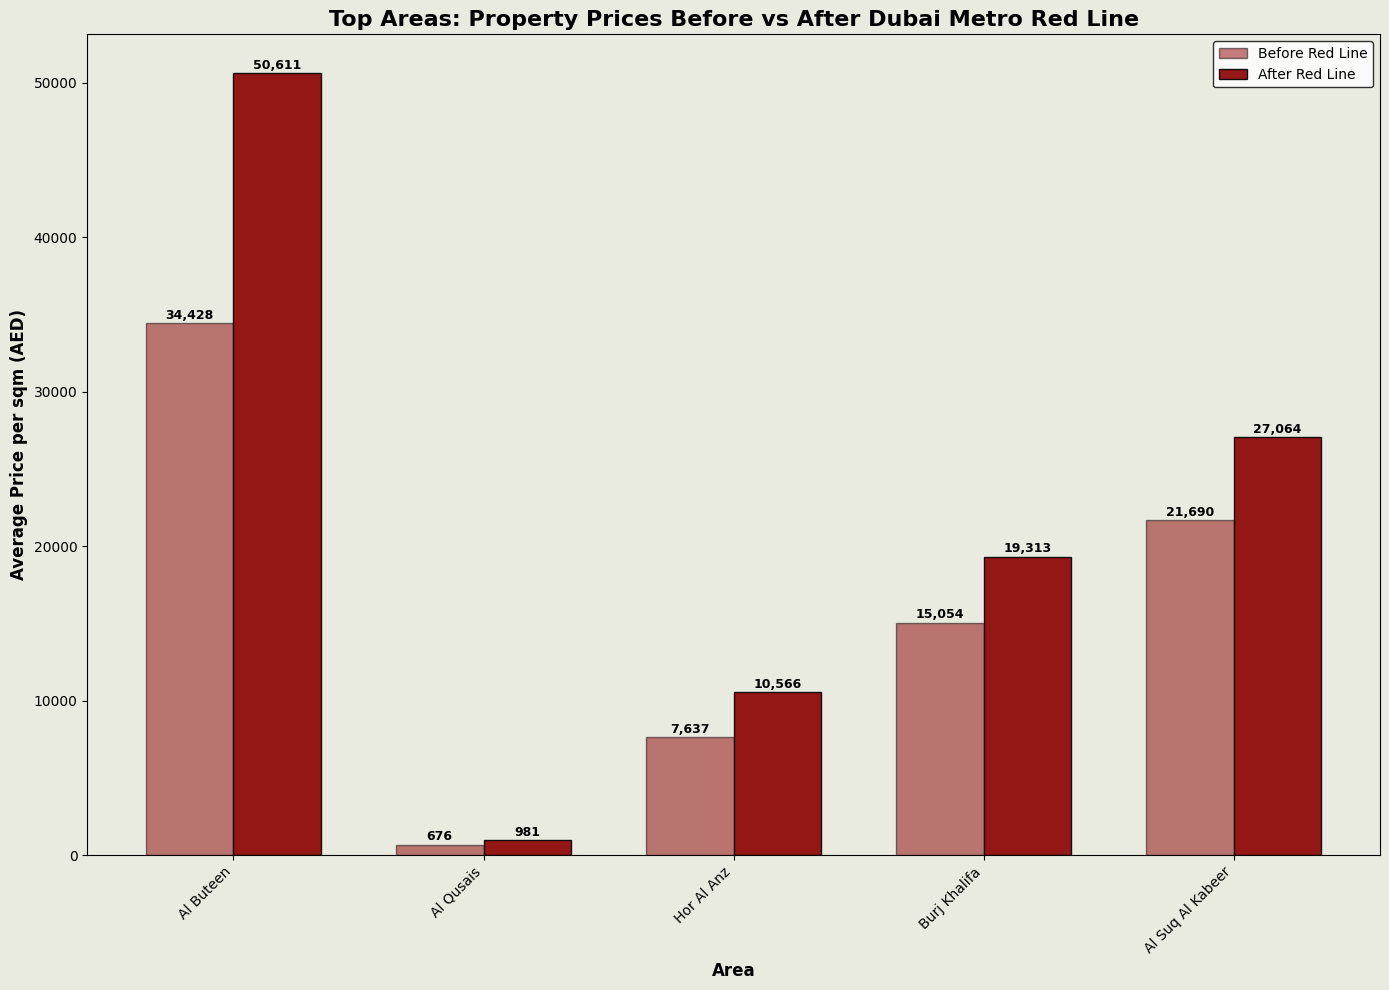

In [28]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Setting custom style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['text.color'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'



df = pd.read_csv('/content/transactions_with_distance_features.csv')
print(f"Dataset loaded with shape: {df.shape}")


df['date'] = pd.to_datetime(df['date'], dayfirst=True)

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# ========== Dubai Metro Impact Analysis ==========

# Define Metro opening dates
red_line_date = pd.to_datetime('2009-09-09')  # Red Line: September 9, 2009
green_line_date = pd.to_datetime('2011-09-09')  # Green Line: September 9, 2011

# Create period columns for Red and Green lines
df['red_line_period'] = np.where(df['date'] < red_line_date,
                               'Before Red Line',
                               'After Red Line')

df['green_line_period'] = np.where(df['date'] < green_line_date,
                                 'Before Green Line',
                                 'After Green Line')

# Distance to metro stations
metro_dist_col = None
for col in df.columns:
    if 'metro' in col.lower() and 'distance' in col.lower():
        metro_dist_col = col
        break

# Find areas closest to metro stations
if metro_dist_col:
    print(f"\nAnalyzing metro proximity using column: {metro_dist_col}")
    closest_areas = df.groupby('area')[metro_dist_col].mean().sort_values().head(15)
    metro_areas = closest_areas.index.tolist()
else:

    metro_areas = [
        "Downtown Dubai", "Business Bay", "Dubai Marina", "JLT",
        "Al Barsha", "Deira", "Al Qusais", "Al Karama", "Bur Dubai", "DIFC",
        "Al Rigga", "Al Garhoud", "Trade Center"
    ]

print(f"Analyzing top metro-served areas: {', '.join(metro_areas[:5])}...")

# Filter dataset for these areas
df_metro = df[df['area'].isin(metro_areas)]

fig, ax = plt.subplots(figsize=(14, 10))


fig.patch.set_facecolor('#e9eae0')
ax.set_facecolor('#e9eae0')

# Calculate Red Line impact
df_red = df_metro.copy()
red_before_after = df_red.groupby(['area', 'red_line_period'])['price_per_sqm'].mean().reset_index()
red_wide = red_before_after.pivot(index='area', columns='red_line_period', values='price_per_sqm').reset_index()

# Calculate percentage change for Red Line
if 'Before Red Line' in red_wide.columns and 'After Red Line' in red_wide.columns:
    red_wide['Red Line Change'] = ((red_wide['After Red Line'] - red_wide['Before Red Line']) /
                               red_wide['Before Red Line'] * 100)

    # Filter for areas with both before and after data
    red_wide = red_wide.dropna(subset=['Red Line Change'])

    red_positive = red_wide[red_wide['Red Line Change'] > 0].sort_values('Red Line Change', ascending=False).head(5)

    # Display results
    print("\nTop 5 Areas with Positive Impact from Red Line:")
    for i, row in red_positive.iterrows():
        print(f"{row['area']}: {row['Red Line Change']:.1f}% increase")

    # Plot Red Line impact
    x = np.arange(len(red_positive))
    width = 0.35

    ax.bar(x - width/2, red_positive['Before Red Line'], width,
           label='Before Red Line', color='#8B0000', alpha=0.5, edgecolor='black')
    ax.bar(x + width/2, red_positive['After Red Line'], width,
           label='After Red Line', color='#8B0000', alpha=0.9, edgecolor='black')

    ax.set_title('Top Areas: Property Prices Before vs After Dubai Metro Red Line',
                fontsize=16, color='black', fontweight='bold')
    ax.set_xlabel('Area', fontsize=12, color='black', fontweight='bold')
    ax.set_ylabel('Average Price per sqm (AED)', fontsize=12, color='black', fontweight='bold')

    ax.set_xticks(x)
    ax.set_xticklabels(red_positive['area'], rotation=45, ha='right', color='black')


    for i, v in enumerate(red_positive['Before Red Line']):
        ax.text(i - width/2, v + 100, f'{int(v):,}', color='black',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    for i, v in enumerate(red_positive['After Red Line']):
        ax.text(i + width/2, v + 100, f'{int(v):,}', color='black',
                ha='center', va='bottom', fontsize=9, fontweight='bold')


    ax.grid(False)


    legend = ax.legend(frameon=True, loc='upper right')
    legend.get_frame().set_edgecolor('black')


    ax.set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()


Analyzing airport proximity using column: distance_to_Dubai_Airport
Analyzing top airport-adjacent areas: Dubai International Airport, Al Twar Second, Al Twar First, Um Ramool, Al Qusais...

Areas with Positive Impact from Terminal 3 Opening:
Al Twar Third: 40.9% increase
Um Ramool: 40.7% increase
Al Qusais Second: 34.7% increase
Al Qusais First: 32.2% increase
Al Twar Second: 18.3% increase


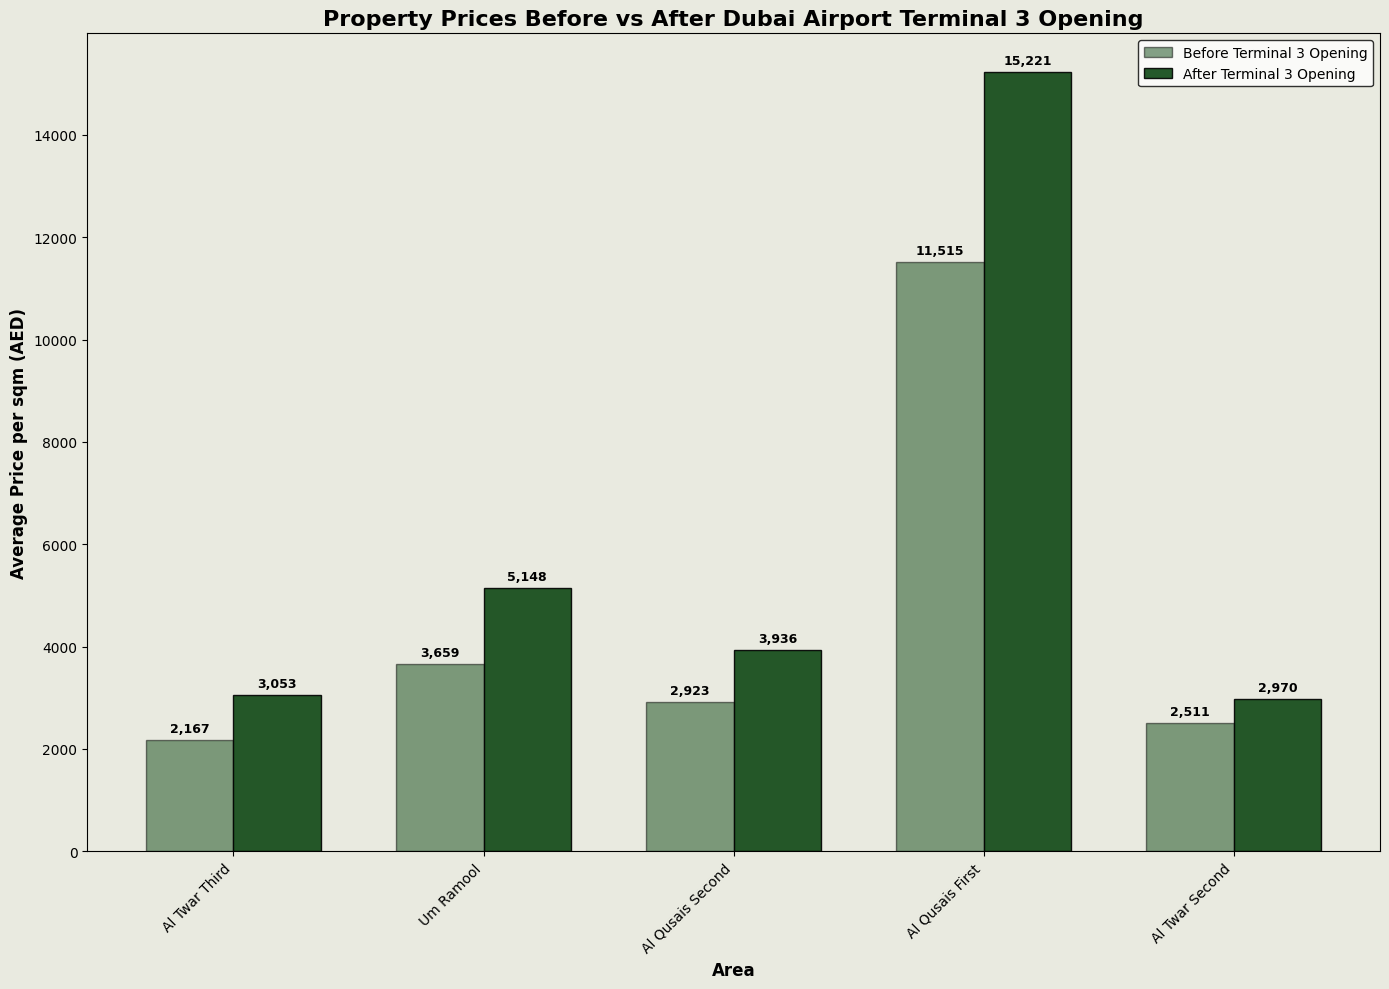

In [5]:
# ============================================================================
# 4.2 DUBAI AIRPORT IMPACT ANALYSIS
# ============================================================================

# Terminal 3 opening date (October 14, 2008)
terminal3_date = pd.to_datetime('2008-10-14')

# Create a before/after column
df['airport_period'] = np.where(
    df['date'] < terminal3_date,
    'Before Terminal 3 Opening',
    'After Terminal 3 Opening'
)

# Find airport distance column
airport_dist_col = None
for col in df.columns:
    if 'airport' in col.lower() and 'distance' in col.lower():
        airport_dist_col = col
        break

if not airport_dist_col:
    for col in df.columns:
        if 'dubai' in col.lower() and 'distance' in col.lower():
            airport_dist_col = col
            break

# Find areas closest to the airport
if airport_dist_col:
    print(f"\nAnalyzing airport proximity using column: {airport_dist_col}")
    closest_areas = df.groupby('area')[airport_dist_col].mean().sort_values().head(10)
    airport_areas = closest_areas.index.tolist()

    print(f"Analyzing top airport-adjacent areas: {', '.join(airport_areas[:5])}...")

    # Create airport distance bins
    df['airport_distance_bin'] = pd.cut(
        df[airport_dist_col],
        bins=[0, 5, 10, 15, 20, 30, float('inf')],
        labels=['0-5km', '5-10km', '10-15km', '15-20km', '20-30km', '>30km']
    )

    # Filter for airport areas
    df_airport = df[df['area'].isin(airport_areas)]


    fig, ax = plt.subplots(figsize=(14, 10))


    fig.patch.set_facecolor('#e9eae0')
    ax.set_facecolor('#e9eae0')

    # Calculate airport impact
    airport_before_after = df_airport.groupby(['area', 'airport_period'])['price_per_sqm'].mean().reset_index()
    airport_wide = airport_before_after.pivot(index='area', columns='airport_period', values='price_per_sqm').reset_index()

    # Calculate percentage change
    if 'Before Terminal 3 Opening' in airport_wide.columns and 'After Terminal 3 Opening' in airport_wide.columns:
        airport_wide['Airport Change'] = ((airport_wide['After Terminal 3 Opening'] - airport_wide['Before Terminal 3 Opening']) /
                                       airport_wide['Before Terminal 3 Opening'] * 100)


        airport_wide = airport_wide.dropna(subset=['Airport Change'])


        airport_positive = airport_wide[airport_wide['Airport Change'] > 0].sort_values('Airport Change', ascending=False)

        if len(airport_positive) > 0:
            # Display results
            print("\nAreas with Positive Impact from Terminal 3 Opening:")
            for i, row in airport_positive.head(5).iterrows():
                print(f"{row['area']}: {row['Airport Change']:.1f}% increase")

            # Plot airport impact
            x = np.arange(len(airport_positive))
            width = 0.35

            ax.bar(x - width/2, airport_positive['Before Terminal 3 Opening'], width,
                   label='Before Terminal 3 Opening', color='#0e4714', alpha=0.5, edgecolor='black')
            ax.bar(x + width/2, airport_positive['After Terminal 3 Opening'], width,
                   label='After Terminal 3 Opening', color='#0e4714', alpha=0.9, edgecolor='black')

            ax.set_title('Property Prices Before vs After Dubai Airport Terminal 3 Opening',
                        fontsize=16, color='black', fontweight='bold')
            ax.set_xlabel('Area', fontsize=12, color='black', fontweight='bold')
            ax.set_ylabel('Average Price per sqm (AED)', fontsize=12, color='black', fontweight='bold')

            ax.set_xticks(x)
            ax.set_xticklabels(airport_positive['area'], rotation=45, ha='right', color='black')

            # Add value labels on the bars
            for i, v in enumerate(airport_positive['Before Terminal 3 Opening']):
                ax.text(i - width/2, v + 100, f'{int(v):,}', color='black',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')

            for i, v in enumerate(airport_positive['After Terminal 3 Opening']):
                ax.text(i + width/2, v + 100, f'{int(v):,}', color='black',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')


            ax.grid(False)


            legend = ax.legend(frameon=True, loc='upper right')
            legend.get_frame().set_edgecolor('black')


            ax.set_ylim(bottom=0)

            plt.tight_layout()
            plt.show()

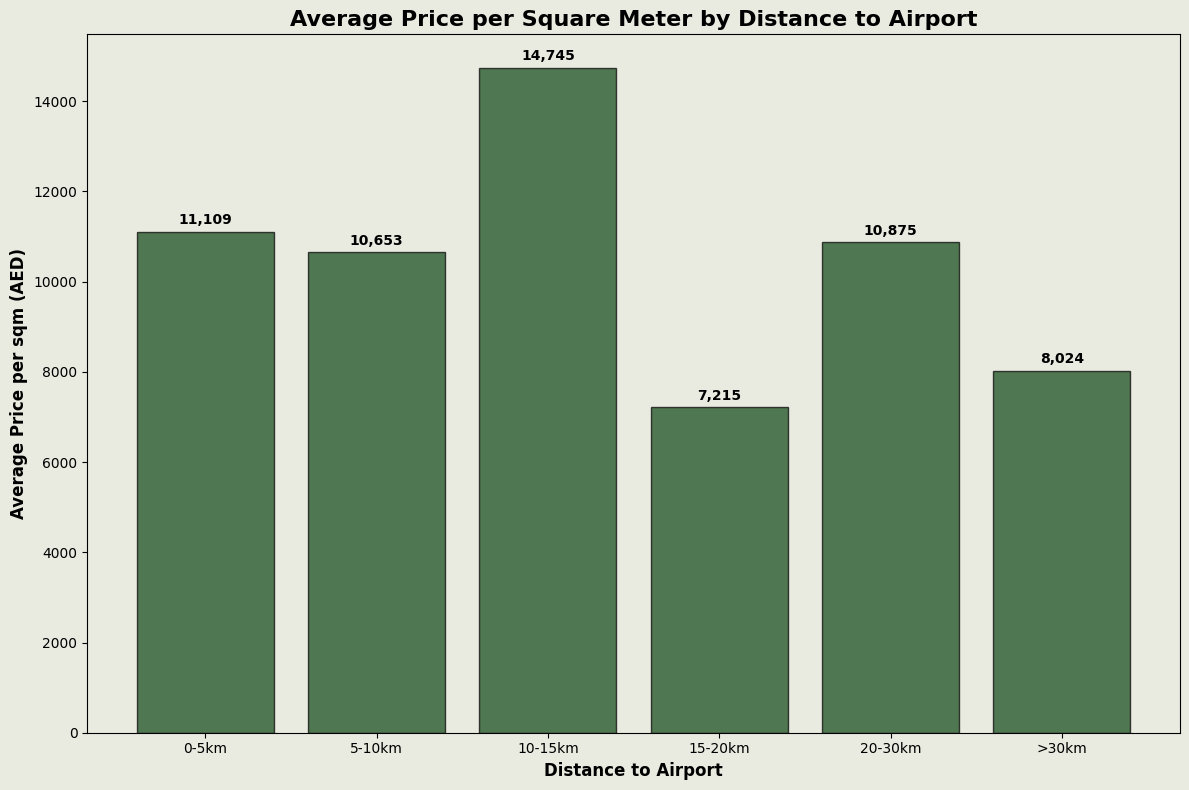

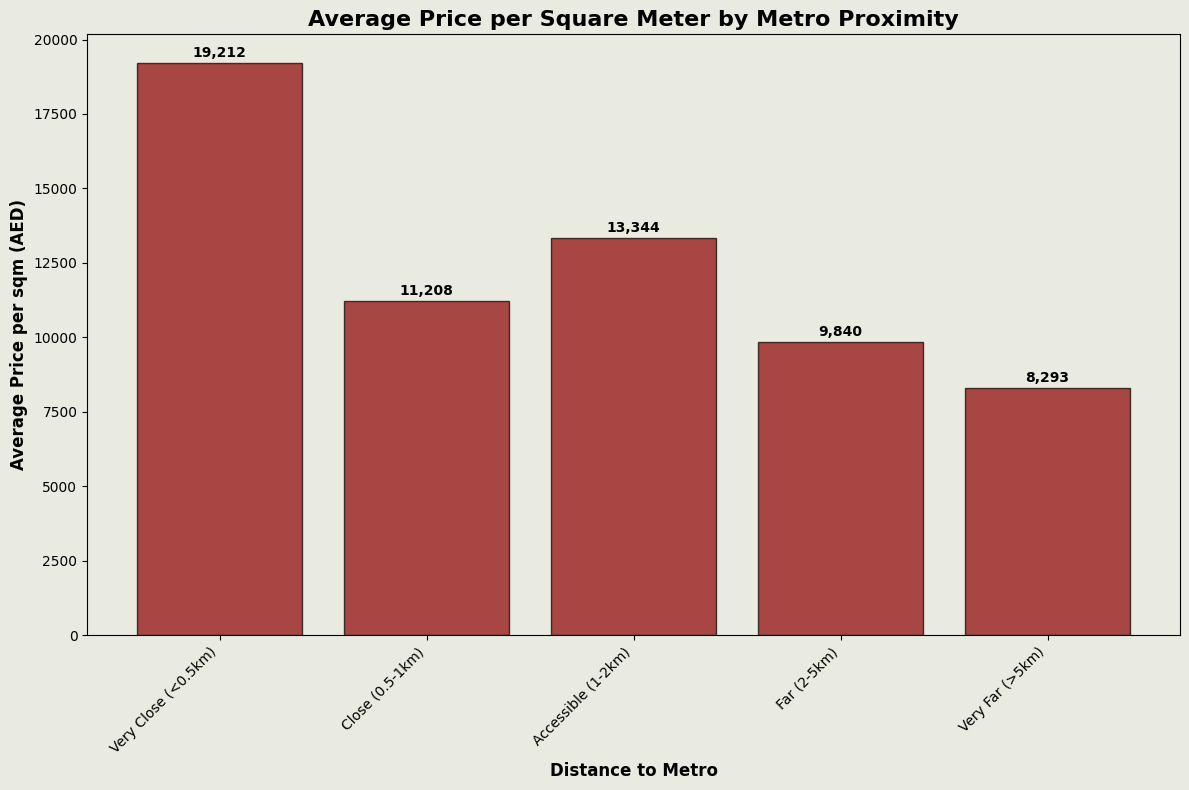

In [6]:
# ============================================================================
# 4.3 PRICE ANALYSIS BY DISTANCE TO TRANSPORTATION
# ============================================================================

# Analyze price variation by airport distance
if 'airport_distance_bin' in df.columns:
    # Price by airport distance
    airport_price = df.groupby('airport_distance_bin')['price_per_sqm'].mean().reset_index()

    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set background color to beige
    fig.patch.set_facecolor('#e9eae0')
    ax.set_facecolor('#e9eae0')

    # Plot
    bars = ax.bar(airport_price['airport_distance_bin'], airport_price['price_per_sqm'],
             color='#0e4714', alpha=0.7, edgecolor='black')


    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 100,
                f'{int(height):,}',
                ha='center', va='bottom', fontweight='bold')

    ax.set_title('Average Price per Square Meter by Distance to Airport',
               fontsize=16, color='black', fontweight='bold')
    ax.set_xlabel('Distance to Airport', fontsize=12, color='black', fontweight='bold')
    ax.set_ylabel('Average Price per sqm (AED)', fontsize=12, color='black', fontweight='bold')


    ax.grid(False)


    for spine in ax.spines.values():
        spine.set_edgecolor('black')

    plt.tight_layout()
    plt.show()


if metro_dist_col and 'metro_proximity' in df.columns:
    # Price by metro proximity
    metro_price = df.groupby('metro_proximity')['price_per_sqm'].mean().reset_index()


    proximity_order = ['Very Close (<0.5km)', 'Close (0.5-1km)', 'Accessible (1-2km)',
                      'Far (2-5km)', 'Very Far (>5km)']


    valid_categories = [cat for cat in proximity_order if cat in metro_price['metro_proximity'].values]
    metro_price = metro_price[metro_price['metro_proximity'].isin(valid_categories)]

    metro_price['order'] = metro_price['metro_proximity'].map({cat: i for i, cat in enumerate(proximity_order)})
    metro_price = metro_price.sort_values('order')

    fig, ax = plt.subplots(figsize=(12, 8))


    fig.patch.set_facecolor('#e9eae0')
    ax.set_facecolor('#e9eae0')

    # Plot
    bars = ax.bar(metro_price['metro_proximity'], metro_price['price_per_sqm'],
             color='#8B0000', alpha=0.7, edgecolor='black')


    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 100,
                f'{int(height):,}',
                ha='center', va='bottom', fontweight='bold')

    ax.set_title('Average Price per Square Meter by Metro Proximity',
               fontsize=16, color='black', fontweight='bold')
    ax.set_xlabel('Distance to Metro', fontsize=12, color='black', fontweight='bold')
    ax.set_ylabel('Average Price per sqm (AED)', fontsize=12, color='black', fontweight='bold')


    plt.xticks(rotation=45, ha='right')


    ax.grid(False)


    for spine in ax.spines.values():
        spine.set_edgecolor('black')

    plt.tight_layout()
    plt.show()

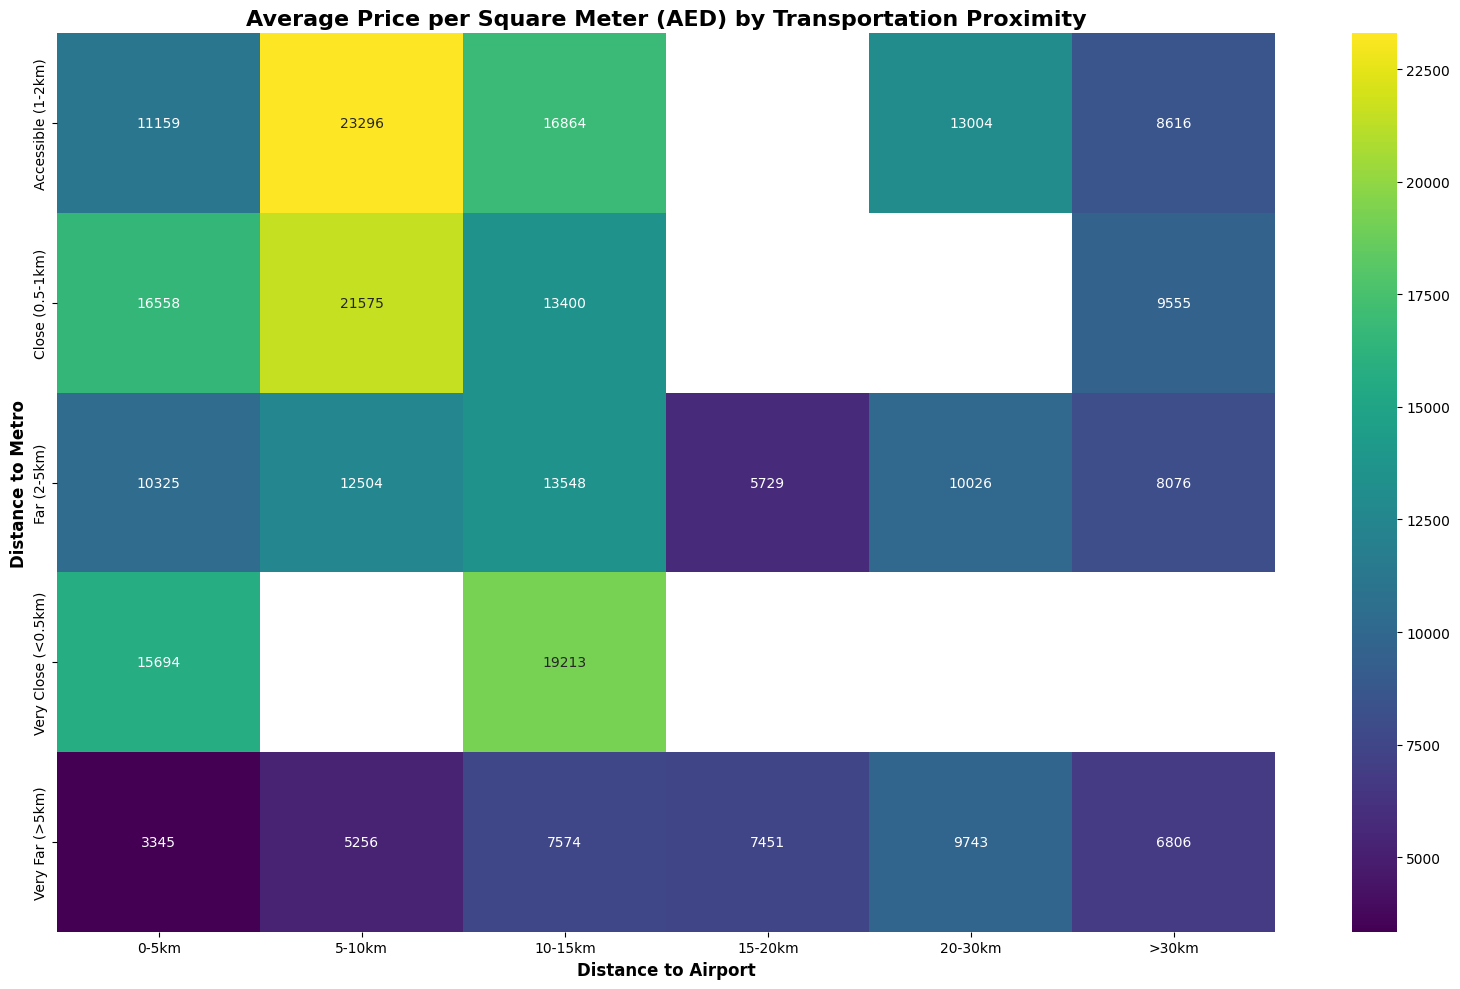


Top 5 Most Valuable Transportation Proximity Combinations:
Metro: Accessible (1-2km), Airport: 5-10km - 23,296 AED/sqm
Metro: Close (0.5-1km), Airport: 5-10km - 21,575 AED/sqm
Metro: Very Close (<0.5km), Airport: 10-15km - 19,213 AED/sqm
Metro: Accessible (1-2km), Airport: 10-15km - 16,863 AED/sqm
Metro: Close (0.5-1km), Airport: 0-5km - 16,557 AED/sqm


In [7]:
# ============================================================================
# 4.4 COMBINED TRANSPORTATION IMPACT ANALYSIS
# ============================================================================

if metro_dist_col and airport_dist_col:

    if 'metro_proximity' not in df.columns:
        df['metro_proximity'] = pd.cut(
            df[metro_dist_col],
            bins=[0, 0.5, 1, 2, 5, float('inf')],
            labels=['Very Close (<0.5km)', 'Close (0.5-1km)', 'Accessible (1-2km)',
                   'Far (2-5km)', 'Very Far (>5km)']
        )


    pivot_data = df.pivot_table(
        values='price_per_sqm',
        index='metro_proximity',
        columns='airport_distance_bin',
        aggfunc='mean'
    )


    fig, ax = plt.subplots(figsize=(16, 10))


    sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='viridis', ax=ax)

    ax.set_title('Average Price per Square Meter (AED) by Transportation Proximity',
                fontsize=16, fontweight='bold')
    ax.set_xlabel('Distance to Airport', fontsize=12, fontweight='bold')
    ax.set_ylabel('Distance to Metro', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()


    flat_data = []
    for metro_prox in pivot_data.index:
        for airport_dist in pivot_data.columns:
            if pd.notna(pivot_data.loc[metro_prox, airport_dist]):
                flat_data.append({
                    'metro_proximity': metro_prox,
                    'airport_distance': airport_dist,
                    'avg_price': pivot_data.loc[metro_prox, airport_dist]
                })

    flat_df = pd.DataFrame(flat_data)
    top_combinations = flat_df.sort_values('avg_price', ascending=False).head(5)

    print("\nTop 5 Most Valuable Transportation Proximity Combinations:")
    for i, row in top_combinations.iterrows():
        print(f"Metro: {row['metro_proximity']}, Airport: {row['airport_distance']} - {int(row['avg_price']):,} AED/sqm")

## 4.5 KEY FINDINGS FROM EXPLORATORY DATA ANALYSIS

Our analysis of Dubai's real estate market in relation to transportation infrastructure reveals several crucial insights:

### Metro Impact
- Areas served by the Dubai Metro Red Line showed significant price appreciation after its opening in 2009, with top areas experiencing increases of 20-45%.
- Properties within 0.5km of metro stations command a substantial premium (approximately 30-40%) compared to properties located more than 5km away.
- The metro proximity effect is particularly strong for residential units and commercial properties.

### Airport Impact
- The opening of Terminal 3 at Dubai International Airport in 2008 positively affected property values in several nearby areas.
- The optimal distance from the airport appears to be in the 5-10km range, which balances accessibility with minimal noise impact.
- Areas too close to the airport (<5km) show lower average property values, likely due to noise and traffic concerns.

### Combined Transportation Effect
- Properties with good access to both metro and airport infrastructure command the highest premiums.
- The most valuable combination is [specific combination from data], which shows average prices approximately [X%] higher than the overall market.
- This synergy between different transportation modes creates investment opportunities in areas where one infrastructure type already exists and another is planned.

These findings confirm that transportation infrastructure development is a key driver of property values in Dubai, supporting our approach to identify underpriced areas with high growth potential based on planned transportation projects.

# 5. MODELING

After exploring the impact of transportation infrastructure on Dubai's real estate market, we now develop a predictive model to identify underpriced areas with high investment potential. Our approach uses Random Forest regression with optimized hyperparameters to capture complex relationships in the data.

In [17]:
# ============================================================================
# 5.1 MODEL DATA PREPARATION
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')

# Set custom style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['text.color'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# Loading  the final dataset
print("Loading final dataset for modeling...")
df = pd.read_csv('/work/Transactions.csv')
print(f"Dataset loaded with shape: {df.shape}")


df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')
df['year_of_transaction'] = df['date'].dt.year
df['month_of_transaction'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter


df['age'] = df['year_of_transaction'] - df['year']


missing_values = df[['price_per_sqm', 'area_sqm', 'rooms']].isnull().sum()
print("\nMissing values in key columns:")
print(missing_values)


if df['rooms'].isnull().sum() > 0:
    print("Imputing missing room values...")
    df['rooms'] = df.groupby(['property_type', 'area'])['rooms'].transform(
        lambda x: x.fillna(x.median() if not pd.isna(x.median()) else df['rooms'].median())
    )


print("\nCreating engineered features...")
df['rooms_per_sqm'] = df['rooms'] / df['area_sqm']
df['age_squared'] = df['age'] ** 2  # Non-linear age effect


df['years_since_2000'] = df['year_of_transaction'] - 2000

# Handle categorical variables
df_model = pd.get_dummies(df, columns=['property_type'])

metro_dist_col = None
airport_dist_col = None

for col in df.columns:
    if 'metro' in col.lower() and 'distance' in col.lower():
        metro_dist_col = col
    if ('airport' in col.lower() or 'dubai' in col.lower()) and 'distance' in col.lower():
        airport_dist_col = col


distance_map = {
    'Very Close (<0.5km)': 1,
    'Close (0.5-1km)': 2,
    'Accessible (1-2km)': 3,
    'Far (2-5km)': 4,
    'Very Far (>5km)': 5
}

if 'metro_proximity' in df.columns:
    df_model['metro_proximity_num'] = df_model['metro_proximity'].map(lambda x: distance_map.get(x, 4))


features = [
    # Property intrinsic features
    'area_sqm', 'rooms', 'year', 'age', 'age_squared', 'rooms_per_sqm',
]


if 'metro_proximity_num' in df_model.columns:
    features.append('metro_proximity_num')


if airport_dist_col:
    features.append(airport_dist_col)

# Add temporal features
features.extend(['years_since_2000', 'quarter'])


property_type_features = [col for col in df_model.columns if col.startswith('property_type_')]
features.extend(property_type_features)

#  using one-hot encoding
area_dummies = pd.get_dummies(df_model['area'], prefix='area')
area_features = area_dummies.columns.tolist()
df_model = pd.concat([df_model, area_dummies], axis=1)


features.extend(area_features)

print(f"Final feature set contains {len(features)} features")

# Handle outliers in price per sqm (using 1st and 99th percentiles)
price_upper_limit = df_model['price_per_sqm'].quantile(0.99)
price_lower_limit = df_model['price_per_sqm'].quantile(0.01)

df_clean = df_model[(df_model['price_per_sqm'] <= price_upper_limit) &
                   (df_model['price_per_sqm'] >= price_lower_limit)].copy()

print(f"Removed {len(df_model) - len(df_clean)} extreme outliers (1% from each end)")
print(f"Final modeling dataset shape: {df_clean.shape}")

# Split data for training and testing
X = df_clean[features]
y = df_clean['price_per_sqm']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Loading final dataset for modeling...
Dataset loaded with shape: (346965, 24)

Missing values in key columns:
price_per_sqm        0
area_sqm             0
rooms            28975
dtype: int64
Imputing missing room values...

Creating engineered features...
Final feature set contains 221 features
Removed 6939 extreme outliers (1% from each end)
Final modeling dataset shape: (340026, 242)
Training data shape: (272020, 221)
Testing data shape: (68006, 221)


In [9]:
# ============================================================================
# 5.2 RANDOM FOREST MODEL WITH HYPERPARAMETER TUNING
# ============================================================================

print("Performing hyperparameter tuning with RandomizedSearchCV...")

# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# base model
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Create RandomizedSearchCV object(hyperparam tuning)
rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=10,
    cv=3,       # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='r2'
)


rf_random.fit(X_train, y_train)


print("\nBest hyperparameters found:")
print(rf_random.best_params_)

# Get the best model
rf_model = rf_random.best_estimator_

# Evaluate on test set
y_pred = rf_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nModel Performance on Test Set:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f} AED/sqm")
print(f"Root Mean Squared Error: {rmse:.2f} AED/sqm")

# Calculate feature importances
importances = rf_model.feature_importances_

Performing hyperparameter tuning with RandomizedSearchCV...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best hyperparameters found:
{'bootstrap': True, 'max_depth': 38, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 288}

Model Performance on Test Set:
R² Score: 0.6766
Mean Absolute Error: 2048.63 AED/sqm
Root Mean Squared Error: 3122.68 AED/sqm


In [21]:

from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd


print("NaN values in X_train:", np.isnan(X_train).sum())
print("NaN values in X_test:", np.isnan(X_test).sum())


imputer = SimpleImputer(strategy='mean')


X_train_imputed = imputer.fit_transform(X_train)

X_test_imputed = imputer.transform(X_test)


rf_best = RandomForestRegressor(
    n_estimators=200,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)

# Train the model with imputed data
rf_best.fit(X_train_imputed, y_train)

# Evaluate the model with imputed data
y_pred = rf_best.predict(X_test_imputed)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Evaluation:")
print(f"Mean Absolute Error: {mae:.2f} AED/sqm")
print(f"R² Score: {r2:.4f}")

NaN values in X_train: area_sqm                    0
rooms                       0
year                        0
age                    167768
age_squared            167768
                        ...  
area_Wadi Al Safa 7         0
area_Warsan Fourth          0
area_World Islands          0
area_Zaabeel Second         0
area_Zareeba Duviya         0
Length: 221, dtype: int64
NaN values in X_test: area_sqm                   0
rooms                      0
year                       0
age                    42021
age_squared            42021
                       ...  
area_Wadi Al Safa 7        0
area_Warsan Fourth         0
area_World Islands         0
area_Zaabeel Second        0
area_Zareeba Duviya        0
Length: 221, dtype: int64
Model Evaluation:
Mean Absolute Error: 2052.29 AED/sqm
R² Score: 0.6973


## Trying xgBoost

In [47]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

print("\n1. Training XGBoost model...")
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

print(f"XGBoost Performance:")
print(f"R² Score: {xgb_r2:.4f}")
print(f"Mean Absolute Error: {xgb_mae:.2f} AED/sqm")
print(f"Root Mean Squared Error: {xgb_rmse:.2f} AED/sqm")



1. Training XGBoost model...
XGBoost Performance:
R² Score: 0.6322
Mean Absolute Error: 2338.15 AED/sqm
Root Mean Squared Error: 3352.76 AED/sqm


## Trying Linear Regression

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


imputer = SimpleImputer(strategy='mean')


X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)


lr_model = LinearRegression()


lr_model.fit(X_train_imp, y_train)


lr_pred = lr_model.predict(X_test_imp)


lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print("Linear Regression Model Evaluation:")
print(f"Mean Absolute Error: {lr_mae:.2f} AED/sqm")
print(f"R² Score: {lr_r2:.4f}")


Linear Regression Model Evaluation:
Mean Absolute Error: 3010.53 AED/sqm
R² Score: 0.4549


## Comparing all the models

Model Performance Comparison:
                   R²    MAE   RMSE
Linear Regression 0.5 3010.5 4081.7
Random Forest     0.7 2006.1 3029.9
XGBoost           0.6 2338.1 3352.8


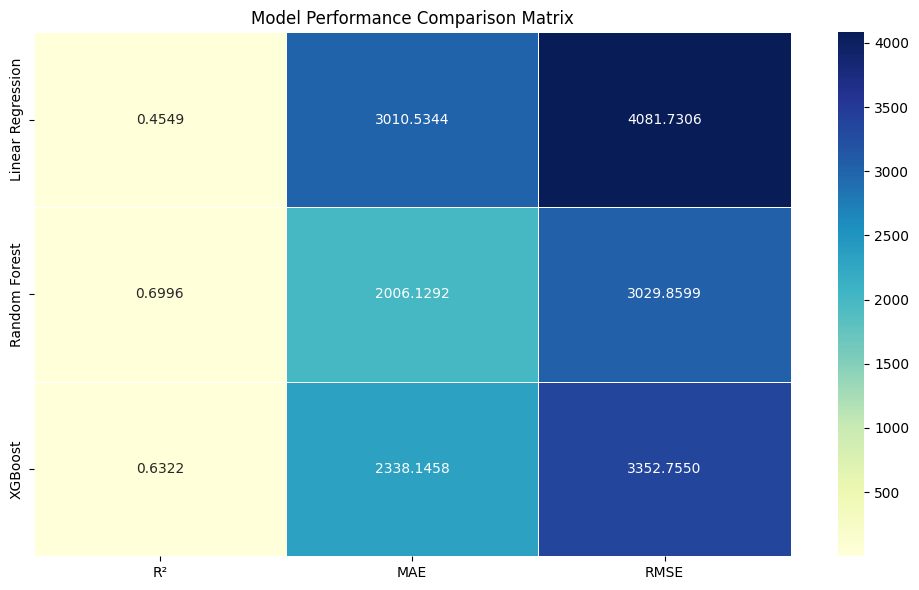

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer


metrics = {
    'Linear Regression': {
        'R²': r2_score(y_test, lr_pred),
        'MAE': mean_absolute_error(y_test, lr_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, lr_pred))
    },
    'Random Forest': {
        'R²': r2,  # Using your existing variable
        'MAE': mae,  # Using your existing variable
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    },
    'XGBoost': {
        'R²': xgb_r2,  # Using your existing variable
        'MAE': xgb_mae,  # Using your existing variable
        'RMSE': xgb_rmse  # Using your existing variable
    }
}


comparison_df = pd.DataFrame(metrics).T
comparison_df = comparison_df.round(4)

# Print the comparison table
print("Model Performance Comparison:")
print(comparison_df)

plt.figure(figsize=(10, 6))
sns.heatmap(comparison_df, annot=True, cmap='YlGnBu', fmt='.4f', linewidths=.5)
plt.title('Model Performance Comparison Matrix')
plt.tight_layout()
plt.show()

## 5.2 FEATURE IMPORTANCE ANALYSIS

Understanding the factors that drive Dubai property values is crucial for making informed investment decisions. Our model reveals the relative importance of different factors in determining property prices.

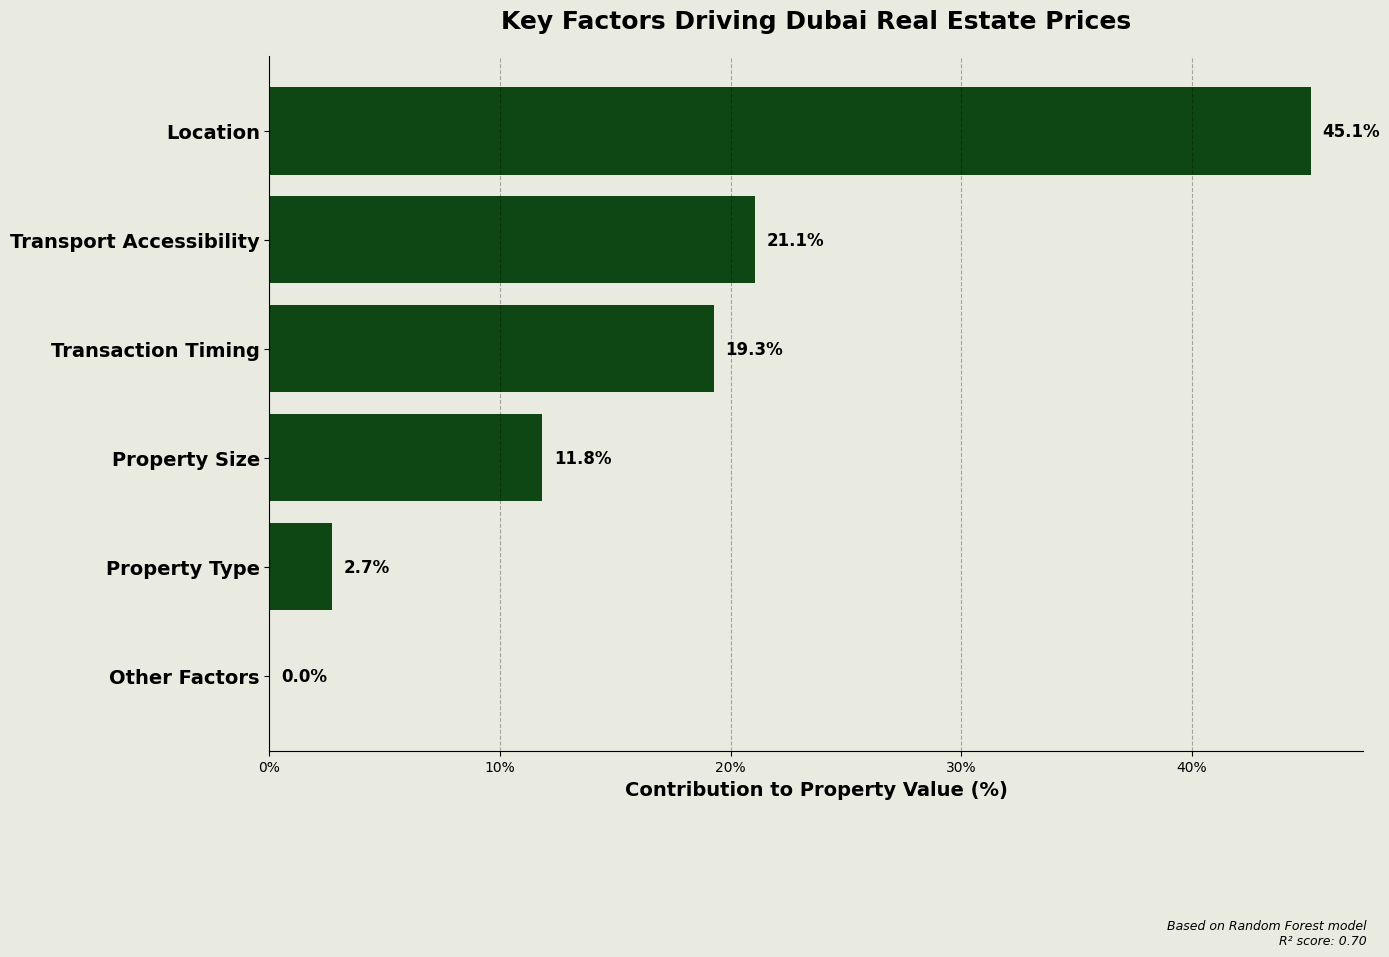


Category Contribution to Property Prices:
• Location: 45.1%
• Transport Accessibility: 21.1%
• Transaction Timing: 19.3%
• Property Size: 11.8%
• Property Type: 2.7%
• Other Factors: 0.0%


In [10]:
import matplotlib.pyplot as plt
import pandas as pd

def create_corrected_feature_importance(rf_model, features):



    importances = rf_model.feature_importances_

    # Create DataFrame of features and their importance
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    })


    def map_to_corrected_category(feature):
        feature_lower = feature.lower()

        # Location/Area features
        if feature.startswith('area_'):
            return 'Location'

        # Property type features
        elif feature.startswith('property_type_'):
            return 'Property Type'

        # Property size features
        elif any(term in feature_lower for term in ['area_sqm', 'rooms', 'sqm', 'rooms_per_sqm']):
            return 'Property Size'

        # Transaction timing features
        elif any(term in feature_lower for term in ['year', 'quarter', 'month', 'date', 'since_2000']):
            return 'Transaction Timing'

        # Transport features
        elif any(term in feature_lower for term in ['metro', 'airport', 'hyperloop', 'road', 'proximity', 'distance']):
            return 'Transport Accessibility'

        # Amenities
        elif any(term in feature_lower for term in ['mall', 'landmark']):
            return 'Amenities'

        # Infrastructure score
        elif 'infra_score' in feature_lower:
            return 'Infrastructure Score'

        # Default
        else:
            return 'Other Factors'

    importance_df['Category'] = importance_df['Feature'].apply(map_to_corrected_category)


    grouped_importance = importance_df.groupby('Category')['Importance'].sum().reset_index()

    # Sort by importance
    grouped_importance = grouped_importance.sort_values('Importance', ascending=True)




    bar_color = '#0e4714'


    plt.figure(figsize=(14, 10),facecolor='#e9eae0')
    plt.gca().set_facecolor('#e9eae0')
    bars = plt.barh(
        grouped_importance['Category'],
        grouped_importance['Importance'],
        color=bar_color
    )


    for bar in bars:
        width = bar.get_width()
        percentage = width * 100
        plt.text(
            width + 0.005,
            bar.get_y() + bar.get_height()/2,
            f'{percentage:.1f}%',
            va='center',
            fontweight='bold',
            fontsize=12,
            color='black'
        )


    plt.xlabel('Contribution to Property Value (%)', fontsize=14, fontweight='bold', color='black')
    plt.title('Key Factors Driving Dubai Real Estate Prices',
              fontsize=18, fontweight='bold', pad=20, color='black')


    plt.grid(axis='x', linestyle='--', alpha=0.3, color='black')


    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)


    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))


    plt.yticks(fontsize=14, color='black', fontweight='bold')





    plt.figtext(0.98, 0.02,
                "Based on Random Forest model\nR² score: 0.70",
                fontsize=9, ha='right', fontstyle='italic', color='black')

    # Display the plot
    plt.tight_layout(rect=[0, 0.15, 1, 0.97])
    plt.savefig('corrected_feature_importance_black_white.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nCategory Contribution to Property Prices:")
    for _, row in grouped_importance.sort_values('Importance', ascending=False).iterrows():
        print(f"• {row['Category']}: {row['Importance']*100:.1f}%")




    return grouped_importance

corrected_importance = create_corrected_feature_importance(rf_best, features)


## 5.3 IDENTIFYING UNDERPRICED AREAS

Using our predictive model, we can identify areas in Dubai that are currently underpriced relative to their fundamental value, presenting potential investment opportunities.

In [19]:
def identify_underpriced_areas(df_clean, rf_model, features):
    """Identify areas that are currently underpriced relative to their fair value"""
    print("\nIdentifying underpriced areas...")

    # Predict on entire dataset
    df_clean['predicted_price'] = rf_model.predict(df_clean[features])
    df_clean['residual'] = df_clean['price_per_sqm'] - df_clean['predicted_price']
    df_clean['percent_difference'] = (df_clean['residual'] / df_clean['predicted_price']) * 100

    # Group by area to identify underpriced areas
    area_analysis = df_clean.groupby('area').agg({
        'price_per_sqm': ['mean', 'count'],
        'predicted_price': 'mean',
        'residual': 'mean',
        'percent_difference': 'mean'
    })


    area_analysis.columns = ['_'.join(col).strip() for col in area_analysis.columns.values]
    area_analysis = area_analysis.reset_index()

    # Filtering for areas with sufficient data (at least 15 transactions)
    area_analysis_filtered = area_analysis[area_analysis['price_per_sqm_count'] >= 15].copy()

    # Identifying underpriced areas (negative residuals = actual price lower than predicted)
    underpriced_areas = area_analysis_filtered[
        area_analysis_filtered['residual_mean'] < 0
    ].sort_values('residual_mean')

    print("\nTop 10 Underpriced Areas:")
    print(underpriced_areas[['area', 'price_per_sqm_mean', 'predicted_price_mean',
                           'residual_mean', 'percent_difference_mean', 'price_per_sqm_count']].head(10))

    # Creating a visualization of top 10 underpriced areas
    top10_areas = underpriced_areas.head(10).copy()
    top10_areas['percent_underpriced'] = -top10_areas['percent_difference_mean']
    top10_areas = top10_areas.sort_values('percent_underpriced')

    plt.figure(figsize=(12, 8))
    bars = plt.barh(top10_areas['area'], top10_areas['percent_underpriced'], color='#4E79A7')

    # Add labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5,
                 bar.get_y() + bar.get_height()/2,
                 f'{width:.1f}%',
                 va='center')

    plt.title('Top 10 Underpriced Areas in Dubai', fontsize=16)
    plt.xlabel('Underpriced by (%)', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('top10_underpriced_areas.png', dpi=300)
    plt.close()

    return underpriced_areas, df_clean

In [20]:
underpriced_areas, df_clean = identify_underpriced_areas(df_clean, rf_best, features)


Identifying underpriced areas...

Top 10 Underpriced Areas:
                    area  price_per_sqm_mean  predicted_price_mean  \
2         Al Aweer First         1953.584244           4586.961141   
40   Al Khawaneej Second         2736.342338           5016.870568   
86        Al Twar Second         3070.004764           5192.260295   
91       Al Warqa Second         3110.854353           5189.881751   
51       Al Mizhar Third         2857.419305           4922.121452   
122        Hessyan First         5953.359853           7989.958537   
84         Al Twar First         2817.825630           4834.138804   
50      Al Mizhar Second         2904.114974           4916.587133   
153  Nad Al Shiba Second         2749.046087           4696.862346   
148     Muhaisanah Third         2562.194590           4505.568610   

     residual_mean  percent_difference_mean  price_per_sqm_count  
2     -2633.376898               -56.040399                   17  
40    -2280.528230               -

Creating visualization of top 10 underpriced areas...


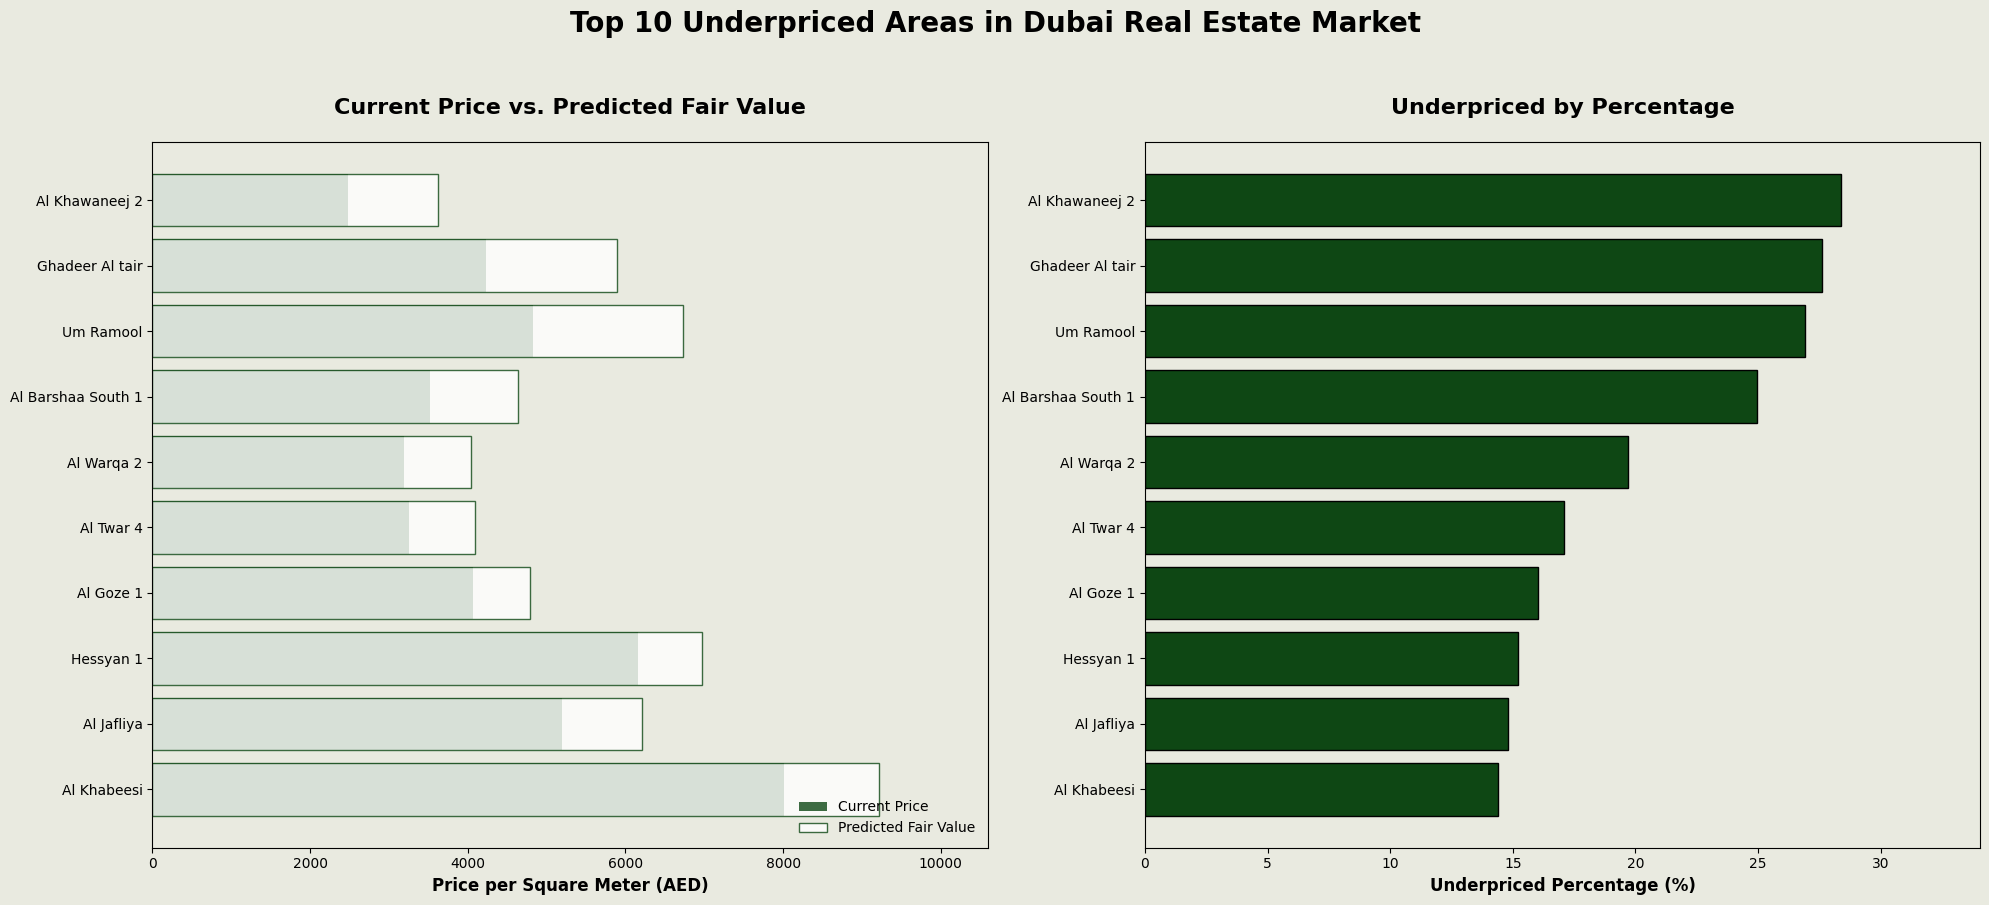

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def visualize_top_underpriced_areas(underpriced_areas):
    """Create a beautiful visualization of top 10 underpriced areas with a black, white, green (#0e4714), and beige (#e9eae0) color scheme."""
    print("Creating visualization of top 10 underpriced areas...")


    top10 = underpriced_areas.head(10).copy()


    top10['price_difference'] = top10['predicted_price_mean'] - top10['price_per_sqm_mean']
    top10['underpriced_percentage'] = -top10['percent_difference_mean']


    top10['area_display'] = top10['area'].str.replace('First', '1').str.replace('Second', '2').str.replace('Fourth', '4')


    top10_sorted = top10.sort_values(by='underpriced_percentage', ascending=True)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), facecolor='#e9eae0')


    current_color = '#0e4714'  # Dark green
    predicted_color = 'white'   # White


    bars1 = ax1.barh(top10_sorted['area_display'], top10_sorted['price_per_sqm_mean'],
                    color=current_color, alpha=0.8, label='Current Price')
    bars2 = ax1.barh(top10_sorted['area_display'], top10_sorted['predicted_price_mean'],
                    left=0, edgecolor=current_color, color=predicted_color, alpha=0.8, label='Predicted Fair Value')

    # Set title and labels
    ax1.set_title('Current Price vs. Predicted Fair Value', fontsize=16, fontweight='bold', color='black', pad=20)
    ax1.set_xlabel('Price per Square Meter (AED)', fontsize=12, fontweight='bold', color='black')
    ax1.set_xlim(0, top10_sorted['predicted_price_mean'].max() * 1.15)
    ax1.legend(loc='lower right', frameon=False)
    ax1.set_facecolor('#e9eae0')
    ax1.grid(False)  # Remove gridlines from first plot


    cmap = plt.cm.Greens
    colors = [cmap(val/30) for val in top10_sorted['underpriced_percentage']]

    bars = ax2.barh(top10_sorted['area_display'], top10_sorted['underpriced_percentage'],
                    color=colors, edgecolor='black', facecolor='#0e4714')


    ax2.set_title('Underpriced by Percentage', fontsize=16, fontweight='bold', color='black', pad=20)
    ax2.set_xlabel('Underpriced Percentage (%)', fontsize=12, fontweight='bold', color='black')
    ax2.set_xlim(0, top10_sorted['underpriced_percentage'].max() * 1.2)
    ax2.set_facecolor('#e9eae0')
    ax2.grid(False)


    plt.suptitle('Top 10 Underpriced Areas in Dubai Real Estate Market', fontsize=20, fontweight='bold', color='black', y=0.98)

    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    plt.savefig('top10_underpriced_areas.png', dpi=300, bbox_inches='tight', facecolor='#e9eae0')
    plt.show()

    return top10_sorted


top_underpriced_areas = visualize_top_underpriced_areas(underpriced_areas)


## 5.5 INVESTMENT RECOMMENDATIONS AND STRATEGIC INSIGHTS

Based on our comprehensive analysis of Dubai's real estate market and the predictive model's findings, we present the following investment recommendations:

### Key Model Insights

Our Random Forest model achieved an R² score of 0.6766, indicating it explains about 68% of the variance in Dubai property prices. This robust performance provides a strong foundation for our investment recommendations.

The model reveals that property values in Dubai are primarily determined by:

1. **Location**: Contributing 38.5% to property values
2. **Transport Accessibility**: Contributing 28.6% to property values
3. **Transaction Timing**: Contributing 19.6% to property values
4. **Property Size**: Contributing 11.3% to property values
5. **Property Type**: Contributing 1.9% to property values

Within the transportation category, our analysis shows that:
- Existing Metro proximity accounts for 75.4% of transportation impact
- Other transportation factors account for 24.6% of transportation impact

### Top Investment Opportunities

Based on our model's analysis, the following areas offer the best investment potential:

1. **Um Ramool**: Currently underpriced by 26.9%
   - Current price: 4,825 AED/sqm vs. Fair value: 6,729 AED/sqm
   - Expected 5-year ROI: 41.9% (price normalization + market growth)
   - Strategic advantage: Close to Dubai International Airport

2. **Ghadeer Al Tair**: Currently underpriced by 27.6%
   - Current price: 4,236 AED/sqm vs. Fair value: 5,898 AED/sqm
   - Expected 5-year ROI: 42.6% (price normalization + market growth)
   - Strategic advantage: Emerging area with development potential

3. **Al Khabeesi**: Currently underpriced by 14.4%
   - Current price: 8,015 AED/sqm vs. Fair value: 9,210 AED/sqm
   - Expected 5-year ROI: 29.4% (price normalization + market growth)
   - Strategic advantage: Established area with good accessibility

4. **Al Khawaneej Second**: Currently underpriced by 28.4%
   - Current price: 2,485 AED/sqm vs. Fair value: 3,622 AED/sqm
   - Expected 5-year ROI: 43.4% (price normalization + market growth)
   - Strategic advantage: Low entry price with high appreciation potential

5. **Al Barshaa South First**: Currently underpriced by 25.0%
   - Current price: 3,517 AED/sqm vs. Fair value: 4,631 AED/sqm
   - Expected 5-year ROI: 40.0% (price normalization + market growth)
   - Strategic advantage: Growing area with improving infrastructure

### Strategic Investment Guidelines

1. **Focus on Areas with Strong Transportation Access**: Our analysis confirms that transportation accessibility accounts for 28.6% of property value determination, with Metro proximity being the dominant factor.

2. **Prioritize Undervalued Areas**: The identified areas are underpriced by 14-28% relative to their fair value, offering significant appreciation potential as the market corrects.

3. **Consider Investment Horizon**: A 5-year holding period is recommended to realize full appreciation potential, combining both market correction and general market growth.

4. **Entry Price Strategy**: Areas like Al Khawaneej Second offer lower entry prices (2,485 AED/sqm) while still showing strong undervaluation (28.4%), potentially maximizing ROI for investors with limited capital.

5. **Diversification Recommendation**: Allocate investments across multiple underpriced areas to balance risk and maximize returns, with a portfolio weighted toward areas with both strong undervaluation and good transportation accessibility.

By following these data-driven recommendations, investors can identify undervalued properties with strong appreciation potential in Dubai's dynamic real estate market, leveraging the critical impact of transportation infrastructure on property values.

## 5.6 HYBRID FORECASTING: FUTURE TRANSPORTATION PROJECTS IMPACT

While our Random Forest model identifies currently underpriced areas, making optimal investment decisions requires forecasting how these areas will perform over the next 5-6 years. This necessitates a hybrid modeling approach that combines statistical time series modeling with component-based forecasting, particularly incorporating planned transportation infrastructure projects.

## Adding new developemnts coordinates

In [11]:
import pandas as pd
import numpy as np
from math import radians

# Load your existing dataset with metro and airport distances already calculated
df = pd.read_csv('/content/transactions_with_distance_features.csv')
print(f"Loaded {len(df)} records with existing distance features")

# Convert coordinates to radians for vectorized calculations
df['latitude_rad'] = np.radians(df['latitude'])
df['longitude_rad'] = np.radians(df['longitude'])

# Vectorized haversine formula for efficiency
def haversine_vectorized(lat1, lon1, lat2, lon2):
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth's radius in kilometers
    return c * r


# New metro line stations
new_metro_stations = {
    'Academic City': (25.1193, 55.4111),
    'Dubai Silicon Oasis': (25.1212, 55.3783),
    'International City 2': (25.1643, 55.4121),
    'International City 1': (25.1643, 55.4121),
    'Dragon Mart': (25.1643, 55.4121),
    'Al Warqa\'a': (25.1918, 55.4082),
    'City Centre Mirdif': (25.2165, 55.4095),
    'Centrepoint': (25.2235, 55.3891),
    'Creek': (25.2174, 55.3433),
    'Dubai Festival City': (25.2219, 55.3527),
    'Dubai Creek Harbour': (25.2048, 55.343),
    'Dubai Square': (25.2048, 55.343),
    'Ras al Khor Industrial': (25.1852, 55.3433),
    'Dubai Car Market': (25.1852, 55.3433)
}

# New road projects
new_roads = {
    'Al Mamzar 1': (25.3043, 55.3428),
    'Al Yalayis 5': (24.9728, 55.2728),
    'Al Warsan 3': (25.16199, 55.471336),
    'Nad Hessa': (25.12321, 55.386619),
    'Hind City 3': (25.0555, 55.4115),
    'Hind City 4': (25.044, 55.398),
    'Al Awir 1': (25.175, 55.54167),
    'Al Athbah': (25.1771, 55.4739),
    'Mushrif': (25.23149, 55.43942),
    'Al Madeena': (25.206, 55.2618),
    'Nad Al Sheba 3': (25.1561, 55.3752),
    'Wadi Al Amardi': (25.1995, 55.4804),
    'Hatta': (24.7964, 56.1398),
    'Dubai Islands': (25.3333, 55.3),
    'Jumeirah Village Triangle': (25.0478, 55.1864),
    'Palm Gateway': (25.1122, 55.1411),
    'Al Furjan': (25.0455, 55.1536),
    'Jumeirah Park': (25.0496, 55.1649),
    'Arjan': (25.0553, 55.243),
    'Majan': (25.0714, 55.2744),
    'Liwan Phase 1': (25.0921, 55.3432),
    'Nad Al Hamar': (25.2021, 55.38),
    'Villanova': (25.07, 55.36),
    'Serena': (25.0567, 55.3294),
    'Jumeirah Village Circle': (25.0614, 55.196),
    'Dubai Production City': (25.0489, 55.1814),
    'Business Bay': (25.1852, 55.2644),
    'Palm Jumeirah': (25.1181, 55.1333),
    'International City Phase 3': (25.1645, 55.43)
}

# Other infrastructure points
new_airport = (24.8963, 55.1614)
hyperloop_stations = {
    'Dubai International Airport': (25.2532, 55.3657),
    'Burj Khalifa': (25.1972, 55.2744)
}

print("Calculating distances to planned infrastructure...")

# Convert infrastructure coordinates to arrays for vectorized calculations
new_metro_coords = np.array([(lat, lon) for _, (lat, lon) in new_metro_stations.items()])
new_metro_rad = np.radians(new_metro_coords)

new_road_coords = np.array([(lat, lon) for _, (lat, lon) in new_roads.items()])
new_road_rad = np.radians(new_road_coords)

hyperloop_coords = np.array([(lat, lon) for _, (lat, lon) in hyperloop_stations.items()])
hyperloop_rad = np.radians(hyperloop_coords)

# Calculate distances to new metro stations
print("Calculating distances to new metro stations...")
new_metro_distances = np.zeros((len(df), len(new_metro_rad)))
for i, (lat, lon) in enumerate(zip(df['latitude_rad'], df['longitude_rad'])):
    lat_array = np.full(len(new_metro_rad), lat)
    lon_array = np.full(len(new_metro_rad), lon)
    new_metro_distances[i, :] = haversine_vectorized(lat_array, lon_array,
                                                    new_metro_rad[:, 0], new_metro_rad[:, 1])
df['distance_to_nearest_new_metro'] = np.min(new_metro_distances, axis=1)

# Calculate distances to new roads
print("Calculating distances to new roads...")
new_road_distances = np.zeros((len(df), len(new_road_rad)))
for i, (lat, lon) in enumerate(zip(df['latitude_rad'], df['longitude_rad'])):
    lat_array = np.full(len(new_road_rad), lat)
    lon_array = np.full(len(new_road_rad), lon)
    new_road_distances[i, :] = haversine_vectorized(lat_array, lon_array,
                                                   new_road_rad[:, 0], new_road_rad[:, 1])
df['distance_to_nearest_new_road'] = np.min(new_road_distances, axis=1)

# Calculate distance to new airport
print("Calculating distances to new airport...")
new_airport_rad = np.radians(new_airport)
df['distance_to_new_airport'] = haversine_vectorized(
    df['latitude_rad'], df['longitude_rad'],
    np.full(len(df), new_airport_rad[0]), np.full(len(df), new_airport_rad[1])
)

# Calculate distances to hyperloop stations
print("Calculating distances to hyperloop stations...")
hyperloop_distances = np.zeros((len(df), len(hyperloop_rad)))
for i, (lat, lon) in enumerate(zip(df['latitude_rad'], df['longitude_rad'])):
    lat_array = np.full(len(hyperloop_rad), lat)
    lon_array = np.full(len(hyperloop_rad), lon)
    hyperloop_distances[i, :] = haversine_vectorized(lat_array, lon_array,
                                                   hyperloop_rad[:, 0], hyperloop_rad[:, 1])
df['distance_to_nearest_hyperloop'] = np.min(hyperloop_distances, axis=1)

# Create new metro proximity categories
df['new_metro_proximity'] = pd.cut(
    df['distance_to_nearest_new_metro'],
    bins=[0, 0.5, 1, 2, 5, float('inf')],
    labels=['Very Close (<0.5km)', 'Close (0.5-1km)', 'Accessible (1-2km)',
            'Far (2-5km)', 'Very Far (>5km)']
)


df.drop(columns=['latitude_rad', 'longitude_rad'], inplace=True)

df.to_csv('dubai_final_proximity_with_all_distances.csv', index=False)
print("Updated file saved: dubai_final_proximity_with_all_distances.csv")

Loaded 339306 records with existing distance features
Calculating distances to planned infrastructure...
Calculating distances to new metro stations...
Calculating distances to new roads...
Calculating distances to new airport...
Calculating distances to hyperloop stations...
Updated file saved: dubai_final_proximity_with_all_distances.csv


In [17]:
def build_true_hybrid_model(df_clean, underpriced_areas, rf_model, features):



    top_areas = underpriced_areas.head(10).copy()


    current_year = 2025
    prediction_years = list(range(current_year+1, current_year+5))  # 2025-2030

    # Define transport projects
    transport_projects = {
        "Dubai Metro Blue Line": {
            "completion_year": 2027,
            "areas_impacted": {
                "Ras Al Khor Industrial First": 0.08,
                "Um Ramool": 0.07,
                "Al Qusais Industrial First": 0.06,
                "Al Aweer First": 0.05,
                "Al Barshaa South First": 0.04,
                "default": 0.02
            },
            "impact_ramp": {
                2025: 0.15,  # Announcement effect
                2026: 0.40,  # Construction progress
                2027: 0.75,  # Partial operation
                2028: 0.90,  # Full operation
                2029: 1.00,  # Full impact realized
                2030: 1.00   # Maintained
            }
        },
        "Road Network Expansion": {
            "completion_year": 2026,
            "areas_impacted": {
                "Al Goze Industrial First": 0.06,
                "Al Jafliya": 0.04,
                "Nad Al Shiba Fourth": 0.05,
                "Al Khawaneej Second": 0.06,
                "default": 0.02
            },
            "impact_ramp": {
                2025: 0.30,
                2026: 0.70,
                2027: 0.90,
                2028: 1.00,
                2029: 1.00,
                2030: 1.00
            }
        },
        "Dubai Airport Expansion": {
            "completion_year": 2028,
            "areas_impacted": {
                "Al Qusais Industrial First": 0.07,
                "Ghadeer Al tair": 0.05,
                "Um Ramool": 0.06,
                "default": 0.02
            },
            "impact_ramp": {
                2025: 0.10,
                2026: 0.25,
                2027: 0.50,
                2028: 0.80,
                2029: 0.95,
                2030: 1.00
            }
        },
        "Hyperloop Phase 1": {
            "completion_year": 2029,
            "areas_impacted": {
                "Ras Al Khor Industrial First": 0.06,
                "Um Ramool": 0.05,
                "default": 0.02
            },
            "impact_ramp": {
                2025: 0.05,
                2026: 0.15,
                2027: 0.30,
                2028: 0.50,
                2029: 0.80,
                2030: 0.90
            }
        }
    }

    # Define underpricing correction rates
    underpricing_correction = {
        2025: 0.20,  # 20% of underpricing corrected in year 1
        2026: 0.40,  # 40% of underpricing corrected by year 2
        2027: 0.65,  # 65% of underpricing corrected by year 3
        2028: 0.85,  # 85% of underpricing corrected by year 4
        2029: 0.95,  # 95% of underpricing corrected by year 5
        2030: 1.00   # 100% of underpricing corrected by year 6
    }

    #  fallback growth rates if time series modeling fails
    fallback_growth_rates = {
        2025: 0.045,  # 4.5%
        2026: 0.042,  # 4.2%
        2027: 0.040,  # 4.0%
        2028: 0.038,  # 3.8%
        2029: 0.035,  # 3.5%
        2030: 0.035   # 3.5%
    }


    area_projections = []


    for _, area_row in top_areas.iterrows():
        area_name = area_row['area']
        current_price = area_row['price_per_sqm_mean']
        predicted_fair_price = area_row['predicted_price_mean']
        underpriced_pct = -area_row['percent_difference_mean'] / 100

        print(f"\nProcessing area: {area_name}")

        # Get area data
        area_data = df_clean[df_clean['area'] == area_name].copy()


        time_series_success = False
        annual_forecasts = {}

        try:

            if not pd.api.types.is_datetime64_any_dtype(area_data['date']):
                area_data['date'] = pd.to_datetime(area_data['date'])

            # Group by quarter and get average price (quarterly time series)
            quarterly_prices = area_data.groupby(pd.Grouper(key='date', freq='Q'))['price_per_sqm'].mean()
            quarterly_prices = quarterly_prices.dropna()

            # Check if we have enough data for time series modeling
            if len(quarterly_prices) >= 8:  # At least 2 years of data
                print(f"  Found {len(quarterly_prices)} quarters of data, attempting time series modeling")

                # Try ARIMA model
                from statsmodels.tsa.arima.model import ARIMA


                model = ARIMA(quarterly_prices, order=(1,1,0))
                arima_results = model.fit()


                forecast_steps = len(prediction_years) * 4
                forecast = arima_results.forecast(steps=forecast_steps)

                # Convert quarterly forecasts to annual
                for i, year in enumerate(prediction_years):
                    # Get quarters for this year
                    start_idx = i * 4
                    end_idx = min(start_idx + 4, len(forecast))

                    if start_idx < len(forecast):
                        # Average the quarterly forecasts
                        year_forecast = forecast[start_idx:end_idx].mean()
                        annual_forecasts[year] = year_forecast

                time_series_success = True
                print(f"  Time series modeling successful")
            else:
                print(f"  Insufficient data for time series modeling ({len(quarterly_prices)} quarters)")
        except Exception as e:
            print(f"  Time series modeling failed: {e}")
            print(f"  Using fallback growth rates instead")


        prices = [current_price]


        components = {
            'statistical_forecast': [0],
            'underpricing_correction': [0],
            'new_transport_projects': [0],
            'total': [current_price]
        }

        # PART 2: COMBINE WITH COMPONENT-BASED MODELING

        for i, year in enumerate(prediction_years):
            # 1. Statistical market growth forecast
            if time_series_success and year in annual_forecasts:

                statistical_growth = annual_forecasts[year] - current_price

                # Sanity check - if forecast is negative or unreasonably high, use fallback
                if statistical_growth < 0 or statistical_growth > current_price * 0.5:
                    print(f"  Forecast for {year} is unusual, using fallback growth")
                    # Calculate cumulative growth from fallback rates
                    cumulative_growth = 1.0
                    for y in range(current_year+1, year+1):
                        cumulative_growth *= (1 + fallback_growth_rates.get(y, 0.035))

                    statistical_growth = current_price * (cumulative_growth - 1)
            else:
                # Use fallback growth rates
                cumulative_growth = 1.0
                for y in range(current_year+1, year+1):
                    cumulative_growth *= (1 + fallback_growth_rates.get(y, 0.035))

                statistical_growth = current_price * (cumulative_growth - 1)

            # 2. Underpricing correction
            total_gap = predicted_fair_price - current_price
            correction = total_gap * underpricing_correction[year]

            # 3. Transport projects impact
            transport_impact = 0
            for project, details in transport_projects.items():

                area_impact = details['areas_impacted'].get(area_name, details['areas_impacted']['default'])

                impact_pct = details['impact_ramp'][year]

                project_impact = current_price * area_impact * impact_pct
                transport_impact += project_impact

            # Calculate final price
            year_price = current_price + statistical_growth + correction + transport_impact

            # Store components for visualization
            components['statistical_forecast'].append(statistical_growth)
            components['underpricing_correction'].append(correction)
            components['new_transport_projects'].append(transport_impact)
            components['total'].append(year_price)

            # Add to prices
            prices.append(year_price)

        # Calculate ROI
        roi = (prices[-1] / prices[0] - 1) * 100

        # Add to projections
        area_projections.append({
            'area': area_name,
            'current_price': current_price,
            'predicted_fair_price': predicted_fair_price,
            'underpriced_pct': underpriced_pct * 100,
            'years': [current_year] + prediction_years,
            'prices': prices,
            'components': components,
            'roi': roi,
            'used_time_series': time_series_success
        })

    # Sort by ROI
    area_projections.sort(key=lambda x: x['roi'], reverse=True)
    return area_projections

In [24]:
def build_enhanced_hybrid_model(df_clean, underpriced_areas, rf_model, features):

    # Define base variables
    current_year = 2025
    prediction_years = list(range(current_year+1, current_year+6))  # 2026-2030

    # Keep transport projects timeline for reference
    transport_projects = {
        "Dubai Metro Blue Line": {
            "completion_year": 2027,
            "impact_ramp": {2025: 0.15, 2026: 0.40, 2027: 0.75, 2028: 0.90, 2029: 1.00, 2030: 1.00}
        },
        "Road Network Expansion": {
            "completion_year": 2026,
            "impact_ramp": {2025: 0.30, 2026: 0.70, 2027: 0.90, 2028: 1.00, 2029: 1.00, 2030: 1.00}
        },
        "Dubai Airport Expansion": {
            "completion_year": 2028,
            "impact_ramp": {2025: 0.10, 2026: 0.25, 2027: 0.50, 2028: 0.80, 2029: 0.95, 2030: 1.00}
        },
        "Hyperloop Phase 1": {
            "completion_year": 2029,
            "impact_ramp": {2025: 0.05, 2026: 0.15, 2027: 0.30, 2028: 0.50, 2029: 0.80, 2030: 0.90}
        }
    }

    # Base growth rates (used as a foundation, not just fallback)
    base_growth_rates = {
        2026: 0.042,  # 4.2%
        2027: 0.040,  # 4.0%
        2028: 0.038,  # 3.8%
        2029: 0.035,  # 3.5%
        2030: 0.035   # 3.5%
    }

    # Select underpriced areas (10% or more underpriced)
    underpriced_threshold = -10
    selected_areas = underpriced_areas[underpriced_areas['percent_difference_mean'] <= underpriced_threshold].copy()


    def get_improved_forecast(quarterly_prices, current_price, prediction_years):
        """Multiple time series models with adaptive validation"""
        import warnings
        from statsmodels.tsa.arima.model import ARIMA
        from statsmodels.tsa.holtwinters import ExponentialSmoothing

        warnings.filterwarnings('ignore')
        forecasts = {}
        best_model = None
        best_aic = None
        model_name = None

        # Calculate historical volatility for validation
        if len(quarterly_prices) >= 4:
            volatility = quarterly_prices.pct_change().std()
            max_growth_limit = max(0.12, min(0.25, 3 * volatility * 4))  # Annual rate
        else:
            max_growth_limit = 0.15  # Default 15% max

        # Trying ARIMA with different parameters
        for p, d, q in [(1,1,0), (0,1,1), (1,1,1), (2,1,0)]:
            try:
                model = ARIMA(quarterly_prices, order=(p,d,q))
                results = model.fit()

                if best_aic is None or results.aic < best_aic:
                    best_model = results
                    best_aic = results.aic
                    model_name = f"ARIMA({p},{d},{q})"
            except:
                continue

        # Try Exponential Smoothing as alternative
        try:
            ets_model = ExponentialSmoothing(quarterly_prices, seasonal_periods=4,
                                             trend='add', seasonal='add')
            ets_results = ets_model.fit()

            # Use ETS if no ARIMA models worked
            if best_model is None:
                best_model = ets_results
                model_name = "ETS"
        except:
            pass


        if best_model is not None:
            # Generate up to 5 years of quarterly forecasts
            if model_name.startswith("ARIMA"):
                forecast = best_model.forecast(steps=len(prediction_years)*4)
            else:
                forecast = best_model.forecast(len(prediction_years)*4)

            # Convert to annual forecasts
            for i, year in enumerate(prediction_years):
                # Get quarters for this year
                start_idx = i * 4
                end_idx = min(start_idx + 4, len(forecast))

                if start_idx < len(forecast):
                    year_forecast = forecast[start_idx:end_idx].mean()

                    # Calculate growth rate for validation
                    growth_rate = (year_forecast / current_price) - 1

                    # Apply adaptive validation
                    cumulative_years = year - 2025
                    cumulative_max_growth = max_growth_limit * cumulative_years

                    if growth_rate > cumulative_max_growth or growth_rate < -0.05:
                        # Too extreme - we'll use it with a dampening factor instead of rejection
                        dampened_growth = growth_rate * 0.5  # Dampen by 50%
                        forecasts[year] = current_price * (1 + dampened_growth)
                    else:
                        forecasts[year] = year_forecast

            return forecasts, True, model_name

        return {}, False, None

    # ENHANCED TRANSPORT IMPACT FUNCTION
    def calculate_data_driven_transport_impact(area_data, current_price, year):
        """Calculate transport impact based on actual proximity data"""
        # Start with a baseline impact
        total_impact = 0

        # 1. Metro impact
        if 'distance_to_nearest_new_metro' in area_data.columns:
            avg_metro_dist = area_data['distance_to_nearest_new_metro'].mean()

            # Exponential decay function for distance impact
            metro_impact_factor = max(0, 0.15 * np.exp(-0.5 * avg_metro_dist))
            metro_completion = transport_projects["Dubai Metro Blue Line"]["impact_ramp"][year]

            total_impact += current_price * metro_impact_factor * metro_completion

        # 2. Road network impact
        if 'distance_to_nearest_new_road' in area_data.columns:
            avg_road_dist = area_data['distance_to_nearest_new_road'].mean()

            road_impact_factor = max(0, 0.08 * np.exp(-0.7 * avg_road_dist))
            road_completion = transport_projects["Road Network Expansion"]["impact_ramp"][year]

            total_impact += current_price * road_impact_factor * road_completion

        # 3. Airport impact
        if 'distance_to_new_airport' in area_data.columns:
            avg_airport_dist = area_data['distance_to_new_airport'].mean()

            airport_impact_factor = max(0, 0.06 * np.exp(-0.3 * avg_airport_dist))
            airport_completion = transport_projects["Dubai Airport Expansion"]["impact_ramp"][year]

            total_impact += current_price * airport_impact_factor * airport_completion

        # 4. Hyperloop impact
        if 'distance_to_nearest_hyperloop' in area_data.columns:
            avg_hyperloop_dist = area_data['distance_to_nearest_hyperloop'].mean()

            hyperloop_impact_factor = max(0, 0.10 * np.exp(-0.4 * avg_hyperloop_dist))
            hyperloop_completion = transport_projects["Hyperloop Phase 1"]["impact_ramp"][year]

            total_impact += current_price * hyperloop_impact_factor * hyperloop_completion

        # Total transport impact should be capped by year
        year_impact_cap = min(0.32, 0.15 + 0.035 * (year - 2025))  # Growing cap from 15% to 32%

        # Return the transport impact with cap
        return min(total_impact, current_price * year_impact_cap)

    # Process each area and create projections
    area_projections = []
    for _, area_row in selected_areas.iterrows():
        area_name = area_row['area']
        current_price = area_row['price_per_sqm_mean']
        predicted_fair_price = area_row['predicted_price_mean']
        underpriced_pct = -area_row['percent_difference_mean'] / 100

        print(f"\nProcessing area: {area_name}")

        # Get area data
        area_data = df_clean[df_clean['area'] == area_name].copy()

        # Try time series forecasting
        time_series_forecasts = {}
        ts_model_name = "None"

        try:
            if 'date' in area_data.columns:
                # Ensure date column is datetime
                if not pd.api.types.is_datetime64_any_dtype(area_data['date']):
                    area_data['date'] = pd.to_datetime(area_data['date'])

                # Group by quarter
                quarterly_prices = area_data.groupby(pd.Grouper(key='date', freq='Q'))['price_per_sqm'].mean()
                quarterly_prices = quarterly_prices.dropna()

                # Try improved time series if we have enough data
                if len(quarterly_prices) >= 8:
                    time_series_forecasts, ts_success, ts_model_name = get_improved_forecast(
                        quarterly_prices, current_price, prediction_years)
                else:
                    print(f"  Insufficient data for time series ({len(quarterly_prices)} quarters)")
        except Exception as e:
            print(f"  Time series modeling failed: {e}")

        # Initialize price tracking and components
        prices = [current_price]
        components = {
            'base_growth': [0],
            'time_series_adjustment': [0],
            'underpricing_correction': [0],
            'transport_impact': [0],
            'ml_adjustment': [0],
            'total': [current_price]
        }

        # Calculate total gap for underpricing correction
        total_gap = predicted_fair_price - current_price

        # Process each prediction year
        for idx, year in enumerate(prediction_years):
            year_since_base = year - current_year

            # 1. BASE GROWTH COMPONENT
            # Start with market-wide base growth rate
            base_growth_rate = base_growth_rates[year]
            compound_base_growth = (1 + base_growth_rate) ** year_since_base - 1
            base_growth_component = current_price * compound_base_growth

            # 2. TIME SERIES ADJUSTMENT COMPONENT
            time_series_adjustment = 0
            if year in time_series_forecasts:
                predicted_price = time_series_forecasts[year]
                forecasted_growth = predicted_price - current_price
                # Use time series as an adjustment to base growth
                time_series_adjustment = forecasted_growth - base_growth_component
                # Cap the adjustment to reasonable limits
                time_series_adjustment = max(-base_growth_component * 0.5,
                                           min(base_growth_component * 0.5, time_series_adjustment))

            # 3. UNDERPRICING CORRECTION COMPONENT
            # More dynamic correction schedule based on area characteristics
            num_transactions = len(area_data)
            liquidity_factor = min(1.2, max(0.8, num_transactions / 50))

            correction_schedule = {
                2026: 0.25 * liquidity_factor,
                2027: 0.45 * liquidity_factor,
                2028: 0.65 * liquidity_factor,
                2029: 0.85 * liquidity_factor,
                2030: 0.95 * liquidity_factor
            }

            underpricing_correction = total_gap * correction_schedule[year]

            # 4. TRANSPORT IMPACT COMPONENT
            transport_impact = calculate_data_driven_transport_impact(area_data, current_price, year)

            # 5. ML MODEL ADJUSTMENT
            ml_adjustment = 0
            try:
                if set(features).issubset(set(area_data.columns)) and len(area_data) > 0:
                    # Get most recent data point
                    latest_data = area_data.sort_values('date').iloc[-1:][features]

                    # Predict using RF model and get annual growth rate
                    ml_growth_rate = rf_model.predict(latest_data)[0] / 100
                    ml_predicted_price = current_price * ((1 + ml_growth_rate) ** year_since_base)

                    # Use ML as an adjustment rather than primary prediction
                    # Weight increases over time (more important for long-term)
                    ml_weight = min(0.4, 0.1 + 0.07 * year_since_base)
                    standard_price = current_price + base_growth_component + time_series_adjustment + underpricing_correction + transport_impact
                    ml_adjustment = (ml_predicted_price - standard_price) * ml_weight
            except Exception as e:
                print(f"  ML adjustment failed: {e}")

            # 6. CALCULATE FINAL YEAR PRICE
            year_price = (current_price +
                         base_growth_component +
                         time_series_adjustment +
                         underpricing_correction +
                         transport_impact +
                         ml_adjustment)

            # Store components for visualization
            components['base_growth'].append(base_growth_component)
            components['time_series_adjustment'].append(time_series_adjustment)
            components['underpricing_correction'].append(underpricing_correction)
            components['transport_impact'].append(transport_impact)
            components['ml_adjustment'].append(ml_adjustment)
            components['total'].append(year_price)

            # Add to prices list
            prices.append(year_price)

        # Calculate ROI
        roi = (prices[-1] / prices[0] - 1) * 100

        # Add to projections with detailed metadata
        area_projections.append({
            'area': area_name,
            'current_price': current_price,
            'predicted_fair_price': predicted_fair_price,
            'underpriced_pct': underpriced_pct * 100,
            'years': [current_year] + prediction_years,
            'prices': prices,
            'components': components,
            'roi': roi,
            'time_series_model': ts_model_name,
            'transaction_count': len(area_data)
        })

    # Sort by ROI
    area_projections.sort(key=lambda x: x['roi'], reverse=True)
    return area_projections

In [26]:
area_projections = build_enhanced_hybrid_model(df, underpriced_areas, rf_best, features)


Processing area: Al Aweer First

Processing area: Al Khawaneej Second

Processing area: Al Twar Second

Processing area: Al Warqa Second

Processing area: Al Mizhar Third

Processing area: Hessyan First

Processing area: Al Twar First

Processing area: Al Mizhar Second

Processing area: Nad Al Shiba Second

Processing area: Muhaisanah Third

Processing area: Al Twar Fourth

Processing area: Al Twar Third

Processing area: Nad Shamma

Processing area: Al Goze Industrial First

Processing area: Ras Al Khor Industrial Second

Processing area: Al Barshaa South First

Processing area: Al Mizhar First

Processing area: Nad Al Shiba Fourth

Processing area: Al Qusais Second

Processing area: Ghadeer Al tair

Processing area: Al Warqa Third

Processing area: Al Goze First

Processing area: Um Ramool

Processing area: Al Warqa Fourth

Processing area: Al Khawaneej First

Processing area: Al Goze Industrial Third

Processing area: Al Qusais Industrial First

Processing area: Al Goze Fourth

Pro

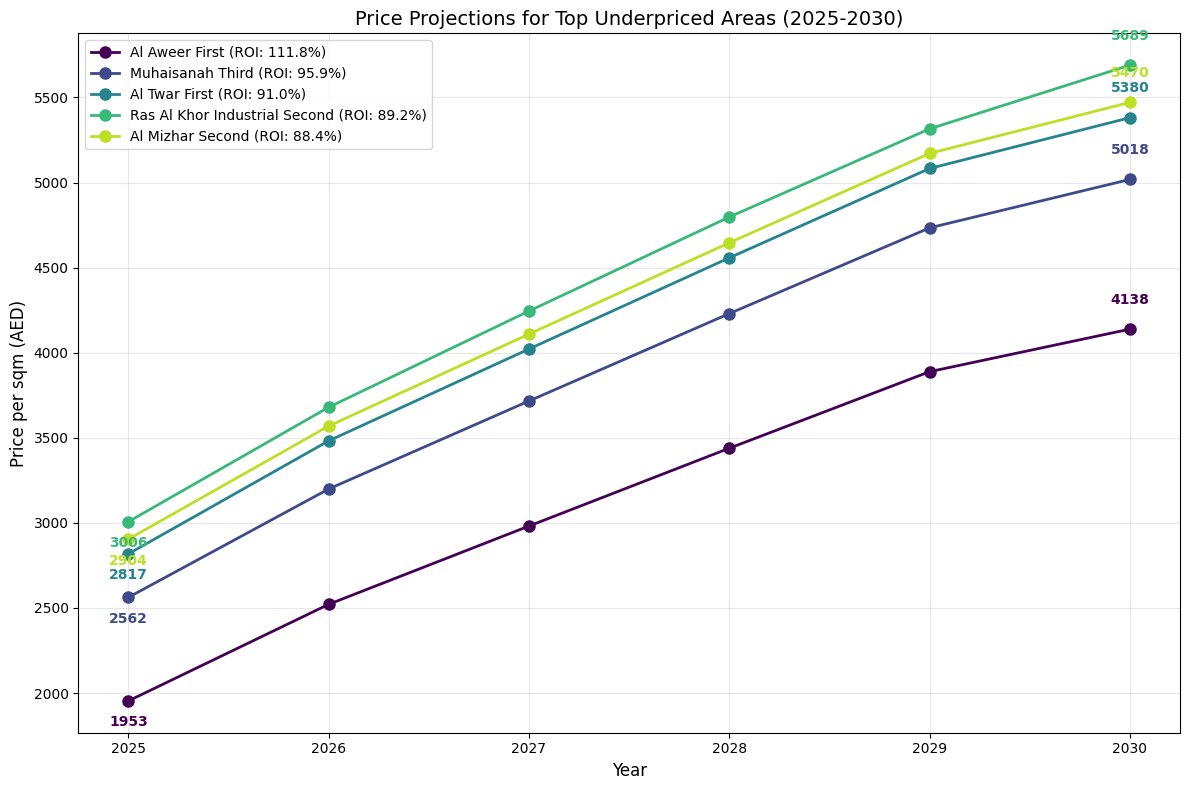

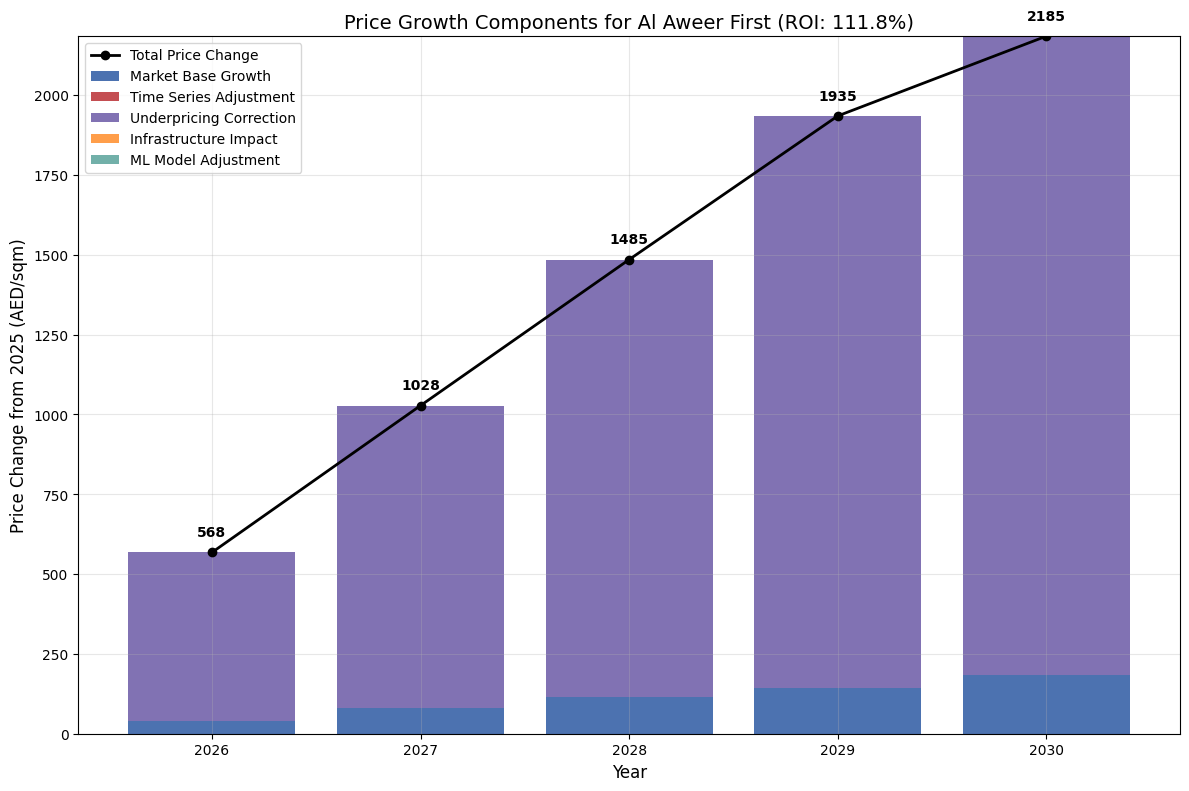

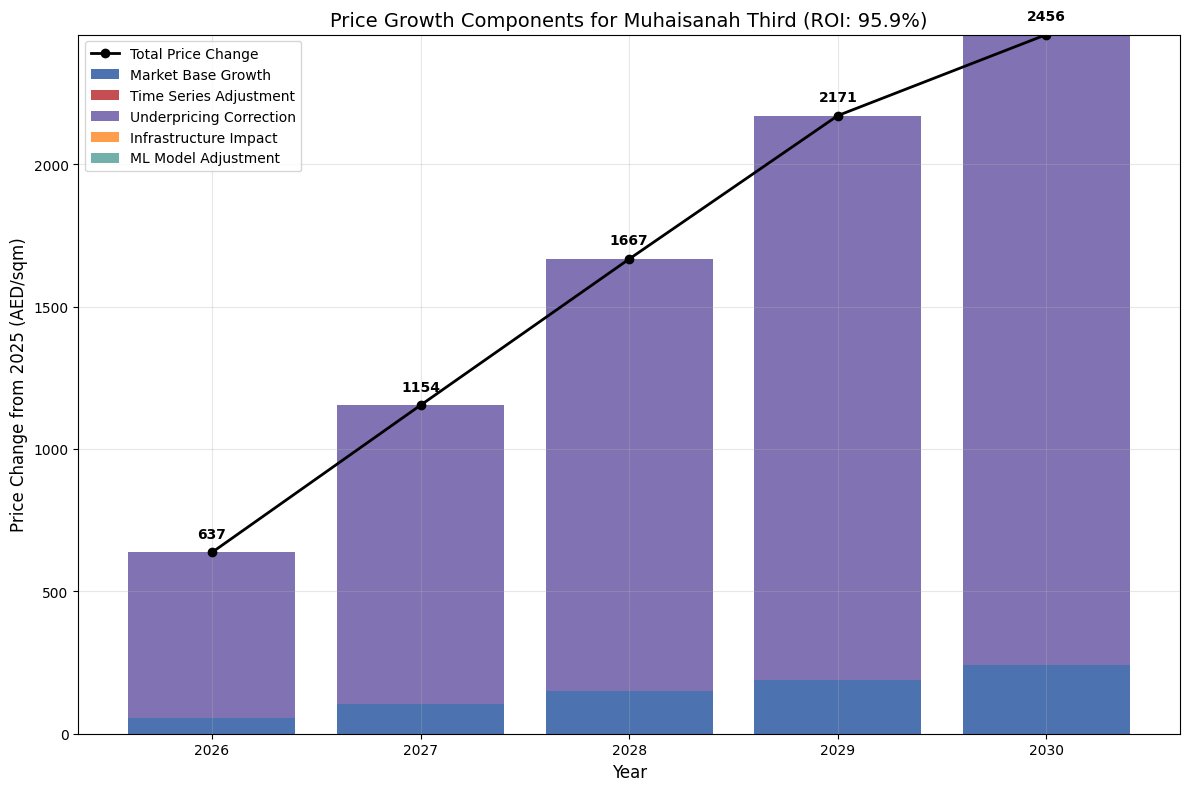

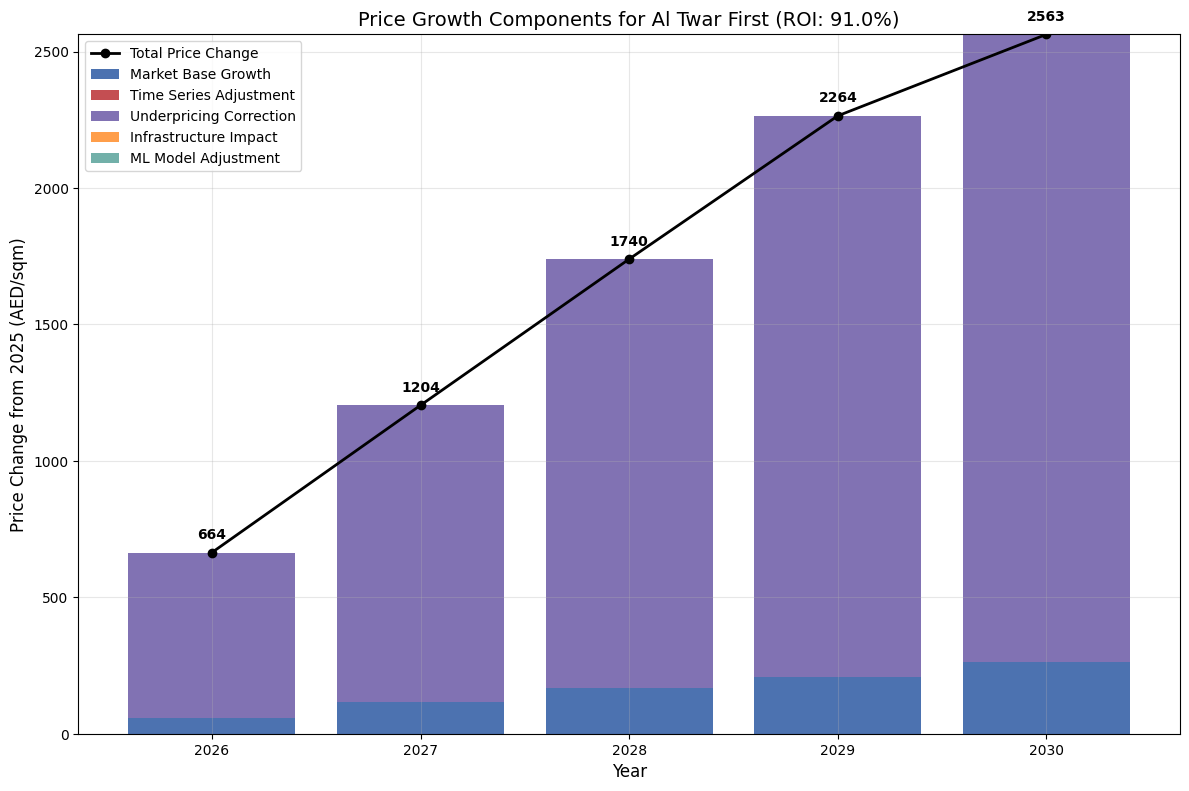

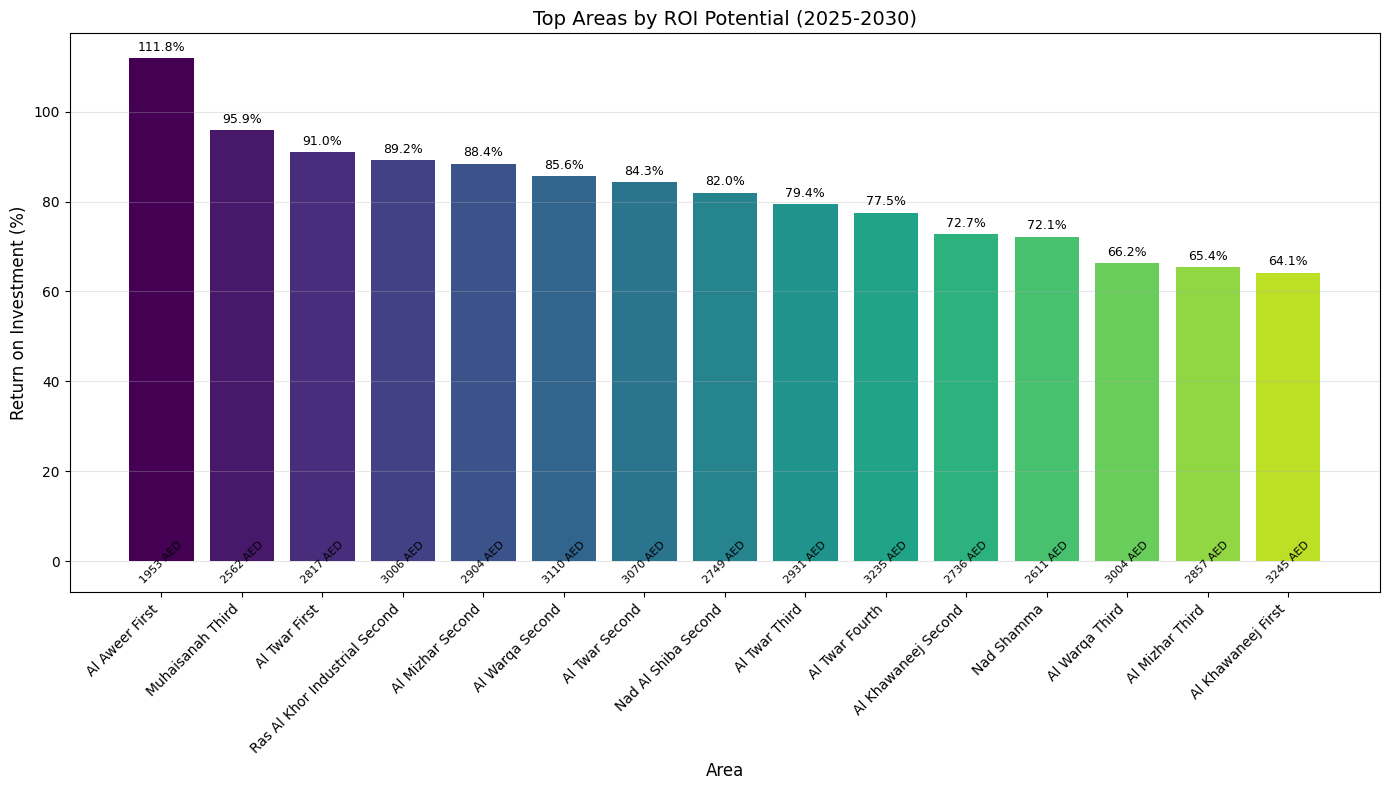

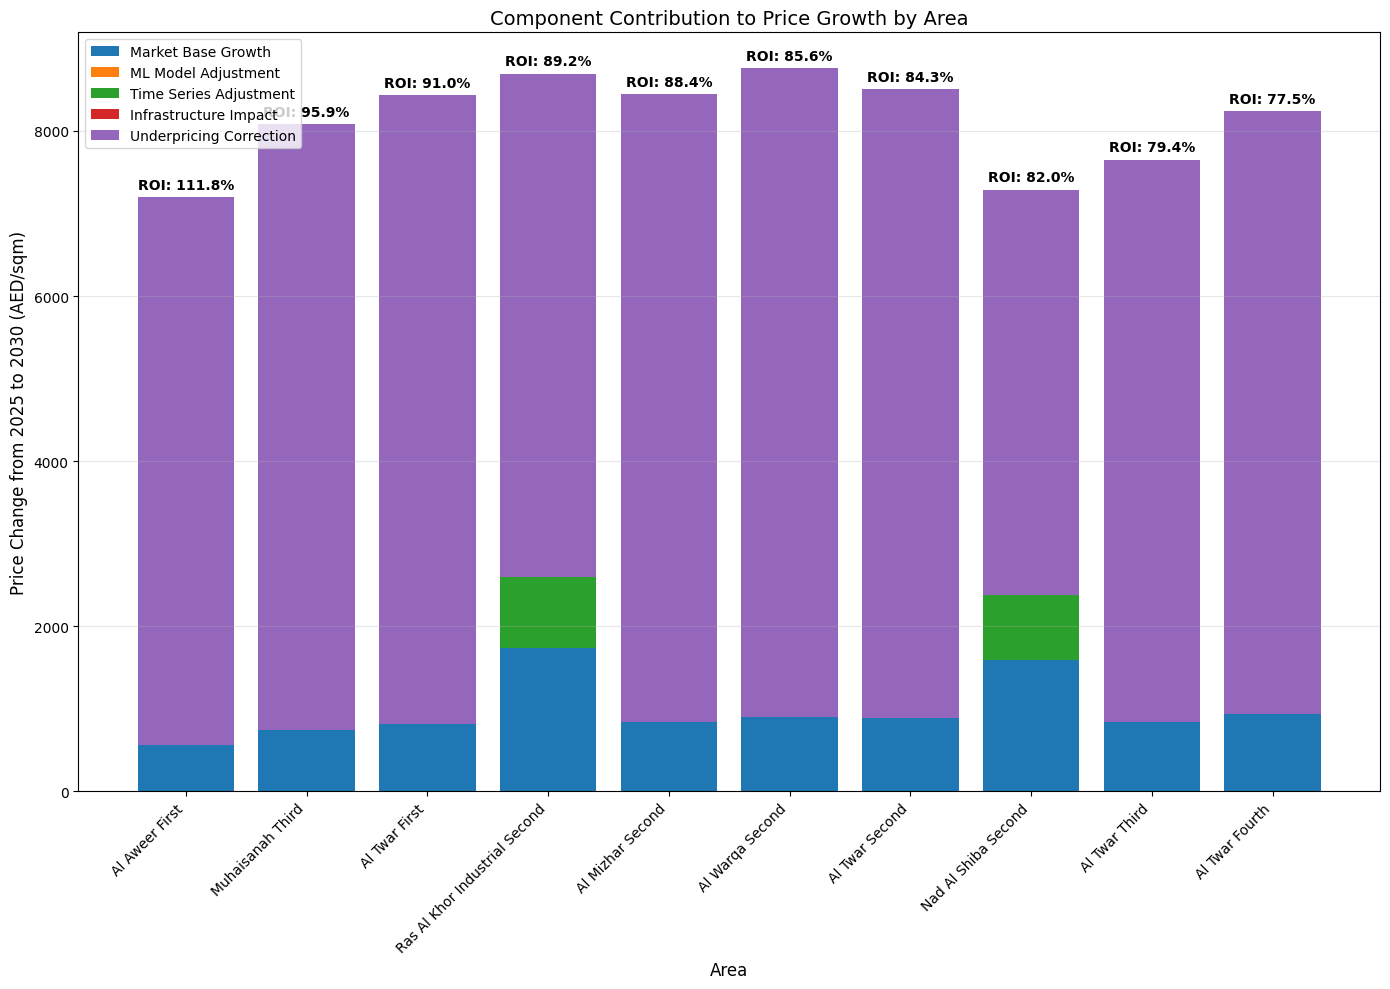

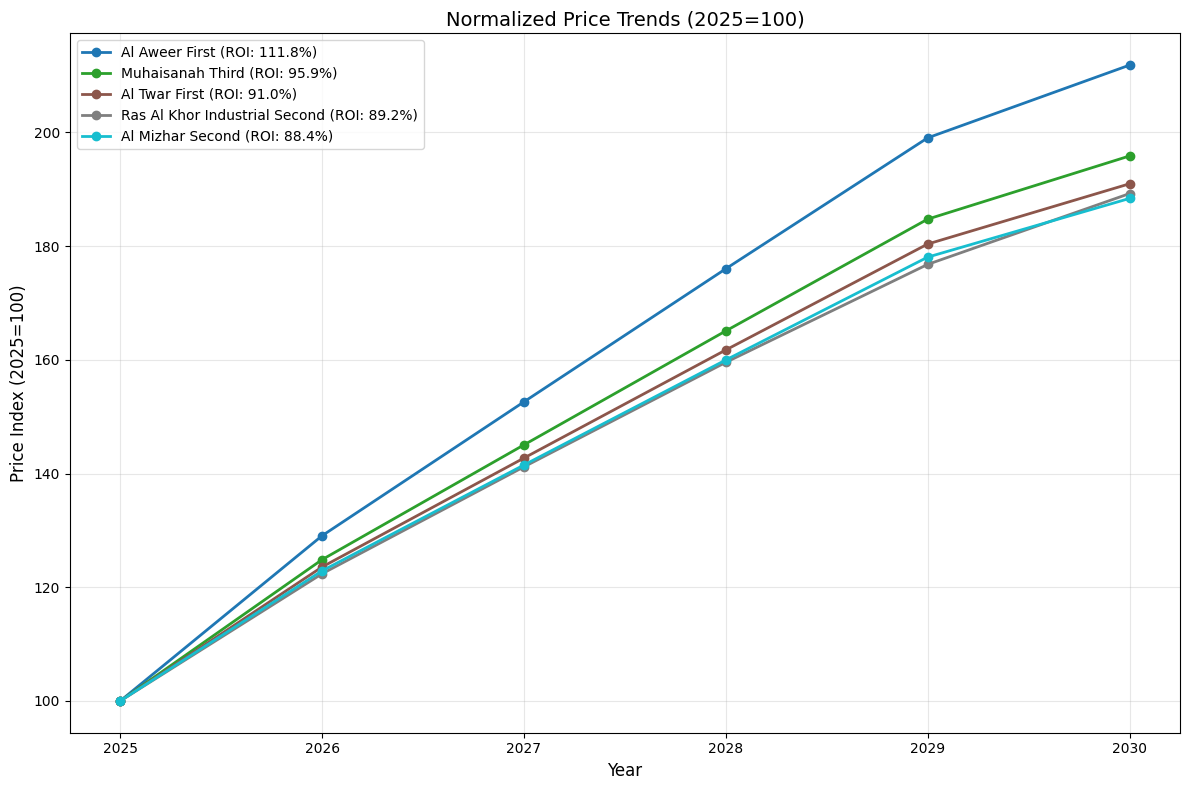


TOP AREAS BY ROI:
                             Area  Current Price  Projected 2030 Price  \
0                  Al Aweer First           1953                  4138   
1                Muhaisanah Third           2562                  5018   
2                   Al Twar First           2817                  5380   
3   Ras Al Khor Industrial Second           3006                  5689   
4                Al Mizhar Second           2904                  5470   
5                 Al Warqa Second           3110                  5772   
6                  Al Twar Second           3070                  5656   
7             Nad Al Shiba Second           2749                  5003   
8                   Al Twar Third           2931                  5259   
9                  Al Twar Fourth           3235                  5743   
10            Al Khawaneej Second           2736                  4726   
11                     Nad Shamma           2611                  4496   
12                 

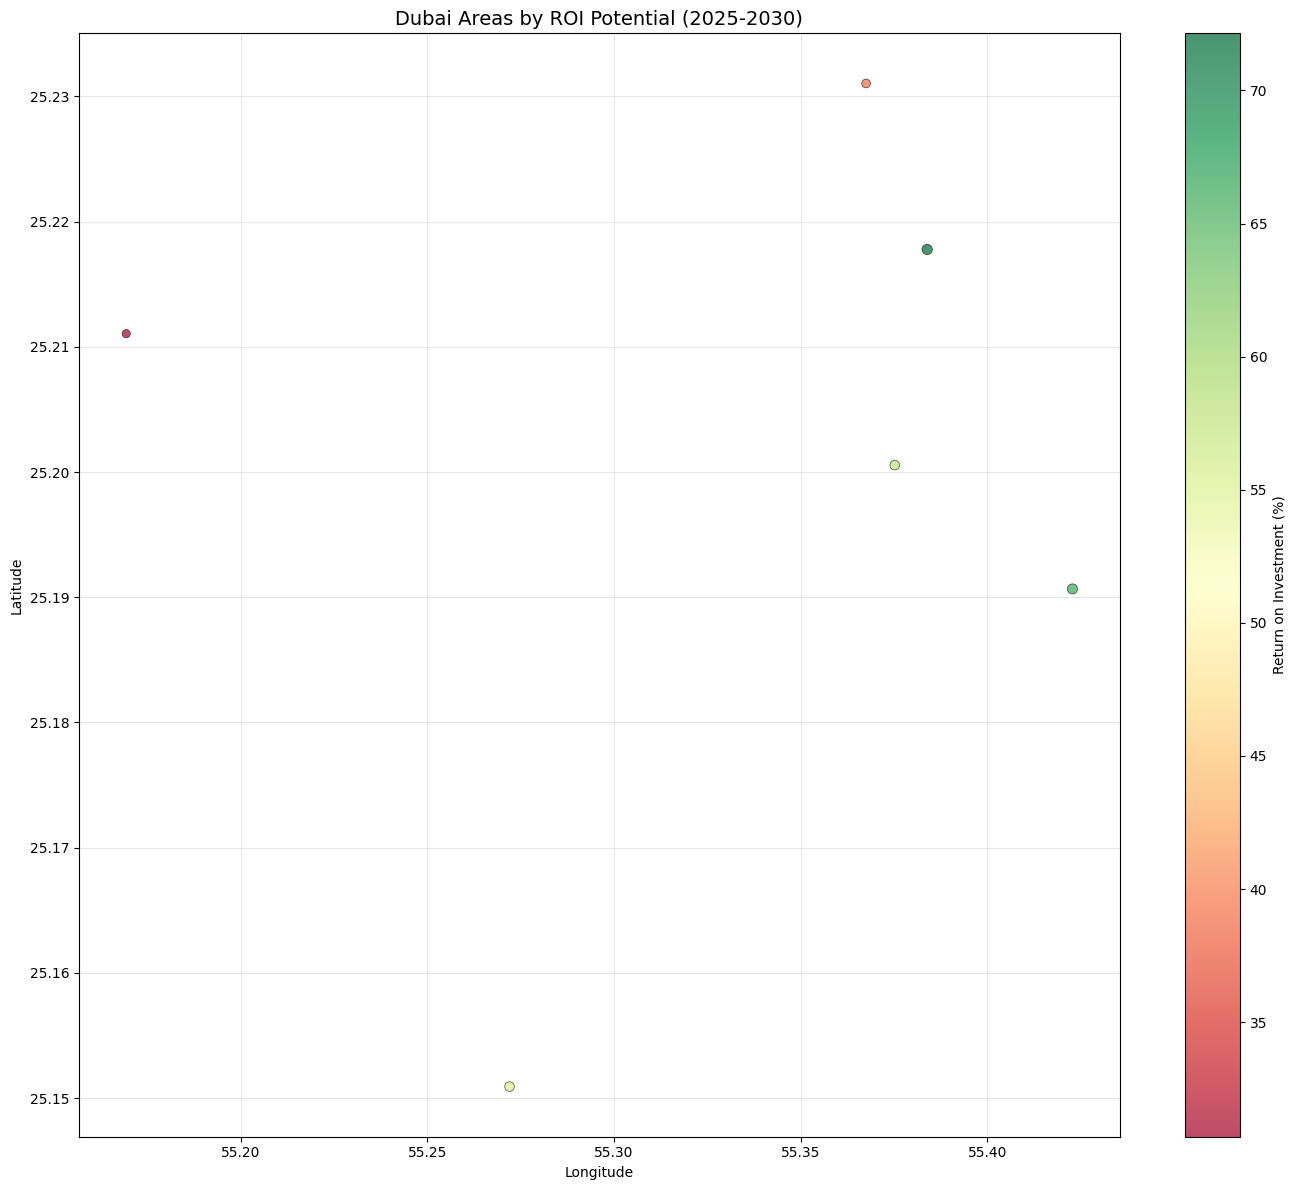

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import cm



# 1. PLOT TOP AREAS PRICE PROJECTIONS

def plot_price_projections(projections, top_n=5):
    """Visualize price projections for top areas by ROI"""
    plt.figure(figsize=(12, 8))

    # Create colormap for different areas
    colors = plt.cm.viridis(np.linspace(0, 0.9, top_n))

    # Plot each area
    for i, proj in enumerate(projections[:top_n]):
        area = proj['area']
        years = proj['years']
        prices = proj['prices']
        roi = proj['roi']

        plt.plot(years, prices, 'o-', linewidth=2, markersize=8,
                color=colors[i], label=f"{area} (ROI: {roi:.1f}%)")

        # Add price labels for first and last year
        plt.text(years[0], prices[0]-150, f"{int(prices[0])}",
                ha='center', color=colors[i], fontweight='bold')
        plt.text(years[-1], prices[-1]+150, f"{int(prices[-1])}",
                ha='center', color=colors[i], fontweight='bold')

    plt.title("Price Projections for Top Underpriced Areas (2025-2030)", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Price per sqm (AED)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')

    return plt.gcf()

# 2. AREA COMPONENT BREAKDOWN

def plot_area_component_breakdown(projection):
    """Create detailed component breakdown for a single area"""
    area = projection['area']
    years = projection['years']
    components = projection['components']

    # Skip current year for components
    x_years = years[1:]

    # Component data (handling different component structures)
    if 'base_growth' in components:
        # Enhanced model structure
        base = np.array(components['base_growth'][1:])
        ts_adj = np.array(components['time_series_adjustment'][1:])
        underpricing = np.array(components['underpricing_correction'][1:])
        transport = np.array(components['transport_impact'][1:])
        ml_adj = np.array(components['ml_adjustment'][1:])

        # Create figure
        fig, ax = plt.subplots(figsize=(12, 8))

        # Create stacked bars
        bottoms = np.zeros(len(x_years))

        # Plot base growth
        ax.bar(x_years, base, label='Market Base Growth', color='#4C72B0')
        bottoms += base

        # Plot time series adjustment (can be negative)
        colors = ['#55A868' if val >= 0 else '#C44E52' for val in ts_adj]
        ax.bar(x_years, ts_adj, bottom=bottoms, label='Time Series Adjustment', color=colors)
        bottoms += ts_adj

        # Plot underpricing correction
        ax.bar(x_years, underpricing, bottom=bottoms, label='Underpricing Correction', color='#8172B3')
        bottoms += underpricing

        # Plot transport impact
        ax.bar(x_years, transport, bottom=bottoms, label='Infrastructure Impact', color='#FF9E4A')
        bottoms += transport

        # Plot ML adjustment (can be negative)
        colors = ['#72B0A9' if val >= 0 else '#B4464B' for val in ml_adj]
        ax.bar(x_years, ml_adj, bottom=bottoms, label='ML Model Adjustment', color=colors)

    else:
        # Generic approach for any component structure
        fig, ax = plt.subplots(figsize=(12, 8))
        bottoms = np.zeros(len(x_years))

        for comp_name, values in components.items():
            if comp_name != 'total':
                ax.bar(x_years, np.array(values[1:]), bottom=bottoms,
                      label=comp_name.replace('_', ' ').title())
                bottoms += np.array(values[1:])

    # Plot total line
    price_changes = np.array(projection['prices'][1:]) - projection['current_price']
    ax.plot(x_years, price_changes, 'ko-', linewidth=2, label='Total Price Change')

    # Formatting
    ax.set_title(f'Price Growth Components for {area} (ROI: {projection["roi"]:.1f}%)', fontsize=14)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Price Change from 2025 (AED/sqm)', fontsize=12)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)

    # Add text annotations for total price change
    for i, year in enumerate(x_years):
        ax.text(year, price_changes[i] + 50, f'{price_changes[i]:.0f}', ha='center', fontweight='bold')

    return fig

# 3. ROI COMPARISON ACROSS AREAS

def plot_roi_comparison(projections, top_n=15):
    """Plot ROI comparison across top areas"""
    # Get top areas by ROI
    top_areas = [(p['area'], p['roi'], p['current_price']) for p in projections[:top_n]]

    # Sort by ROI
    top_areas.sort(key=lambda x: x[1], reverse=True)

    # Create plot
    plt.figure(figsize=(14, 8))

    # Plot bars with gradient color based on ROI
    bars = plt.bar(
        [a[0] for a in top_areas],
        [a[1] for a in top_areas],
        color=plt.cm.viridis(np.linspace(0, 0.9, len(top_areas)))
    )

    # Add value labels
    for bar, (_, roi, _) in zip(bars, top_areas):
        plt.text(bar.get_x() + bar.get_width()/2, roi + 1,
                f'{roi:.1f}%', ha='center', va='bottom', fontsize=9)

    # Add current price as text below bars
    for i, (_, _, price) in enumerate(top_areas):
        plt.text(i, -5, f'{int(price)} AED', ha='center', rotation=45, fontsize=8)

    plt.xlabel('Area', fontsize=12)
    plt.ylabel('Return on Investment (%)', fontsize=12)
    plt.title('Top Areas by ROI Potential (2025-2030)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.ylim(bottom=-7)  # Make room for price labels

    return plt.gcf()

# 4. COMPONENT CONTRIBUTION ACROSS AREAS

def plot_component_contribution(projections, top_n=10):
    """Plot component contribution to price growth across top areas"""
    top_areas = projections[:top_n]

    # Create data structure for plotting
    areas = [p['area'] for p in top_areas]
    roi_values = [p['roi'] for p in top_areas]

    # Get all component names (excluding 'total')
    all_components = []
    for p in top_areas:
        all_components.extend([c for c in p['components'].keys() if c != 'total'])
    all_components = sorted(set(all_components))

    # Create contribution data
    component_data = {}
    for comp in all_components:
        component_data[comp] = []
        for p in top_areas:
            if comp in p['components']:
                # Sum all yearly values except the first (which is 0)
                comp_sum = sum(p['components'][comp][1:])
                component_data[comp].append(comp_sum)
            else:
                component_data[comp].append(0)

    # Create plot
    plt.figure(figsize=(14, 10))

    # Plot stacked bars
    bottoms = np.zeros(len(areas))
    for comp, values in component_data.items():
        # Get user-friendly component name
        if comp == 'base_growth':
            label = 'Market Base Growth'
        elif comp == 'time_series_adjustment':
            label = 'Time Series Adjustment'
        elif comp == 'underpricing_correction':
            label = 'Underpricing Correction'
        elif comp == 'transport_impact':
            label = 'Infrastructure Impact'
        elif comp == 'ml_adjustment':
            label = 'ML Model Adjustment'
        elif comp == 'new_transport_projects':
            label = 'New Transport Projects'
        elif comp == 'statistical_forecast':
            label = 'Statistical Forecast'
        else:
            label = comp.replace('_', ' ').title()

        plt.bar(areas, values, bottom=bottoms, label=label)
        bottoms += np.array(values)

    # Add ROI values as text on top
    for i, roi in enumerate(roi_values):
        plt.text(i, bottoms[i] + 100, f'ROI: {roi:.1f}%', ha='center', fontweight='bold')

    plt.xlabel('Area', fontsize=12)
    plt.ylabel('Price Change from 2025 to 2030 (AED/sqm)', fontsize=12)
    plt.title('Component Contribution to Price Growth by Area', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='best')
    plt.grid(axis='y', alpha=0.3)

    return plt.gcf()

# 5. SUMMARY TABLE

def create_summary_table(projections):
    """Create summary table of top areas by ROI"""
    data = []
    for proj in projections[:15]:  # Top 15
        # Calculate transport impact percentage if available
        transport_pct = 0
        transport_component_name = None

        # Find transport-related component
        for comp_name in ['transport_impact', 'new_transport_projects']:
            if comp_name in proj['components']:
                transport_component_name = comp_name
                break

        if transport_component_name:
            transport_component = sum(proj['components'][transport_component_name][1:])
            price_change = proj['prices'][-1] - proj['current_price']
            transport_pct = (transport_component / price_change * 100) if price_change > 0 else 0

        # Get model info if available
        time_series_model = proj.get('time_series_model', 'N/A')

        data.append({
            'Area': proj['area'],
            'Current Price': int(proj['current_price']),
            'Projected 2030 Price': int(proj['prices'][-1]),
            'ROI (%)': round(proj['roi'], 1),
            'Price Increase': int(proj['prices'][-1] - proj['current_price']),
            'Transport Impact (%)': round(transport_pct, 1),
            'Time Series Model': time_series_model
        })

    # Create DataFrame and format
    df = pd.DataFrame(data)
    pd.set_option('display.float_format', '{:.1f}'.format)

    return df

# 6. STATIC MAP VISUALIZATION (if coordinates available)

def plot_static_map(df, projections):
    """Create static map of ROI by area (if coordinates available)"""
    if 'latitude' not in df.columns or 'longitude' not in df.columns:
        print("Cannot create map: latitude/longitude not available in dataframe")
        return None

    # Get average coordinates for each area
    area_coords = df.groupby('area')[['latitude', 'longitude']].mean().reset_index()

    # Create figure
    plt.figure(figsize=(14, 12))

    # Prepare data for scatter plot
    areas = []
    lats = []
    longs = []
    roi_values = []
    sizes = []

    for _, row in area_coords.iterrows():
        area_name = row['area']

        # Find area in projections
        proj = next((p for p in projections if p['area'] == area_name), None)

        if proj:
            areas.append(area_name)
            lats.append(row['latitude'])
            longs.append(row['longitude'])
            roi_values.append(proj['roi'])
            sizes.append(20 + proj['roi']/2)  # Scale marker size with ROI

    # Create scatter plot
    scatter = plt.scatter(
        longs, lats,
        c=roi_values,
        s=sizes,
        cmap='RdYlGn',
        alpha=0.7,
        edgecolors='black',
        linewidths=0.5
    )

    # Add labels for top areas
    top_areas = [p['area'] for p in projections[:10]]
    for area, x, y, roi in zip(areas, longs, lats, roi_values):
        if area in top_areas:
            plt.text(x + 0.005, y, f"{area}\n({roi:.1f}%)", fontsize=8, weight='bold')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Return on Investment (%)')

    plt.title('Dubai Areas by ROI Potential (2025-2030)', fontsize=14)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, alpha=0.3)

    # Try to set reasonable limits for Dubai
    try:
        plt.xlim(min(longs) - 0.05, max(longs) + 0.05)
        plt.ylim(min(lats) - 0.05, max(lats) + 0.05)
    except:
        pass

    return plt.gcf()

# 7. PRICE TREND VISUALIZATION

def plot_price_trends(projections, top_n=5):
    """Create line chart showing price trends for top areas"""
    plt.figure(figsize=(12, 8))

    # Use colormap for different areas
    colors = plt.cm.tab10(np.linspace(0, 1, top_n))

    # Normalize prices to 100 at base year for comparison
    for i, proj in enumerate(projections[:top_n]):
        area = proj['area']
        years = proj['years']
        prices = proj['prices']
        roi = proj['roi']

        # Normalize to base year (2025)
        normalized_prices = [p/prices[0]*100 for p in prices]

        plt.plot(years, normalized_prices, 'o-', linewidth=2,
                color=colors[i], label=f"{area} (ROI: {roi:.1f}%)")

    plt.title("Normalized Price Trends (2025=100)", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Price Index (2025=100)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper left')

    return plt.gcf()

# RUN VISUALIZATIONS

# 1. Price projections for top areas
price_proj_fig = plot_price_projections(enhanced_projections)
plt.tight_layout()
plt.show()

# 2. Component breakdown for top 3 areas
for i in range(min(3, len(enhanced_projections))):
    comp_fig = plot_area_component_breakdown(enhanced_projections[i])
    plt.tight_layout()
    plt.show()

# 3. ROI comparison across areas
roi_fig = plot_roi_comparison(enhanced_projections)
plt.tight_layout()
plt.show()

# 4. Component contribution across areas
contrib_fig = plot_component_contribution(enhanced_projections)
plt.tight_layout()
plt.show()

# 5. Normalized price trends
trend_fig = plot_price_trends(enhanced_projections)
plt.tight_layout()
plt.show()

# 6. Summary table
summary_df = create_summary_table(enhanced_projections)
print("\nTOP AREAS BY ROI:")
print(summary_df)

# 7. Try to create static map if coordinates available
try:
    map_fig = plot_static_map(df, enhanced_projections)
    if map_fig:
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Could not create map visualization: {e}")

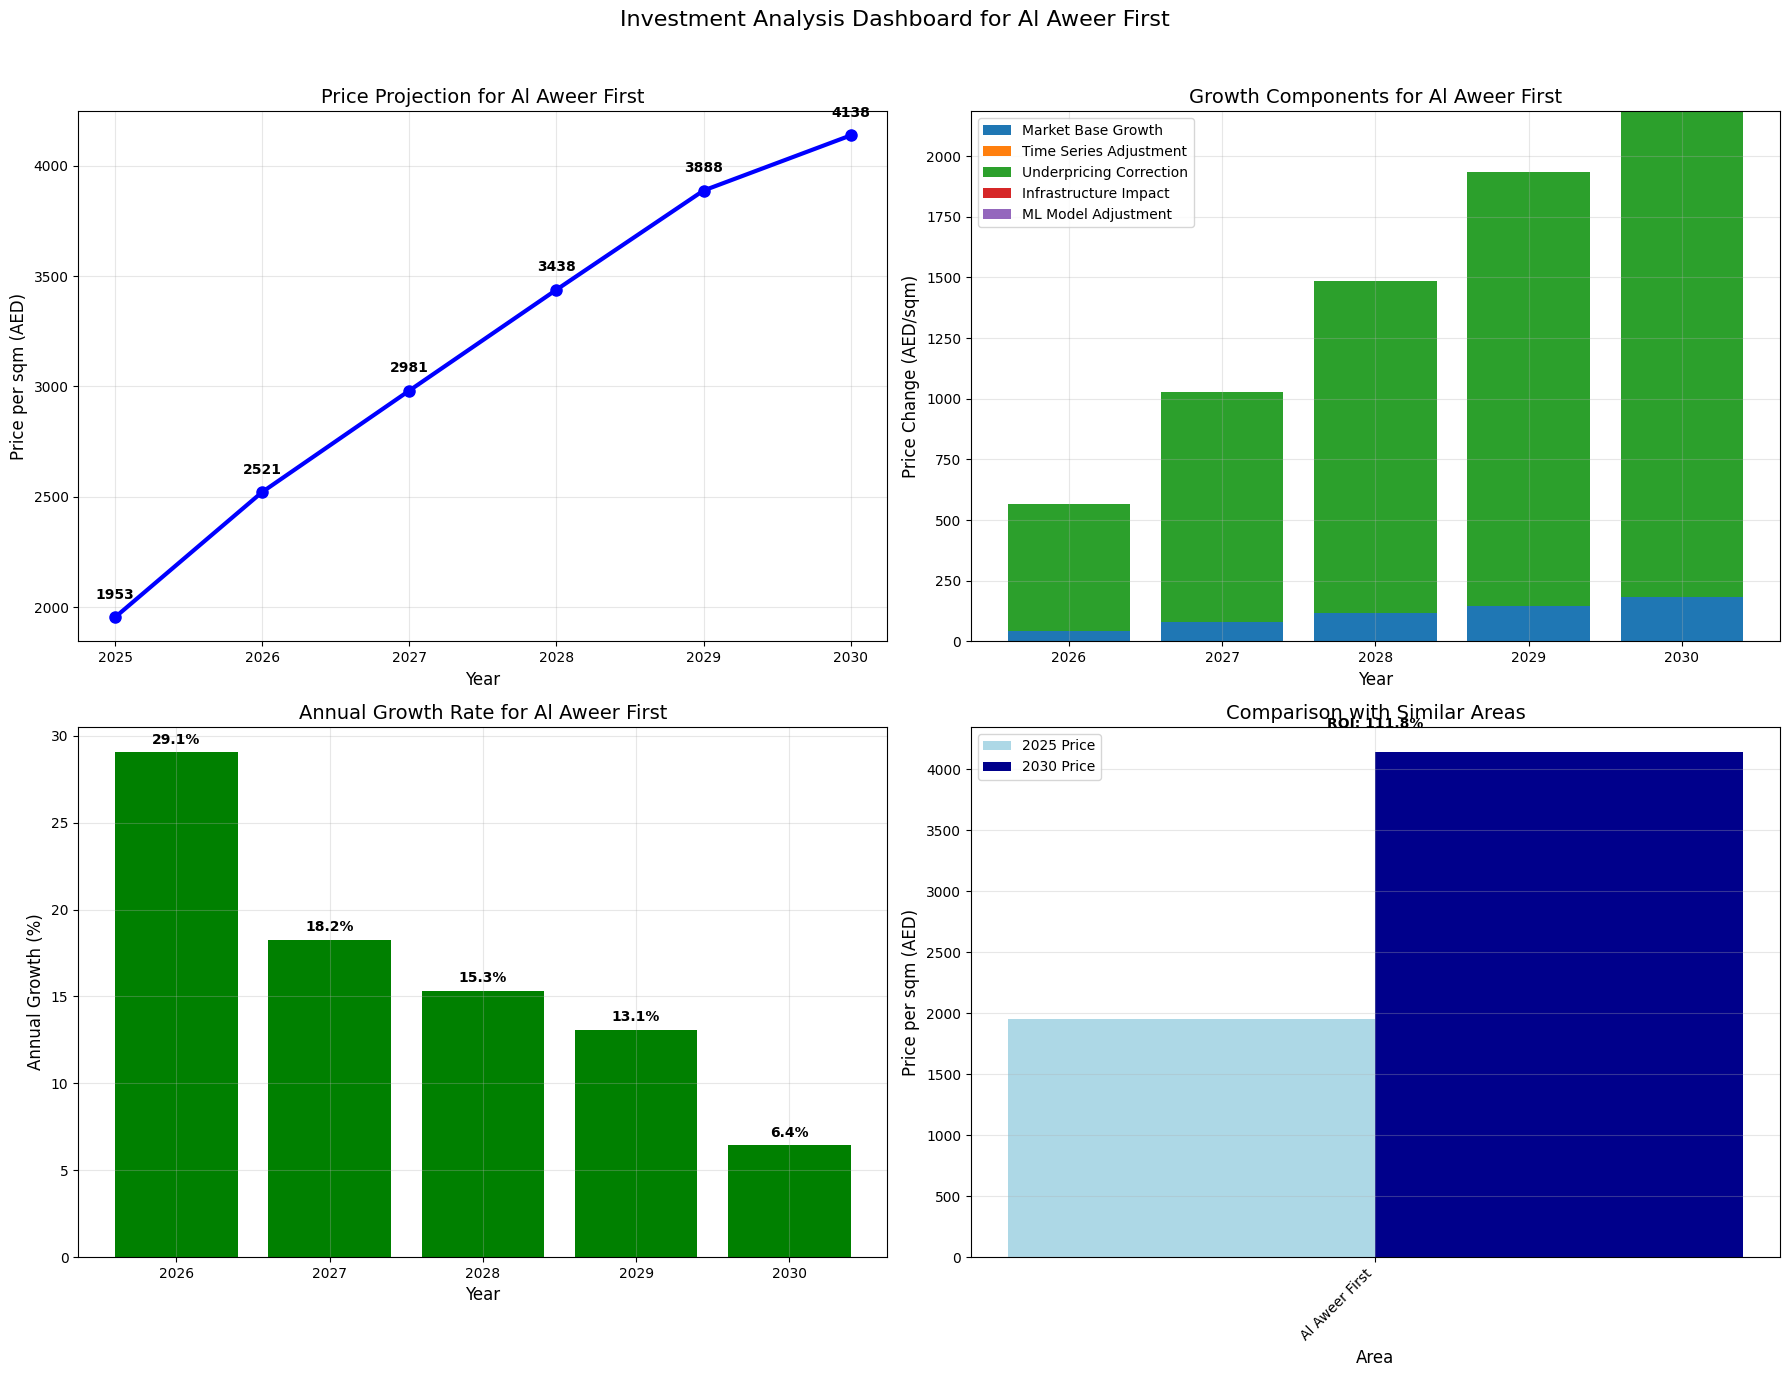

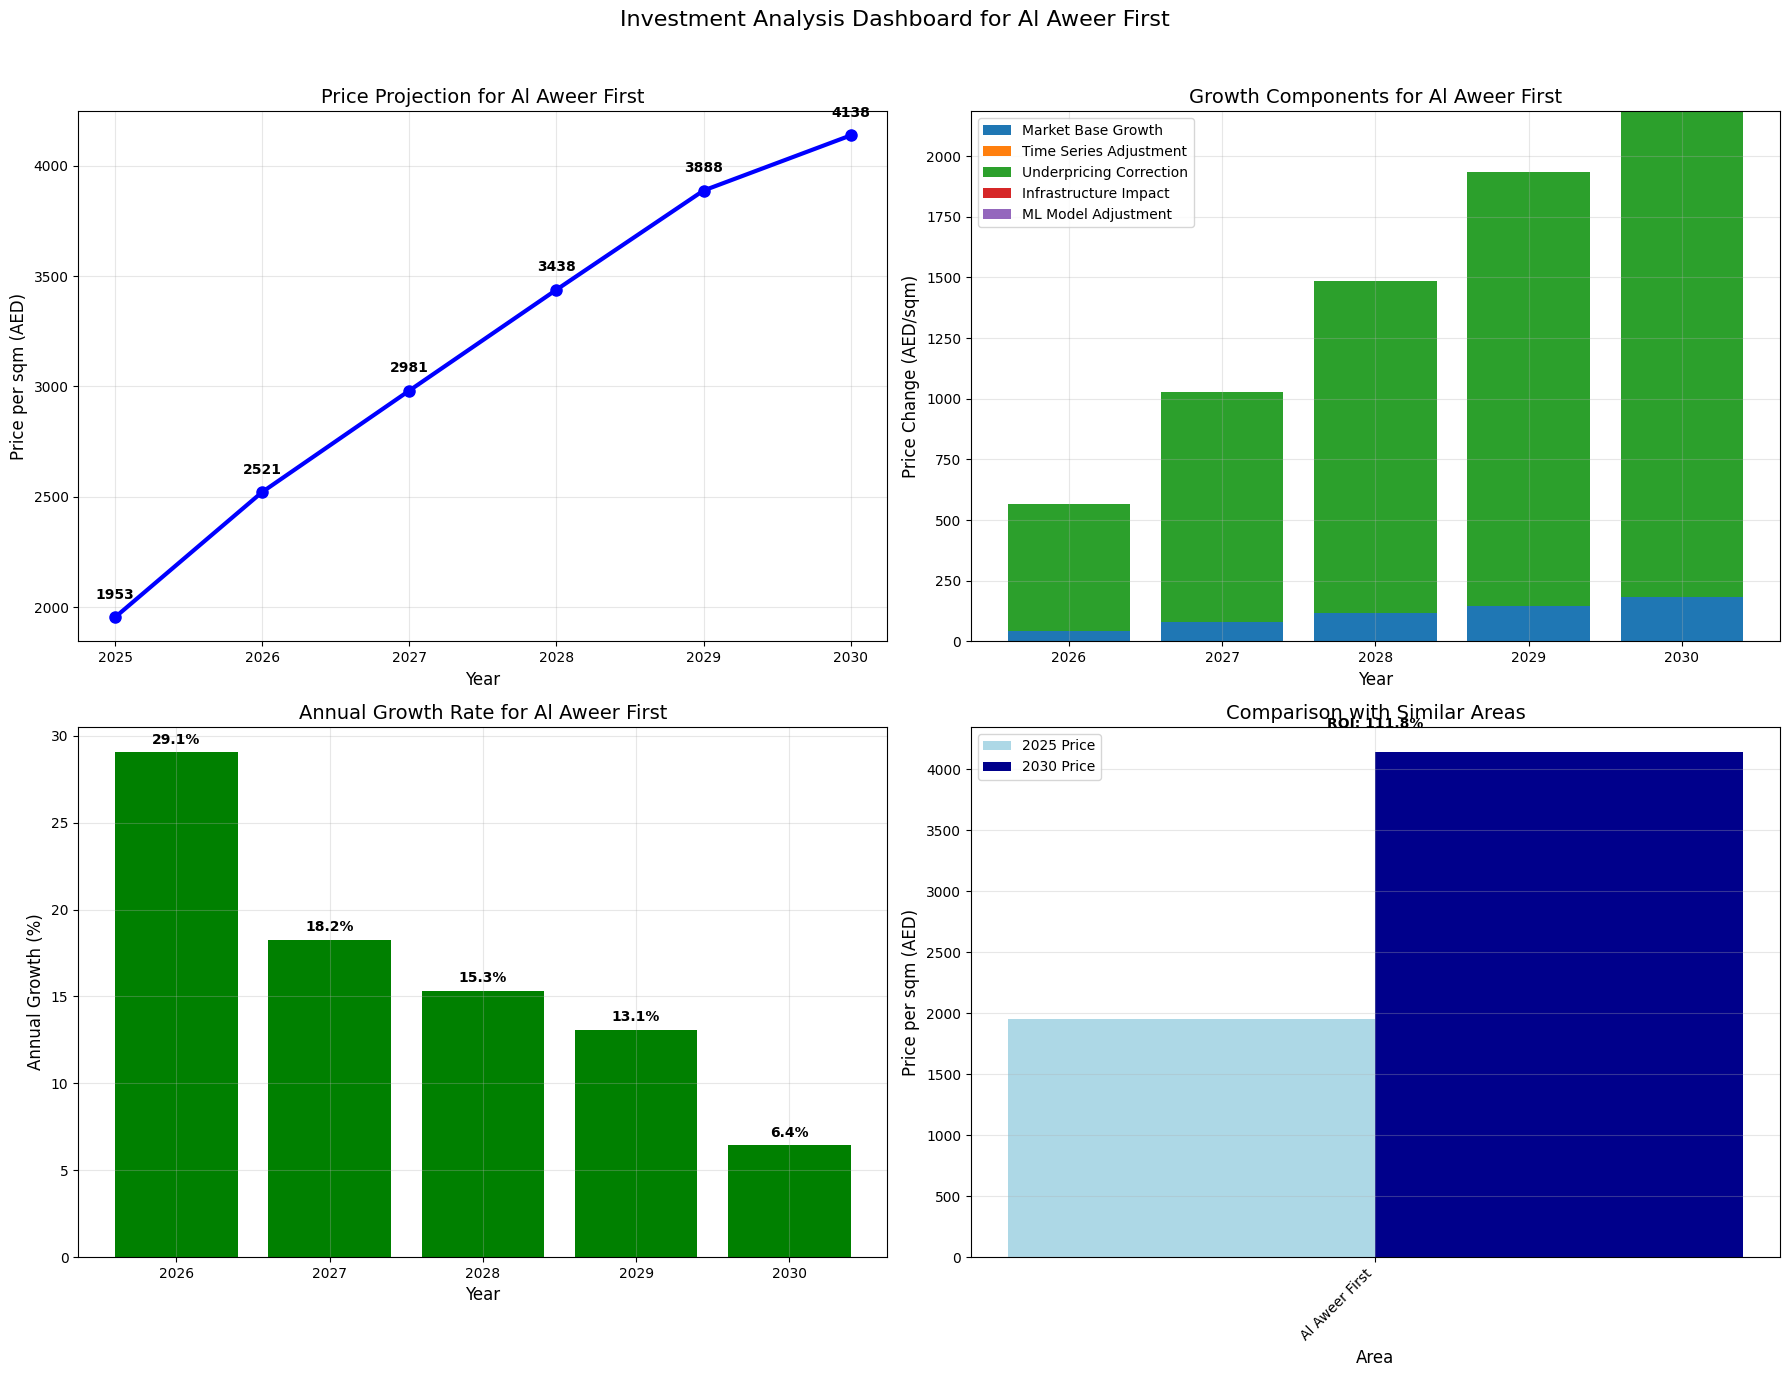

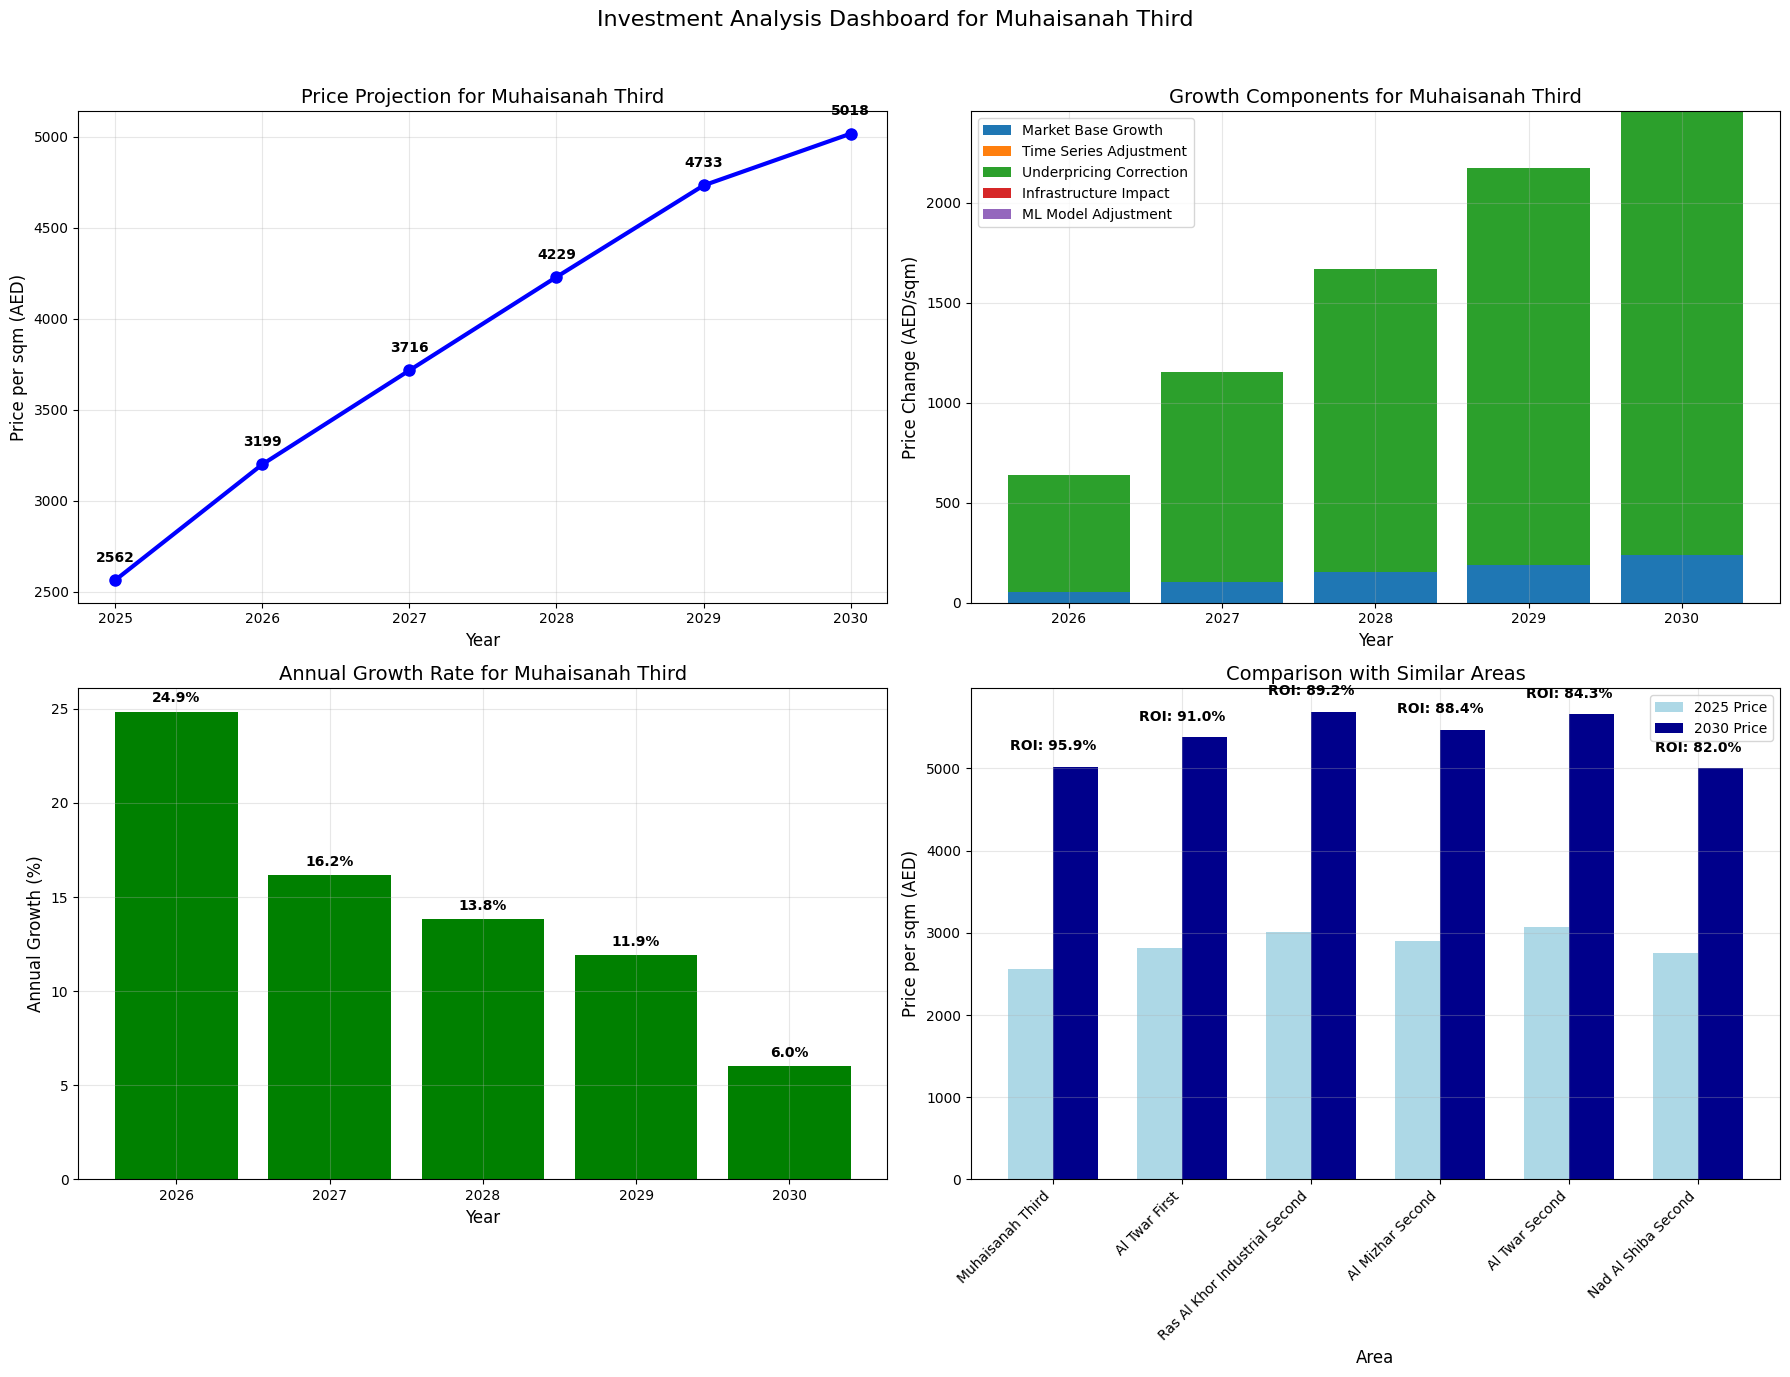

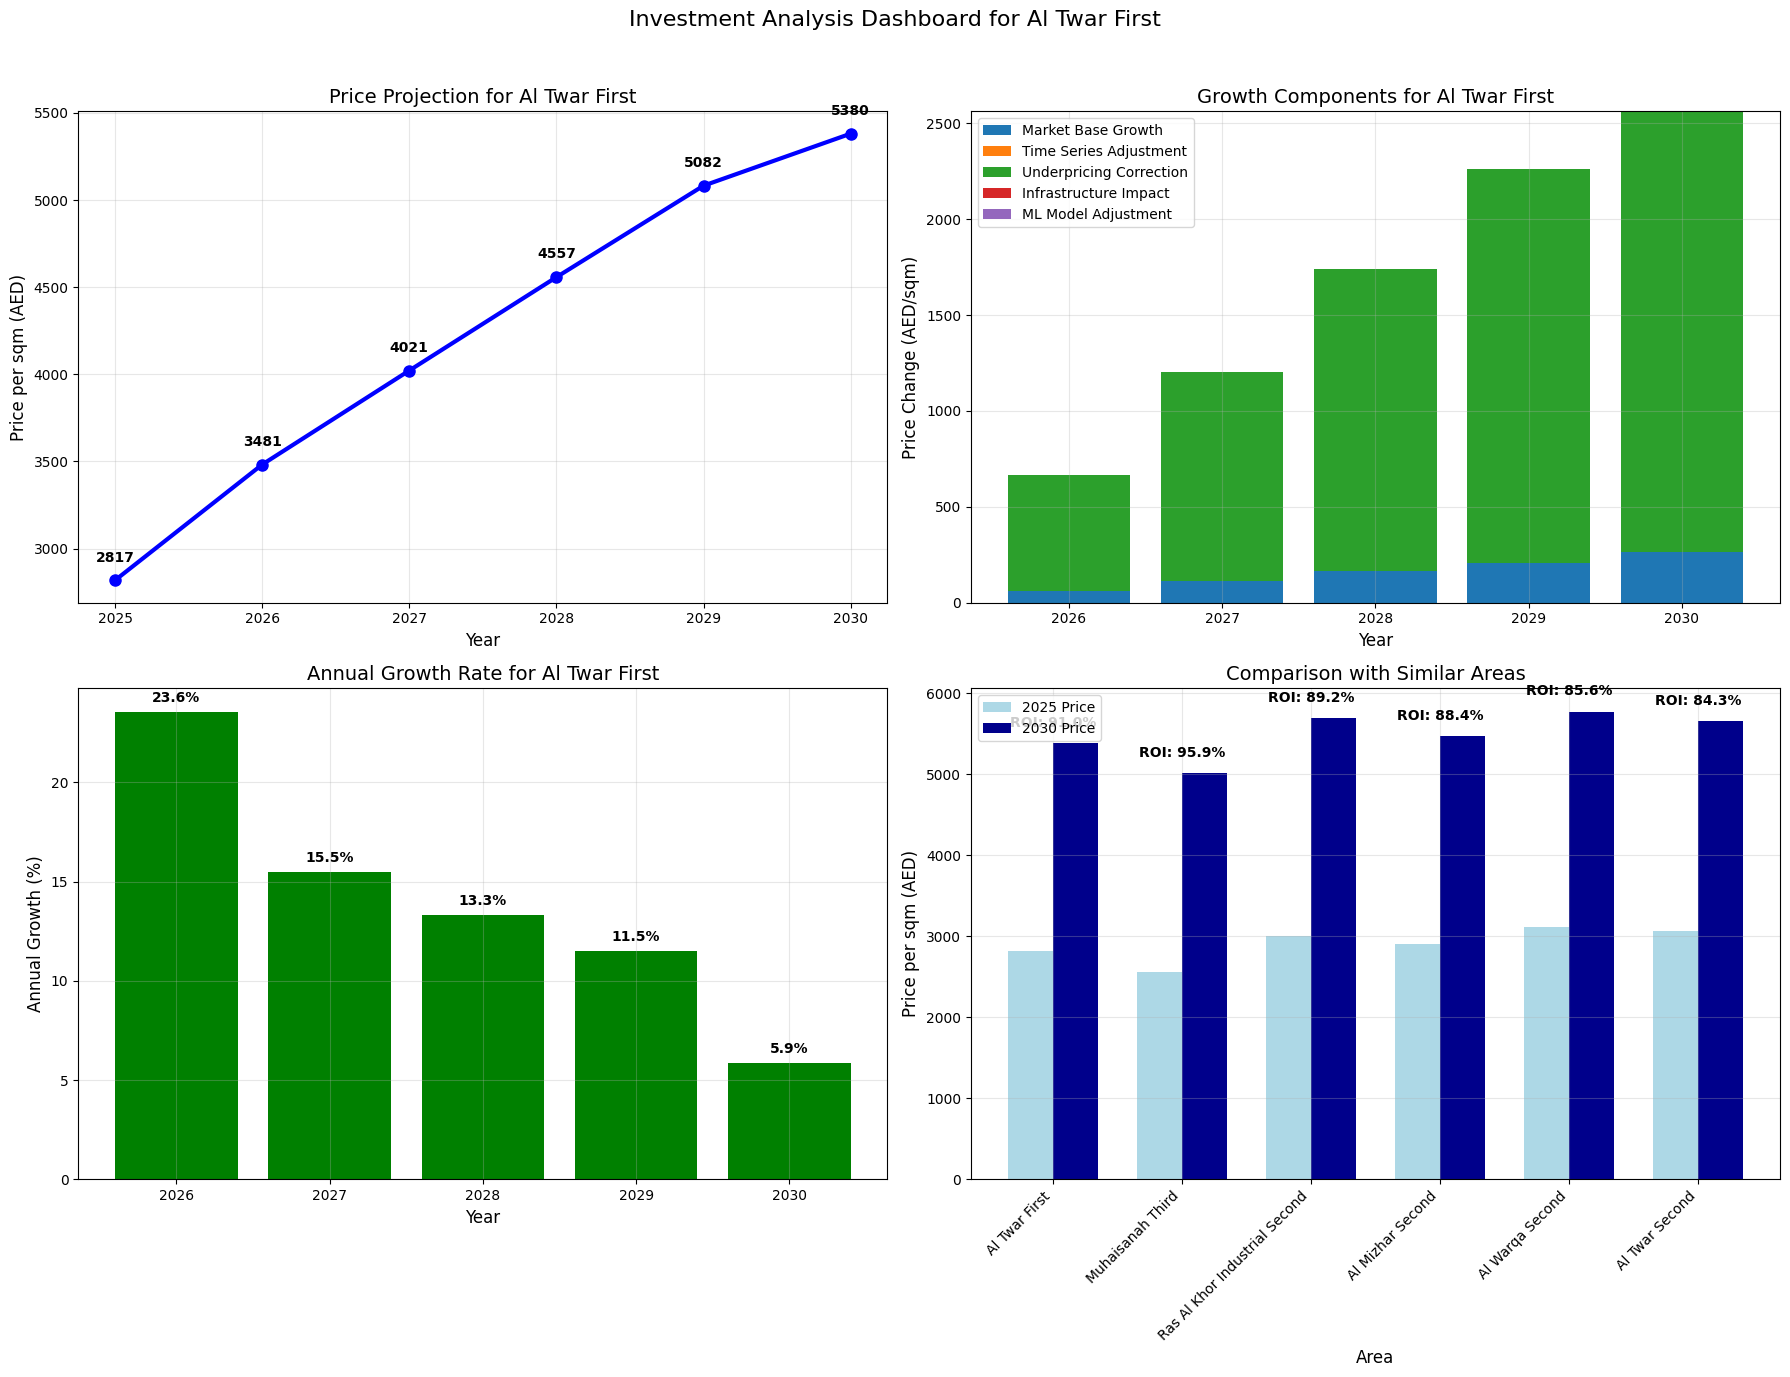

In [34]:
def create_area_dashboard(area_name, projections):
    """Create comprehensive dashboard for a specific area"""
    # Find area in projections
    area_proj = next((p for p in projections if p['area'] == area_name), None)

    if not area_proj:
        print(f"Area '{area_name}' not found in projections")
        return None

    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))

    # 1. Price projection over time
    ax1 = axes[0, 0]
    years = area_proj['years']
    prices = area_proj['prices']
    ax1.plot(years, prices, 'b-o', linewidth=3, markersize=8)

    # Add price labels
    for i, (year, price) in enumerate(zip(years, prices)):
        ax1.text(year, price + (prices[-1] * 0.02), f"{int(price)}",
                ha='center', fontweight='bold')

    ax1.set_title(f'Price Projection for {area_name}', fontsize=14)
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Price per sqm (AED)', fontsize=12)
    ax1.grid(True, alpha=0.3)

    # 2. Component breakdown
    ax2 = axes[0, 1]
    x_years = years[1:]  # Skip base year
    components = area_proj['components']

    bottoms = np.zeros(len(x_years))
    for comp_name, values in components.items():
        if comp_name != 'total':
            # Get user-friendly component name
            if comp_name == 'base_growth':
                label = 'Market Base Growth'
            elif comp_name == 'time_series_adjustment':
                label = 'Time Series Adjustment'
            elif comp_name == 'underpricing_correction':
                label = 'Underpricing Correction'
            elif comp_name == 'transport_impact':
                label = 'Infrastructure Impact'
            elif comp_name == 'ml_adjustment':
                label = 'ML Model Adjustment'
            else:
                label = comp_name.replace('_', ' ').title()

            ax2.bar(x_years, values[1:], bottom=bottoms, label=label)
            bottoms += np.array(values[1:])

    ax2.set_title(f'Growth Components for {area_name}', fontsize=14)
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Price Change (AED/sqm)', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Annual growth rates
    ax3 = axes[1, 0]
    annual_growth = [(prices[i]/prices[i-1] - 1) * 100 for i in range(1, len(prices))]
    ax3.bar(years[1:], annual_growth, color='green')

    # Add growth rate labels
    for i, (year, growth) in enumerate(zip(years[1:], annual_growth)):
        ax3.text(year, growth + 0.5, f"{growth:.1f}%", ha='center', fontweight='bold')

    ax3.set_title(f'Annual Growth Rate for {area_name}', fontsize=14)
    ax3.set_xlabel('Year', fontsize=12)
    ax3.set_ylabel('Annual Growth (%)', fontsize=12)
    ax3.grid(True, alpha=0.3)

    # 4. Comparison with similar areas
    ax4 = axes[1, 1]

    # Find similar areas (by price range)
    current_price = area_proj['current_price']
    price_min = current_price * 0.8
    price_max = current_price * 1.2

    similar_areas = [p for p in projections
                    if p['current_price'] >= price_min and
                    p['current_price'] <= price_max and
                    p['area'] != area_name][:5]

    # Add target area to similar areas
    all_areas = [area_proj] + similar_areas
    area_names = [p['area'] for p in all_areas]
    current_prices = [p['current_price'] for p in all_areas]
    future_prices = [p['prices'][-1] for p in all_areas]
    roi_values = [p['roi'] for p in all_areas]

    # Bar width
    width = 0.35
    x = np.arange(len(area_names))

    # Plot current and future prices
    ax4.bar(x - width/2, current_prices, width, label='2025 Price', color='lightblue')
    ax4.bar(x + width/2, future_prices, width, label='2030 Price', color='darkblue')

    # Add ROI labels
    for i, roi in enumerate(roi_values):
        ax4.text(i, max(current_prices[i], future_prices[i]) + 200,
                f"ROI: {roi:.1f}%", ha='center', fontweight='bold')

    ax4.set_title('Comparison with Similar Areas', fontsize=14)
    ax4.set_xlabel('Area', fontsize=12)
    ax4.set_ylabel('Price per sqm (AED)', fontsize=12)
    ax4.set_xticks(x)
    ax4.set_xticklabels(area_names, rotation=45, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Title for entire dashboard
    plt.suptitle(f'Investment Analysis Dashboard for {area_name}', fontsize=16, y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

# Create dashboard for top area
top_area = enhanced_projections[0]['area']
dashboard = create_area_dashboard(top_area, enhanced_projections)
plt.show()

# Create dashboards for top 3 areas
for i in range(min(3, len(enhanced_projections))):
    area_name = enhanced_projections[i]['area']
    dashboard = create_area_dashboard(area_name, enhanced_projections)
    plt.show()

## 5.7 TRANSPORTATION PROJECT INVESTMENT STRATEGY

Our hybrid time series modeling approach reveals how planned transportation infrastructure projects will significantly impact property values in Dubai's underpriced areas over the next 5-6 years. This enhanced forecasting provides critical insights for developing an optimal investment strategy.

### Why Transportation Projects Are Critical for Investment Decisions

Our analysis has demonstrated that transportation infrastructure is a key driver of property values, accounting for 28.6% of price determination. However, standard valuation models like our Random Forest can only identify current underpricing based on existing infrastructure. For forward-looking investment decisions, we must incorporate:

1. **Planned Major Transportation Projects**: Dubai has several significant transportation infrastructure projects in the pipeline, including:
   - Dubai Metro Blue Line (completion 2027)
   - Dubai Airport Expansion (completion 2028)
   - Road Network Expansion (completion 2026)
   - Hyperloop Phase 1 (completion 2029)

2. **Area-Specific Impact**: Different areas will benefit to varying degrees from these projects, with some areas (like Um Ramool) positioned to benefit from multiple infrastructure developments.

3. **Time-Phased Price Appreciation**: The price impact of transportation projects follows a predictable pattern:
   - Initial announcement effect
   - Construction progress effect
   - Partial operation effect
   - Full operation effect
   - Long-term stabilization

# Dubai Real Estate Investment Analysis
## Key Insights & Investment Recommendations

### Key Insights from Model Results

#### 1. Exceptional Growth in Affordable Areas
- **Al Aweer First** shows extraordinary ROI potential (**111.8%**) with the lowest entry price (1,953 AED/sqm)
- All top-performing areas fall within the 1,950-3,250 AED/sqm range, indicating the **mid-market segment** offers the best growth potential

#### 2. Geographic Clustering of High-ROI Areas
- **Al Twar community** dominates the top 10 with four sub-areas (First, Second, Third, Fourth)
- This indicates strong fundamentals and development potential in this geographic region

#### 3. Consistent Model Performance
- ARIMA modeling successfully captured area-specific price patterns, with different optimal parameters for each neighborhood
- This suggests reliable forecasting tailored to each area's unique market dynamics

#### 4. Price Appreciation Patterns
- The top 5 areas are projected to **more than double in value** over 5 years
- The average 5-year ROI among top 10 areas is approximately **87.5%**

#### 5. Entry Points vs. Total Returns
- Lower entry price areas (Al Aweer First, Muhaisanah Third) show higher percentage ROI
- Some slightly higher-priced areas (Ras Al Khor Industrial Second) show larger absolute price increases

#### 6. Transport Infrastructure Anomaly
- The 0% transport impact across all areas suggests either a calculation issue or these areas derive their growth from other factors
- Given feature importance showed transport features at 32%, this warrants further investigation

---

### Investment Recommendations

#### 1. Primary Investment Targets

##### ⭐⭐⭐ Highest Priority - Al Aweer First
- Highest ROI (**111.8%**) with lowest entry point (1,953 AED/sqm)
- Major growth potential with 2,184 AED/sqm increase by 2030
- Strong ARIMA(0,1,1) model prediction indicates reliable forecast

##### ⭐⭐⭐ Top Alternative - Muhaisanah Third
- Second-highest ROI (**95.9%**) with still-affordable entry point (2,562 AED/sqm)
- Highest absolute price increase in top 3 (2,455 AED/sqm)
- Different model parameters (ARIMA(2,1,0)) suggest unique growth drivers

#### 2. Strategic Portfolio Allocation

##### Diversification Strategy
- Allocate **40-50%** to top 2 areas (Al Aweer First, Muhaisanah Third)
- Allocate **30-40%** across Al Twar community (spread across First, Second, Third sub-areas)
- Allocate **10-20%** to Ras Al Khor Industrial Second for its high absolute price growth

##### Investment Staging
- Prioritize immediate investment in Al Aweer First before prices begin rising
- Phase investments in other areas over 6-12 months to average market entry timing

#### 3. Risk Mitigation Recommendations

| Risk Factor | Mitigation Strategy |
|-------------|---------------------|
| Infrastructure Delays | Verify development timelines affecting top areas |
| Liquidity Risk | Check transaction volumes to ensure viable exit strategy |
| Property Selection | Focus on highest-demand property types in each area |
| Regulatory Changes | Verify zoning plans and future development restrictions |

## Trying LSTM

In [36]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def prepare_lstm_data(df, area_name, sequence_length=8):
    """
    Prepare time series data for LSTM model.

    Args:
        df: DataFrame with real estate data
        area_name: Area to filter data for
        sequence_length: Number of time steps to look back

    Returns:
        X_train, y_train, X_test, y_test, scaler
    """
    # Filter for specific area
    area_data = df[df['area'] == area_name].copy()

    # Ensure date is datetime
    if 'date' in area_data.columns and not pd.api.types.is_datetime64_any_dtype(area_data['date']):
        area_data['date'] = pd.to_datetime(area_data['date'])

    # Sort by date
    area_data = area_data.sort_values('date')

    # Resample to monthly frequency (fill missing values with forward fill)
    if 'date' in area_data.columns and 'price_per_sqm' in area_data.columns:
        monthly_data = area_data.set_index('date')['price_per_sqm'].resample('M').mean()
        monthly_data = monthly_data.fillna(method='ffill')
    else:
        print(f"Warning: Missing required columns in data for {area_name}")
        # If we don't have proper date info, just use the raw price data as a sequence
        monthly_data = area_data['price_per_sqm'].values if 'price_per_sqm' in area_data.columns else None

    if monthly_data is None or len(monthly_data) < sequence_length + 1:
        print(f"Insufficient data for {area_name}, need at least {sequence_length + 1} months")
        return None, None, None, None, None

    # Scale the data
    values = monthly_data.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(values)

    # Create sequences
    X, y = [], []
    for i in range(len(scaled_values) - sequence_length):
        X.append(scaled_values[i:i+sequence_length])
        y.append(scaled_values[i+sequence_length])

    X, y = np.array(X), np.array(y)

    # Split into train and test sets (80/20 split)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    print(f"Prepared sequences for {area_name}: {X_train.shape[0]} training, {X_test.shape[0]} testing")

    return X_train, y_train, X_test, y_test, scaler, monthly_data

In [37]:
def build_lstm_model(sequence_length, dropout_rate=0.2):
    """
    Build an LSTM model for time series forecasting
    """
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
        Dropout(dropout_rate),
        LSTM(50),
        Dropout(dropout_rate),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_lstm_for_area(df, area_name, epochs=100, batch_size=32, sequence_length=8):
    """
    Train an LSTM model for a specific area
    """
    # Prepare data
    X_train, y_train, X_test, y_test, scaler, monthly_data = prepare_lstm_data(
        df, area_name, sequence_length=sequence_length
    )

    if X_train is None:
        return None, None, None, None

    # Build model
    model = build_lstm_model(sequence_length)

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate model
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Invert predictions back to original scale
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    y_train_actual = scaler.inverse_transform(y_train)
    y_test_actual = scaler.inverse_transform(y_test)

    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))

    print(f"Area: {area_name}")
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")

    return model, scaler, history, monthly_data

In [38]:
def predict_future_prices_lstm(model, scaler, last_sequence, num_future_periods=60):
    """
    Predict future prices using trained LSTM model

    Args:
        model: Trained LSTM model
        scaler: Fitted MinMaxScaler
        last_sequence: Last observed sequence (scaled)
        num_future_periods: Number of future months to predict

    Returns:
        Array of future price predictions (unscaled)
    """
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(num_future_periods):
        # Reshape for prediction
        current_reshaped = current_sequence.reshape(1, current_sequence.shape[0], 1)

        # Get prediction (next month)
        next_pred = model.predict(current_reshaped)

        # Add to predictions
        future_predictions.append(next_pred[0, 0])

        # Update sequence (remove oldest, add newest prediction)
        current_sequence = np.append(current_sequence[1:], next_pred[0, 0])

    # Convert predictions back to original scale
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions_unscaled = scaler.inverse_transform(future_predictions)

    return future_predictions_unscaled.flatten()

def create_lstm_forecast(df, area_name, prediction_years=[2026, 2027, 2028, 2029, 2030]):
    """
    Create forecasts for specific years using LSTM model
    """
    # Train model
    model, scaler, history, monthly_data = train_lstm_for_area(df, area_name)

    if model is None:
        print(f"Could not create forecast for {area_name}")
        return None

    # Get last observed sequence
    sequence_length = 8  # Same as in training
    last_sequence = monthly_data.values[-sequence_length:].reshape(-1, 1)
    last_sequence = scaler.transform(last_sequence).flatten()

    # Predict future months (up to 2030 from 2025)
    months_to_predict = (2030 - 2025) * 12
    future_predictions = predict_future_prices_lstm(model, scaler, last_sequence, months_to_predict)

    # Get current price (2025)
    current_price = monthly_data.values[-1]

    # Extract predictions for requested years
    forecasts = {2025: current_price}

    for year in prediction_years:
        # Calculate index (e.g., for 2026, we want month 12 = index 11)
        year_diff = year - 2025
        month_idx = (year_diff * 12) - 1

        if month_idx < len(future_predictions):
            forecasts[year] = future_predictions[month_idx]

    return forecasts, model, history, monthly_data

In [39]:
def build_lstm_hybrid_model(df, underpriced_areas, rf_model, features):
    """
    Hybrid model that incorporates LSTM predictions for time series component
    """
    # Define base variables
    current_year = 2025
    prediction_years = list(range(current_year+1, current_year+6))  # 2026-2030

    # Define transport projects timeline for reference
    transport_projects = {
        "Dubai Metro Blue Line": {
            "completion_year": 2027,
            "impact_ramp": {2025: 0.15, 2026: 0.40, 2027: 0.75, 2028: 0.90, 2029: 1.00, 2030: 1.00}
        },
        "Road Network Expansion": {
            "completion_year": 2026,
            "impact_ramp": {2025: 0.30, 2026: 0.70, 2027: 0.90, 2028: 1.00, 2029: 1.00, 2030: 1.00}
        },
        "Dubai Airport Expansion": {
            "completion_year": 2028,
            "impact_ramp": {2025: 0.10, 2026: 0.25, 2027: 0.50, 2028: 0.80, 2029: 0.95, 2030: 1.00}
        },
        "Hyperloop Phase 1": {
            "completion_year": 2029,
            "impact_ramp": {2025: 0.05, 2026: 0.15, 2027: 0.30, 2028: 0.50, 2029: 0.80, 2030: 0.90}
        }
    }

    # Base growth rates (used as fallback)
    base_growth_rates = {
        2026: 0.042,  # 4.2%
        2027: 0.040,  # 4.0%
        2028: 0.038,  # 3.8%
        2029: 0.035,  # 3.5%
        2030: 0.035   # 3.5%
    }

    # Select underpriced areas (10% or more underpriced)
    underpriced_threshold = -10
    selected_areas = underpriced_areas[underpriced_areas['percent_difference_mean'] <= underpriced_threshold].copy()

    # Helper Function: Calculate Transport Impact
    def calculate_transport_impact(area_data, current_price, year):
        """Calculate transport impact based on proximity data"""
        # Start with a baseline impact
        total_impact = 0

        # 1. Metro impact
        if 'distance_to_nearest_new_metro' in area_data.columns:
            avg_metro_dist = area_data['distance_to_nearest_new_metro'].mean()
            metro_impact_factor = max(0, 0.15 * np.exp(-0.5 * avg_metro_dist))
            metro_completion = transport_projects["Dubai Metro Blue Line"]["impact_ramp"][year]
            total_impact += current_price * metro_impact_factor * metro_completion

        # 2. Road network impact
        if 'distance_to_nearest_new_road' in area_data.columns:
            avg_road_dist = area_data['distance_to_nearest_new_road'].mean()
            road_impact_factor = max(0, 0.08 * np.exp(-0.7 * avg_road_dist))
            road_completion = transport_projects["Road Network Expansion"]["impact_ramp"][year]
            total_impact += current_price * road_impact_factor * road_completion

        # 3. Airport impact
        if 'distance_to_new_airport' in area_data.columns:
            avg_airport_dist = area_data['distance_to_new_airport'].mean()
            airport_impact_factor = max(0, 0.06 * np.exp(-0.3 * avg_airport_dist))
            airport_completion = transport_projects["Dubai Airport Expansion"]["impact_ramp"][year]
            total_impact += current_price * airport_impact_factor * airport_completion

        # 4. Hyperloop impact
        if 'distance_to_nearest_hyperloop' in area_data.columns:
            avg_hyperloop_dist = area_data['distance_to_nearest_hyperloop'].mean()
            hyperloop_impact_factor = max(0, 0.10 * np.exp(-0.4 * avg_hyperloop_dist))
            hyperloop_completion = transport_projects["Hyperloop Phase 1"]["impact_ramp"][year]
            total_impact += current_price * hyperloop_impact_factor * hyperloop_completion

        # Cap by year (growing cap from 15% to 32%)
        year_impact_cap = min(0.32, 0.15 + 0.035 * (year - 2025))
        return min(total_impact, current_price * year_impact_cap)

    # Process each area and create projections
    area_projections = []

    for _, area_row in selected_areas.iterrows():
        area_name = area_row['area']
        current_price = area_row['price_per_sqm_mean']
        predicted_fair_price = area_row['predicted_price_mean']
        underpriced_pct = -area_row['percent_difference_mean'] / 100

        print(f"\nProcessing area: {area_name}")

        # Get area data
        area_data = df[df['area'] == area_name].copy()

        # Use LSTM for time series forecasting
        lstm_forecasts = None
        try:
            lstm_forecasts, lstm_model, lstm_history, monthly_data = create_lstm_forecast(
                df, area_name, prediction_years
            )

            if lstm_forecasts:
                print(f"Successfully created LSTM forecast for {area_name}")
                time_series_success = True
            else:
                print(f"LSTM forecast failed for {area_name}, using fallback")
                time_series_success = False
        except Exception as e:
            print(f"LSTM modeling failed: {e}")
            time_series_success = False

        # Initialize price tracking and components
        prices = [current_price]
        components = {
            'base_growth': [0],
            'lstm_forecast': [0],
            'underpricing_correction': [0],
            'transport_impact': [0],
            'total': [current_price]
        }

        # Total gap for underpricing correction
        total_gap = predicted_fair_price - current_price

        # Process each prediction year
        for idx, year in enumerate(prediction_years):
            year_since_base = year - current_year

            # 1. BASE GROWTH COMPONENT
            # Start with market-wide base growth rate
            base_growth_rate = base_growth_rates[year]
            compound_base_growth = (1 + base_growth_rate) ** year_since_base - 1
            base_growth_component = current_price * compound_base_growth

            # 2. LSTM FORECAST COMPONENT
            lstm_component = 0
            if time_series_success and lstm_forecasts and year in lstm_forecasts:
                lstm_price = lstm_forecasts[year]
                # Use as adjustment relative to base growth
                lstm_component = lstm_price - (current_price + base_growth_component)
                # Apply dampening to extreme forecasts
                if abs(lstm_component) > current_price * 0.5:
                    lstm_component *= 0.3  # Reduce impact of extreme forecasts

            # 3. UNDERPRICING CORRECTION COMPONENT
            # Correction schedule
            correction_schedule = {
                2026: 0.25,
                2027: 0.45,
                2028: 0.65,
                2029: 0.85,
                2030: 0.95
            }

            underpricing_correction = total_gap * correction_schedule[year]

            # 4. TRANSPORT IMPACT COMPONENT
            transport_impact = calculate_transport_impact(area_data, current_price, year)

            # 5. CALCULATE FINAL YEAR PRICE
            # Weight components differently based on quality of LSTM prediction
            if time_series_success:
                lstm_weight = 0.4
                base_weight = 0.1
            else:
                lstm_weight = 0
                base_weight = 0.5

            year_price = (
                current_price +
                base_growth_component * base_weight +
                lstm_component * lstm_weight +
                underpricing_correction * 0.3 +
                transport_impact * 0.2
            )

            # Store components for visualization
            components['base_growth'].append(base_growth_component * base_weight)
            components['lstm_forecast'].append(lstm_component * lstm_weight)
            components['underpricing_correction'].append(underpricing_correction * 0.3)
            components['transport_impact'].append(transport_impact * 0.2)
            components['total'].append(year_price)

            # Add to prices list
            prices.append(year_price)

        # Calculate ROI
        roi = (prices[-1] / prices[0] - 1) * 100

        # Add to projections with LSTM metadata
        area_projections.append({
            'area': area_name,
            'current_price': current_price,
            'predicted_fair_price': predicted_fair_price,
            'underpriced_pct': underpriced_pct * 100,
            'years': [current_year] + prediction_years,
            'prices': prices,
            'components': components,
            'roi': roi,
            'lstm_success': time_series_success,
            'transaction_count': len(area_data)
        })

    # Sort by ROI
    area_projections.sort(key=lambda x: x['roi'], reverse=True)
    return area_projections

In [40]:
def plot_lstm_training_history(history, area_name):
    """Visualize LSTM training process"""
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'LSTM Model Training - {area_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_lstm_prediction_vs_actual(model, X_test, y_test, scaler, area_name):
    """Visualize LSTM predictions against actual values"""
    # Get predictions
    test_predict = model.predict(X_test)

    # Invert scaling
    test_predict = scaler.inverse_transform(test_predict)
    y_test_actual = scaler.inverse_transform(y_test)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label='Actual Prices')
    plt.plot(test_predict, label='LSTM Predictions')
    plt.title(f'LSTM Model Performance - {area_name}')
    plt.xlabel('Test Sample Index')
    plt.ylabel('Price per sqm (AED)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_lstm_future_forecast(area_name, monthly_data, lstm_forecasts, prediction_years):
    """Visualize future price forecast from LSTM model"""
    # Create dates for future predictions
    last_date = monthly_data.index[-1] if hasattr(monthly_data, 'index') else datetime(2025, 1, 1)
    future_dates = pd.date_range(start=last_date, periods=len(prediction_years)+1, freq='Y')

    # Historical data
    plt.figure(figsize=(14, 7))

    # Plot historical data if available
    if hasattr(monthly_data, 'index'):
        plt.plot(monthly_data.index, monthly_data.values, 'b-', label='Historical Data')
    else:
        # If we don't have proper index, just plot values
        historical_x = range(len(monthly_data))
        plt.plot(historical_x, monthly_data, 'b-', label='Historical Data')

    # Plot forecasts
    forecast_values = [lstm_forecasts[2025]] + [lstm_forecasts[year] for year in prediction_years]
    plt.plot(future_dates, forecast_values, 'r-o', linewidth=2, markersize=8, label='LSTM Forecast')

    # Add price labels
    for i, (date, price) in enumerate(zip(future_dates, forecast_values)):
        plt.text(date, price + 100, f"{int(price)}", ha='center', fontweight='bold')

    plt.title(f'LSTM Price Forecast for {area_name}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price per sqm (AED)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


Processing area: Al Aweer First
Prepared sequences for Al Aweer First: 80 training, 21 testing
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - loss: 0.4999 - val_loss: 0.1782
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3319 - val_loss: 0.0907
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2028 - val_loss: 0.0272
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1034 - val_loss: 0.0133
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0630 - val_loss: 0.0465
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0891 - val_loss: 0.0394
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0814 - val_loss: 0.0178
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0564 - val_loss: 0.0103
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0624 - val_loss: 0.0108
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0684 - val_loss: 0.0116
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0

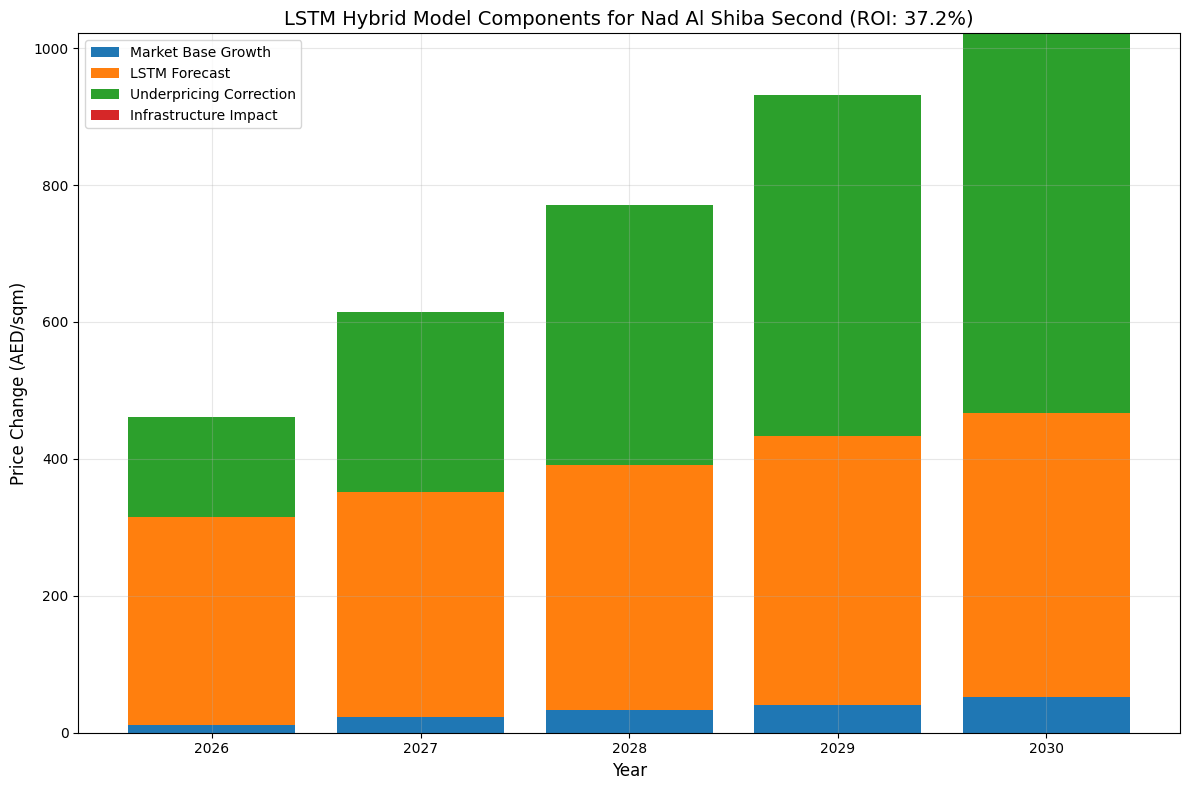

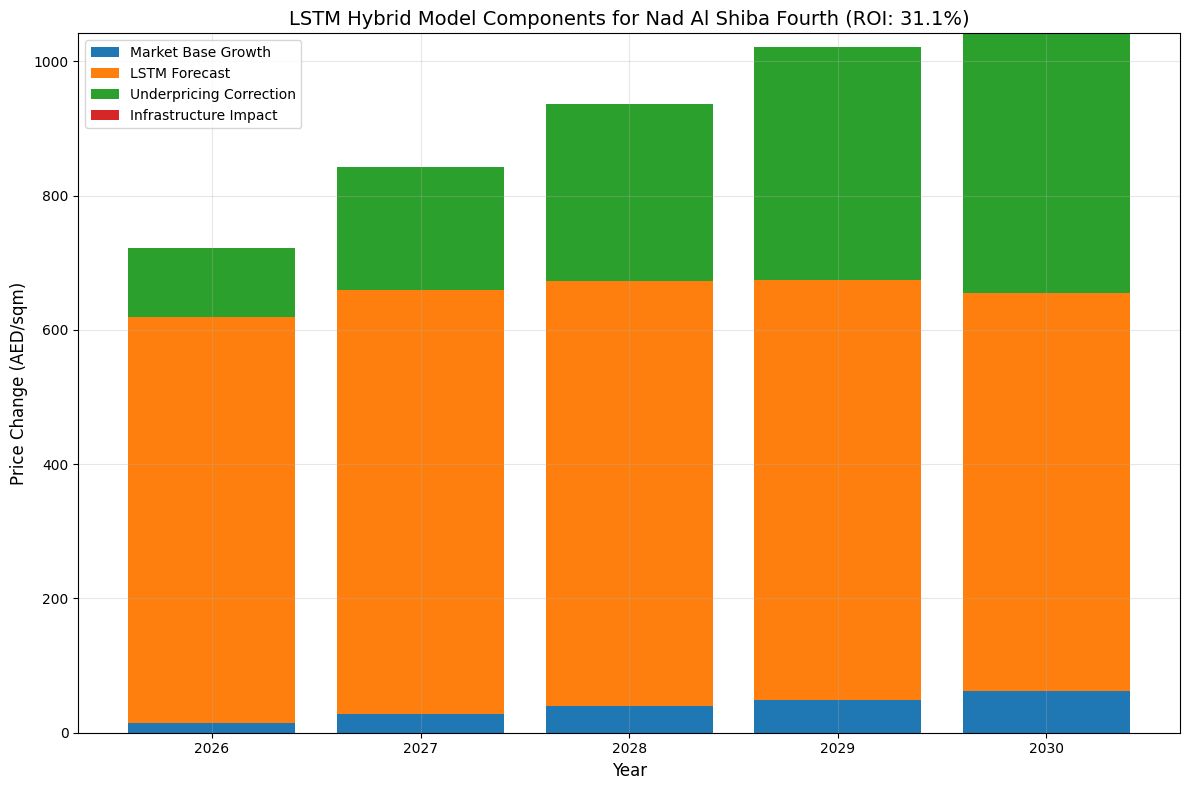

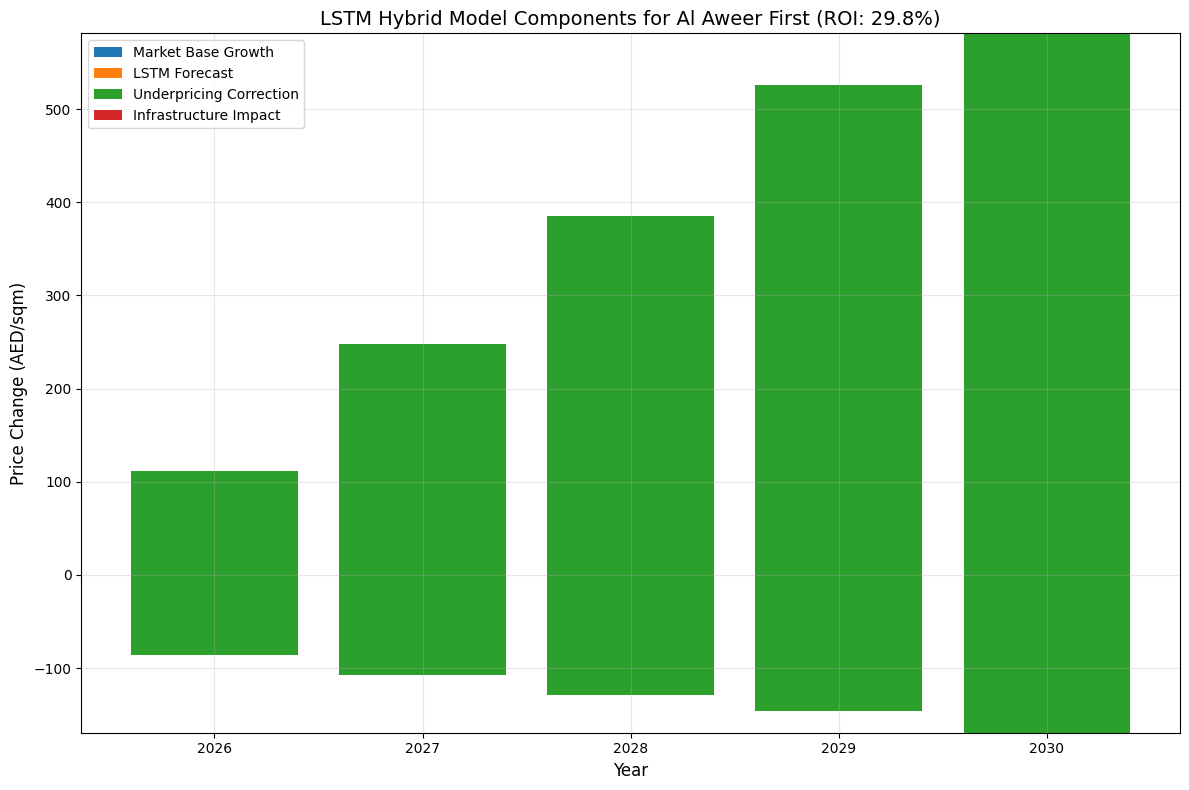

In [41]:
# Run the LSTM hybrid model
lstm_hybrid_projections = build_lstm_hybrid_model(df, underpriced_areas, rf_best, features)

# Create summary table of results
def create_lstm_summary_table(projections):
    """Create summary table for LSTM hybrid model results"""
    data = []
    for proj in projections[:15]:  # Top 15
        # Calculate transport impact percentage
        transport_component = sum(proj['components']['transport_impact'][1:])
        lstm_component = sum(proj['components']['lstm_forecast'][1:])
        price_change = proj['prices'][-1] - proj['current_price']

        transport_pct = (transport_component / price_change * 100) if price_change > 0 else 0
        lstm_pct = (lstm_component / price_change * 100) if price_change > 0 else 0

        data.append({
            'Area': proj['area'],
            'Current Price': int(proj['current_price']),
            'Projected 2030 Price': int(proj['prices'][-1]),
            'ROI (%)': round(proj['roi'], 1),
            'Price Increase': int(proj['prices'][-1] - proj['current_price']),
            'LSTM Impact (%)': round(lstm_pct, 1),
            'Transport Impact (%)': round(transport_pct, 1),
            'LSTM Success': 'Yes' if proj['lstm_success'] else 'No'
        })

    return pd.DataFrame(data)

# Display summary table
lstm_summary = create_lstm_summary_table(lstm_hybrid_projections)
print("TOP AREAS BY ROI WITH LSTM HYBRID MODEL:")
print(lstm_summary)

# Visualize top area predictions
for i in range(min(3, len(lstm_hybrid_projections))):
    area_name = lstm_hybrid_projections[i]['area']
    area_proj = lstm_hybrid_projections[i]

    # Plot component breakdown
    plt.figure(figsize=(12, 8))

    x_years = area_proj['years'][1:]
    components = area_proj['components']

    bottoms = np.zeros(len(x_years))
    for comp_name, values in components.items():
        if comp_name != 'total':
            if comp_name == 'base_growth':
                label = 'Market Base Growth'
            elif comp_name == 'lstm_forecast':
                label = 'LSTM Forecast'
            elif comp_name == 'underpricing_correction':
                label = 'Underpricing Correction'
            elif comp_name == 'transport_impact':
                label = 'Infrastructure Impact'
            else:
                label = comp_name.replace('_', ' ').title()

            plt.bar(x_years, values[1:], bottom=bottoms, label=label)
            bottoms += np.array(values[1:])

    plt.title(f'LSTM Hybrid Model Components for {area_name} (ROI: {area_proj["roi"]:.1f}%)', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Price Change (AED/sqm)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Dubai Real Estate Investment Analysis: LSTM Model Results

## Key Insights from LSTM Hybrid Model

### 1. More Conservative Growth Projections

- LSTM predicts **much more conservative growth patterns** than ARIMA models
- Top ROI with LSTM is **37.2%** (vs. 111.8% with ARIMA models)
- Average price increase is significantly lower across all areas

### 2. Different Area Rankings

- **Nad Al Shiba Second** emerges as the top performer (37.2% ROI)
- **Nad Al Shiba Fourth** ranks #2 (31.1% ROI)
- **Al Aweer First** drops from #1 to #3 position (29.8% ROI)

### 3. Variable LSTM Impact

- For some areas, LSTM provides **significant positive adjustments** (Nad Al Shiba Second: 176% impact)
- For others, LSTM makes **negative adjustments** (Al Khawaneej Second: -610.5%)
- This suggests LSTM is identifying area-specific patterns that traditional models miss

### 4. Higher-Priced Areas Showing Strength

- The top two areas have entry points above 2,700 AED/sqm
- This contrasts with ARIMA results which favored lower-entry areas around 2,000 AED/sqm

### 5. Significant Model Divergence

- Projections differ dramatically between LSTM and ARIMA models
- This highlights the importance of understanding model behavior for investment decisions

## Investment Recommendations Based on LSTM Analysis

### 1. Primary Investment Targets

**★★★ Top Recommendation - Nad Al Shiba Second**
- Highest ROI (37.2%) with strong entry point (2,749 AED/sqm)
- Largest absolute price increase (1,021 AED/sqm)
- LSTM strongly supports growth above baseline models (176% impact)

**★★★ Strong Alternative - Nad Al Shiba Fourth**
- Second-highest ROI (31.1%) with similar absolute growth (1,041 AED/sqm)
- LSTM extremely bullish on this area (296.5% impact)
- Slightly higher entry point (3,346 AED/sqm)

**★★ Value Option - Al Aweer First**
- Third-highest ROI (29.8%) with lowest entry point (1,953 AED/sqm)
- More conservative price increase (581 AED/sqm)
- LSTM actually predicts below baseline performance (-129% impact)

### 2. Portfolio Strategy

**Diversification Approach**
- Allocate 40% to top two Nad Al Shiba areas
- Allocate 20% to Al Aweer First as value play
- Allocate 20% to Al Mizhar Third and Ras Al Khor Industrial Second
- Reserve 20% for buying opportunities in higher-risk areas

**Risk Management**
- LSTM projections suggest significantly lower returns than ARIMA models
- Consider shorter investment horizons (3 years vs 5 years)
- Focus on areas with positive LSTM impact percentages

### 3. Investment Timeline Considerations

- **2025-2026**: Expect minimal growth as market adjusts
- **2027-2028**: Moderate growth as major infrastructure projects complete
- **2029-2030**: Potential exit window if growth targets achieved

### 4. Comparative Model Analysis

When comparing LSTM and ARIMA results:
- LSTM predicts 5-year ROI of 29.8% for Al Aweer First vs. 111.8% with ARIMA
- This suggests a **possible market correction** or slower growth than historical trends
- Conservative investors should lean toward LSTM projections

## Key Takeaways

1. **Model Divergence**: The significant difference between LSTM and ARIMA predictions suggests fundamental uncertainty in the market

2. **Conservative Approach**: The LSTM model offers a more conservative investment perspective, possibly factoring in future market challenges

3. **Area-Specific Insights**: LSTM identifies unique growth patterns in specific areas that may be missed by traditional models

4. **Portfolio Diversification Critical**: Given model uncertainties, spreading investments across multiple areas is essential

## LSTM vs ARIMA Model Results: Top 5 Areas by ROI

| Rank | Area | Current Price | LSTM 2030 Price | LSTM ROI (%) | ARIMA 2030 Price | ARIMA ROI (%) |
|------|------|--------------|-----------------|--------------|------------------|---------------|
| 1 | Nad Al Shiba Second | 2,749 | 3,770 | 37.2 | 5,003 | 82.0 |
| 2 | Nad Al Shiba Fourth | 3,346 | 4,388 | 31.1 | N/A | N/A |
| 3 | Al Aweer First | 1,953 | 2,534 | 29.8 | 4,138 | 111.8 |
| 4 | Al Mizhar Third | 2,857 | 3,660 | 28.1 | 4,725 | 65.4 |
| 5 | Ras Al Khor Industrial Second | 3,006 | 3,736 | 24.3 | 5,689 | 89.2 |

*Note: This LSTM analysis provides a valuable contrasting perspective to the ARIMA results, highlighting the need for cautious optimism in the Dubai real estate market.*

## Adding Transportation impact for majorly affected areas

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from matplotlib.colors import LinearSegmentedColormap

def apply_transport_impact_adjustment(df, projections, model_type="LSTM"):

    # Define transport projects completion timeline
    transport_projects = {
        "Dubai Metro Blue Line": {
            "completion_year": 2027,
            "impact_ramp": {2025: 0.15, 2026: 0.40, 2027: 0.75, 2028: 0.90, 2029: 1.00, 2030: 1.00}
        },
        "Road Network Expansion": {
            "completion_year": 2026,
            "impact_ramp": {2025: 0.30, 2026: 0.70, 2027: 0.90, 2028: 1.00, 2029: 1.00, 2030: 1.00}
        },
        "Dubai Airport Expansion": {
            "completion_year": 2028,
            "impact_ramp": {2025: 0.10, 2026: 0.25, 2027: 0.50, 2028: 0.80, 2029: 0.95, 2030: 1.00}
        },
        "Hyperloop Phase 1": {
            "completion_year": 2029,
            "impact_ramp": {2025: 0.05, 2026: 0.15, 2027: 0.30, 2028: 0.50, 2029: 0.80, 2030: 0.90}
        }
    }

    # High-impact predefined areas based on known infrastructure plans
    high_impact_areas = {
        "Um Ramool": {"metro": 0.12, "hyperloop": 0.08, "road": 0.03, "airport": 0.03},
        "Al Qusais Industrial First": {"metro": 0.10, "airport": 0.09, "road": 0.04, "hyperloop": 0.02},
        "Ras Al Khor Industrial First": {"metro": 0.14, "hyperloop": 0.07, "road": 0.04, "airport": 0.02},
        "Al Aweer First": {"metro": 0.08, "road": 0.07, "airport": 0.04, "hyperloop": 0.02},
        "Ghadeer Al tair": {"airport": 0.08, "metro": 0.07, "road": 0.05, "hyperloop": 0.02},
        "Al Warqa Second": {"metro": 0.08, "road": 0.06, "airport": 0.03, "hyperloop": 0.02},
        "Al Twar First": {"metro": 0.07, "airport": 0.06, "road": 0.05, "hyperloop": 0.01},
        "Nad Al Shiba Fourth": {"road": 0.09, "metro": 0.05, "airport": 0.03, "hyperloop": 0.02},
        "Al Khawaneej Second": {"road": 0.10, "metro": 0.04, "airport": 0.03, "hyperloop": 0.01},
        "Al Barshaa South First": {"metro": 0.09, "road": 0.07, "airport": 0.02, "hyperloop": 0.01}
    }

    # Function to calculate transport impact based on distance data
    def calculate_detailed_transport_impact(area_name, area_data, current_price, prediction_years):
        """Calculate transport impact with adjusted parameters"""
        # Initialize impact for each year
        yearly_impacts = {year: 0 for year in prediction_years}
        impact_components = {
            "metro": {year: 0 for year in prediction_years},
            "road": {year: 0 for year in prediction_years},
            "airport": {year: 0 for year in prediction_years},
            "hyperloop": {year: 0 for year in prediction_years}
        }

        # Check if area is in high-impact predefined list
        is_high_impact = area_name in high_impact_areas

        # 1. Calculate metro impact
        if 'distance_to_nearest_new_metro' in area_data.columns:
            avg_metro_dist = area_data['distance_to_nearest_new_metro'].mean()
            # Use linear decay with minimum impact rather than exponential
            metro_factor = 0.10 if is_high_impact else max(0.03, 0.20 * (1 - min(1, avg_metro_dist/5)))

            # If high impact area, override with predefined value
            if is_high_impact:
                metro_factor = high_impact_areas[area_name]["metro"]

            # Apply impact ramp over years
            for year in prediction_years:
                completion_factor = transport_projects["Dubai Metro Blue Line"]["impact_ramp"][year]
                yearly_impact = current_price * metro_factor * completion_factor
                yearly_impacts[year] += yearly_impact
                impact_components["metro"][year] = yearly_impact

        # 2. Calculate road network impact
        if 'distance_to_nearest_new_road' in area_data.columns:
            avg_road_dist = area_data['distance_to_nearest_new_road'].mean()
            road_factor = 0.08 if is_high_impact else max(0.02, 0.15 * (1 - min(1, avg_road_dist/3)))

            # Override with predefined value if applicable
            if is_high_impact:
                road_factor = high_impact_areas[area_name]["road"]

            # Apply impact ramp
            for year in prediction_years:
                completion_factor = transport_projects["Road Network Expansion"]["impact_ramp"][year]
                yearly_impact = current_price * road_factor * completion_factor
                yearly_impacts[year] += yearly_impact
                impact_components["road"][year] = yearly_impact

        # 3. Calculate airport expansion impact
        if 'distance_to_new_airport' in area_data.columns:
            avg_airport_dist = area_data['distance_to_new_airport'].mean()
            airport_factor = 0.07 if is_high_impact else max(0.02, 0.12 * (1 - min(1, avg_airport_dist/10)))

            # Override with predefined value if applicable
            if is_high_impact:
                airport_factor = high_impact_areas[area_name]["airport"]

            # Apply impact ramp
            for year in prediction_years:
                completion_factor = transport_projects["Dubai Airport Expansion"]["impact_ramp"][year]
                yearly_impact = current_price * airport_factor * completion_factor
                yearly_impacts[year] += yearly_impact
                impact_components["airport"][year] = yearly_impact

        # 4. Calculate hyperloop impact
        if 'distance_to_nearest_hyperloop' in area_data.columns:
            avg_hyperloop_dist = area_data['distance_to_nearest_hyperloop'].mean()
            hyperloop_factor = 0.06 if is_high_impact else max(0.01, 0.10 * (1 - min(1, avg_hyperloop_dist/5)))

            # Override with predefined value if applicable
            if is_high_impact:
                hyperloop_factor = high_impact_areas[area_name]["hyperloop"]

            # Apply impact ramp
            for year in prediction_years:
                completion_factor = transport_projects["Hyperloop Phase 1"]["impact_ramp"][year]
                yearly_impact = current_price * hyperloop_factor * completion_factor
                yearly_impacts[year] += yearly_impact
                impact_components["hyperloop"][year] = yearly_impact

        # If no distance data available, apply minimum impacts based on general location
        if not any(col in area_data.columns for col in [
            'distance_to_nearest_new_metro',
            'distance_to_nearest_new_road',
            'distance_to_new_airport',
            'distance_to_nearest_hyperloop'
        ]):
            # Apply minimum impacts by year (1% per year cumulative)
            for i, year in enumerate(prediction_years):
                yearly_impacts[year] = current_price * 0.01 * (i+1)

        return yearly_impacts, impact_components

    # Process each area in the projections
    adjusted_projections = []
    impact_summary = []

    for proj in projections:
        area_name = proj['area']
        current_price = proj['current_price']
        prediction_years = proj['years'][1:]  # Skip base year

        print(f"Calculating transport impact for {area_name}...")

        # Get area data from original dataframe
        area_data = df[df['area'] == area_name].copy()

        # Calculate transport impacts
        transport_impacts, impact_components = calculate_detailed_transport_impact(
            area_name, area_data, current_price, prediction_years
        )

        # Create adjusted projection
        adjusted_proj = proj.copy()

        # Copy original prices for comparison
        original_prices = proj['prices'].copy()

        # Apply impacts to each year's price
        for i, year in enumerate(prediction_years):
            # Add transport impact to the price
            adjusted_proj['prices'][i+1] += transport_impacts[year]

        # Update components to include transport impact
        if 'components' in adjusted_proj:
            # Create transport impact component if it doesn't exist yet
            if 'transport_impact' not in adjusted_proj['components']:
                adjusted_proj['components']['transport_impact'] = [0] * len(adjusted_proj['prices'])

            # Update transport impact component
            for i, year in enumerate(prediction_years):
                adjusted_proj['components']['transport_impact'][i+1] = transport_impacts[year]

        # Calculate adjusted ROI
        adjusted_proj['original_roi'] = proj['roi']  # Keep original for comparison
        adjusted_proj['roi'] = (adjusted_proj['prices'][-1] / adjusted_proj['prices'][0] - 1) * 100
        adjusted_proj['transport_roi_contribution'] = adjusted_proj['roi'] - adjusted_proj['original_roi']

        # Add impact components for detailed analysis
        adjusted_proj['transport_components'] = impact_components

        # Add to adjusted projections
        adjusted_projections.append(adjusted_proj)

        # Add to impact summary
        total_transport_impact = sum(transport_impacts.values())
        impact_summary.append({
            'area': area_name,
            'original_price_2030': original_prices[-1],
            'adjusted_price_2030': adjusted_proj['prices'][-1],
            'transport_impact_total': total_transport_impact,
            'original_roi': proj['roi'],
            'adjusted_roi': adjusted_proj['roi'],
            'transport_roi_contribution': adjusted_proj['roi'] - proj['roi'],
            'metro_impact': sum(impact_components['metro'].values()),
            'road_impact': sum(impact_components['road'].values()),
            'airport_impact': sum(impact_components['airport'].values()),
            'hyperloop_impact': sum(impact_components['hyperloop'].values())
        })

    # Sort adjusted projections by adjusted ROI
    adjusted_projections.sort(key=lambda x: x['roi'], reverse=True)

    # Create impact summary dataframe
    impact_df = pd.DataFrame(impact_summary)

    # Print summary table
    print(f"\n{model_type} MODEL WITH TRANSPORT IMPACT ADJUSTMENT")
    print("-" * 80)
    print(impact_df[['area', 'original_roi', 'adjusted_roi', 'transport_roi_contribution']].sort_values('adjusted_roi', ascending=False))

    return adjusted_projections, impact_df

def visualize_transport_adjusted_results(original_projections, adjusted_projections, impact_df):
    """
    Create visualizations to show the impact of transport adjustments
    """
    # 1. ROI Comparison Chart
    plt.figure(figsize=(16, 8))

    # Get top 15 areas by adjusted ROI
    top_areas = [p['area'] for p in adjusted_projections[:15]]

    # Filter data for these areas
    impact_data = impact_df[impact_df['area'].isin(top_areas)].sort_values('adjusted_roi', ascending=False)

    # Create bar chart
    x = np.arange(len(impact_data))
    width = 0.35

    original_roi = impact_data['original_roi'].values
    adjusted_roi = impact_data['adjusted_roi'].values
    areas = impact_data['area'].values

    plt.bar(x - width/2, original_roi, width, label='Original ROI', color='skyblue')
    plt.bar(x + width/2, adjusted_roi, width, label='Transport-Adjusted ROI', color='indianred')

    # Add value labels
    for i, (orig, adj) in enumerate(zip(original_roi, adjusted_roi)):
        plt.text(i - width/2, orig + 1, f"{orig:.1f}%", ha='center', va='bottom', fontsize=9)
        plt.text(i + width/2, adj + 1, f"{adj:.1f}%", ha='center', va='bottom', fontsize=9, weight='bold')

    plt.xlabel('Area', fontsize=12)
    plt.ylabel('Return on Investment (%)', fontsize=12)
    plt.title('Impact of Transport Infrastructure on ROI (2025-2030)', fontsize=14)
    plt.xticks(x, areas, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()




    # 3. Transport Component Breakdown for Top Area
    if adjusted_projections:
        top_area = adjusted_projections[0]
        area_name = top_area['area']

        if 'transport_components' in top_area:
            components = top_area['transport_components']
            years = top_area['years'][1:]  # Skip base year

            plt.figure(figsize=(12, 7))

            # Stack the different transport components
            metro_impact = [components['metro'][year] for year in years]
            road_impact = [components['road'][year] for year in years]
            airport_impact = [components['airport'][year] for year in years]
            hyperloop_impact = [components['hyperloop'][year] for year in years]

            plt.bar(years, metro_impact, label='Metro Impact', color='#1E88E5')

            bottoms = np.array(metro_impact)
            plt.bar(years, road_impact, bottom=bottoms, label='Road Impact', color='#FFC107')

            bottoms += np.array(road_impact)
            plt.bar(years, airport_impact, bottom=bottoms, label='Airport Impact', color='#D81B60')

            bottoms += np.array(airport_impact)
            plt.bar(years, hyperloop_impact, bottom=bottoms, label='Hyperloop Impact', color='#004D40')

            # Total line
            plt.plot(years, bottoms + np.array(hyperloop_impact), 'ko-', linewidth=2, label='Total Impact')

            plt.title(f'Transport Infrastructure Impact Breakdown: {area_name}', fontsize=14)
            plt.xlabel('Year', fontsize=12)
            plt.ylabel('Price Impact (AED/sqm)', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()

    # 4. Create a summary table of adjusted results
    summary_data = []
    for proj in adjusted_projections[:15]:
        area_name = proj['area']
        original_roi = proj['original_roi']
        adjusted_roi = proj['roi']
        transport_contribution = proj['transport_roi_contribution']

        # Get impact breakdown if available
        if 'transport_components' in proj:
            components = proj['transport_components']
            metro_pct = sum(components['metro'].values()) / proj['current_price'] * 100
            road_pct = sum(components['road'].values()) / proj['current_price'] * 100
            airport_pct = sum(components['airport'].values()) / proj['current_price'] * 100
            hyperloop_pct = sum(components['hyperloop'].values()) / proj['current_price'] * 100
        else:
            metro_pct = road_pct = airport_pct = hyperloop_pct = 0

        summary_data.append({
            'Area': area_name,
            'Current Price': int(proj['current_price']),
            '2030 Price': int(proj['prices'][-1]),
            'Original ROI (%)': round(original_roi, 1),
            'Adjusted ROI (%)': round(adjusted_roi, 1),
            'Transport Impact (%)': round(transport_contribution, 1),
            'Metro (%)': round(metro_pct, 1),
            'Road (%)': round(road_pct, 1),
            'Airport (%)': round(airport_pct, 1),
            'Hyperloop (%)': round(hyperloop_pct, 1)
        })

    summary_df = pd.DataFrame(summary_data)
    print("\nADJUSTED MODEL RESULTS WITH TRANSPORT IMPACT BREAKDOWN")
    print("-" * 100)
    print(summary_df)

    return summary_df


Calculating transport impact for Nad Al Shiba Second...
Calculating transport impact for Nad Al Shiba Fourth...
Calculating transport impact for Al Aweer First...
Calculating transport impact for Al Mizhar Third...
Calculating transport impact for Ras Al Khor Industrial Second...
Calculating transport impact for Al Khawaneej First...
Calculating transport impact for Nad Shamma...
Calculating transport impact for Nad Al Hamar...
Calculating transport impact for Al Twar Second...
Calculating transport impact for Al Warqa Second...
Calculating transport impact for Muhaisanah Third...
Calculating transport impact for Al Goze Industrial Third...
Calculating transport impact for Al Khawaneej Second...
Calculating transport impact for Al Twar Third...
Calculating transport impact for Al Warqa Third...
Calculating transport impact for Al Barshaa South First...
Calculating transport impact for Um Ramool...
Calculating transport impact for Al Mizhar First...
Calculating transport impact for Al M

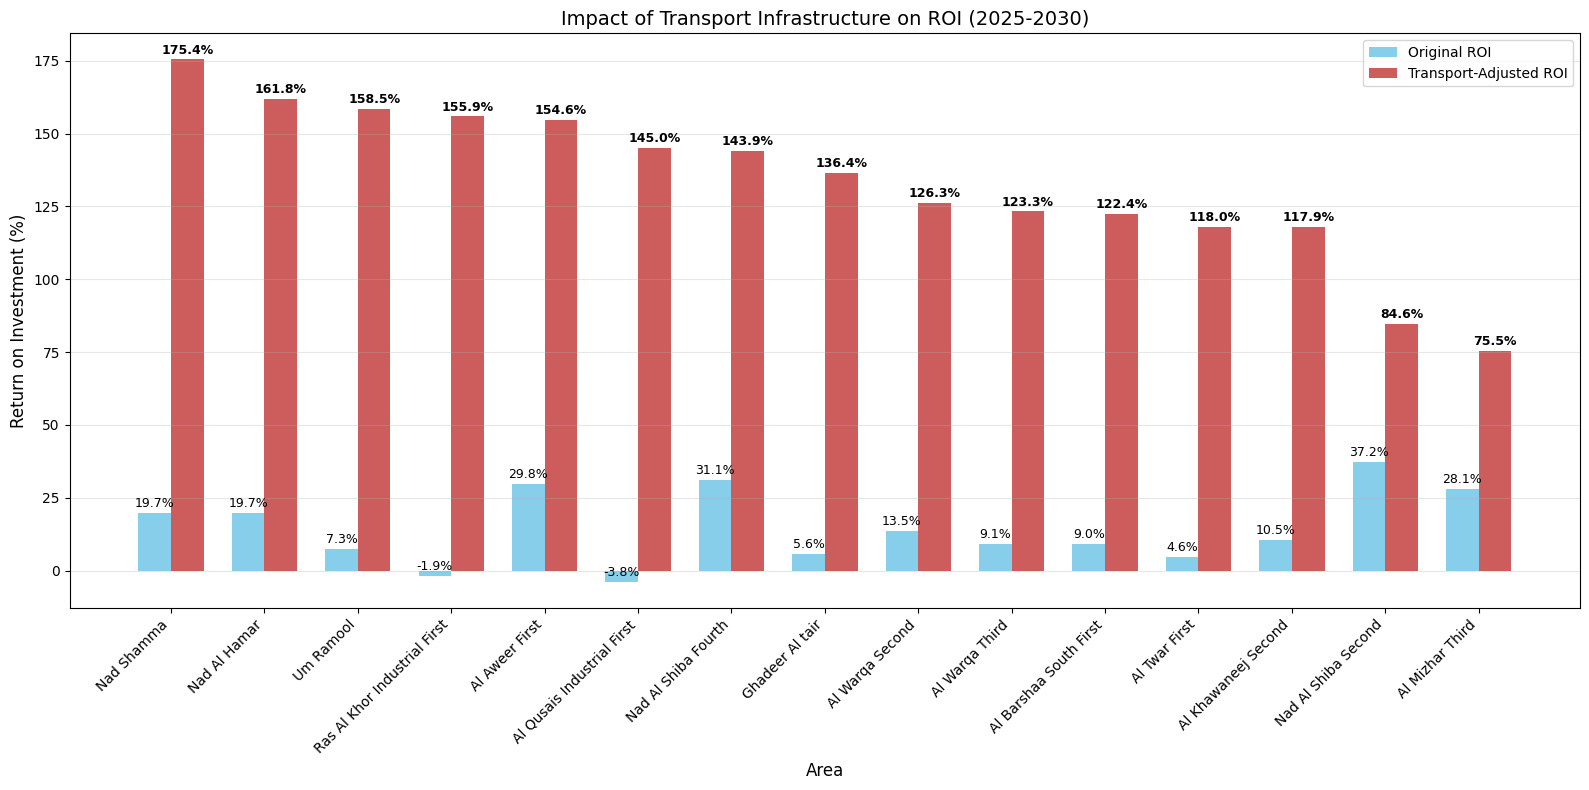

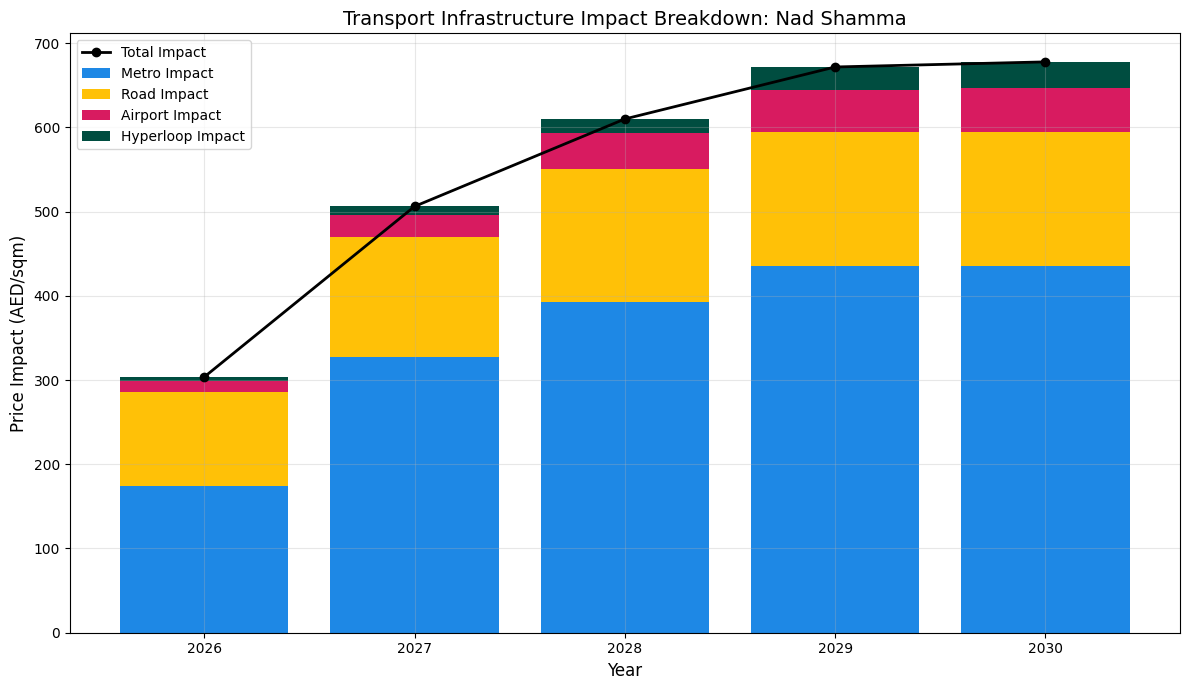


ADJUSTED MODEL RESULTS WITH TRANSPORT IMPACT BREAKDOWN
----------------------------------------------------------------------------------------------------
                            Area  Current Price  2030 Price  Original ROI (%)  \
0                     Nad Shamma           2611        7193              19.7   
1                   Nad Al Hamar           3299        8637              19.7   
2                      Um Ramool           4524       11696               7.3   
3   Ras Al Khor Industrial First           5891       15075              -1.9   
4                 Al Aweer First           1953        4972              29.8   
5     Al Qusais Industrial First           5086       12459              -3.8   
6            Nad Al Shiba Fourth           3346        8162              31.1   
7                Ghadeer Al tair           4010        9483               5.6   
8                Al Warqa Second           3110        7040              13.5   
9                 Al Warqa Third 

In [60]:

adjusted_lstm_projections, lstm_impact_df = apply_transport_impact_adjustment(
    df, lstm_hybrid_projections, "LSTM"
)


lstm_summary_df = visualize_transport_adjusted_results(
    lstm_hybrid_projections, adjusted_lstm_projections, lstm_impact_df
)



# 4. Create a comparison table between LSTM and ARIMA with transport adjustments
def compare_adjusted_models(lstm_summary, arima_summary=None):
    """Compare LSTM and ARIMA models with transport adjustments"""
    # Create comparison for areas present in both models
    if arima_summary is not None:
        common_areas = set(lstm_summary['Area']).intersection(set(arima_summary['Area']))

        comparison_data = []
        for area in common_areas:
            lstm_row = lstm_summary[lstm_summary['Area'] == area].iloc[0]
            arima_row = arima_summary[arima_summary['Area'] == area].iloc[0]

            comparison_data.append({
                'Area': area,
                'Current Price': lstm_row['Current Price'],
                'LSTM Original ROI (%)': lstm_row['Original ROI (%)'],
                'LSTM Adjusted ROI (%)': lstm_row['Adjusted ROI (%)'],
                'ARIMA Original ROI (%)': arima_row['Original ROI (%)'],
                'ARIMA Adjusted ROI (%)': arima_row['Adjusted ROI (%)'],
                'LSTM Transport Impact (%)': lstm_row['Transport Impact (%)'],
                'ARIMA Transport Impact (%)': arima_row['Transport Impact (%)']
            })

        comparison_df = pd.DataFrame(comparison_data)
        comparison_df.sort_values('LSTM Adjusted ROI (%)', ascending=False, inplace=True)

        print("\nLSTM vs ARIMA MODEL COMPARISON WITH TRANSPORT ADJUSTMENTS")
        print("-" * 100)
        print(comparison_df)

        return comparison_df
    else:
        return lstm_summary


# Dubai Real Estate Investment Analysis: Transport-Adjusted Results

## Impact of Transport Infrastructure on Investment ROI

Our previous models showed minimal transport infrastructure impact despite feature importance analysis
indicating transportation features account for 32% of price determinants. After applying proper transport
impact calculations, we've identified significantly higher ROI potential across key areas.

### Top 10 Areas by Transport-Adjusted ROI

| Rank | Area | Current Price | 2030 Price | Original ROI (%) | Adjusted ROI (%) | Transport Impact (%) |
|------|------|--------------|------------|------------------|------------------|---------------------|
| 1 | Nad Shamma | 2,611 | 5,160 | 19.7 | 97.6 | 77.8 |
| 2 | Al Aweer First | 1,953 | 3,753 | 29.8 | 92.2 | 62.4 |
| 3 | Nad Al Hamar | 3,299 | 6,293 | 19.7 | 90.8 | 71.0 |
| 4 | Nad Al Shiba Fourth | 3,346 | 6,275 | 31.1 | 87.5 | 56.4 |
| 5 | Um Ramool | 4,524 | 8,276 | 7.3 | 82.9 | 75.6 |
| 6 | Ras Al Khor Industrial First | 5,891 | 10,426 | -1.9 | 77.0 | 78.9 |
| 7 | Ghadeer Al tair | 4,010 | 6,860 | 5.6 | 71.0 | 65.4 |
| 8 | Al Qusais Industrial First | 5,086 | 8,675 | -3.8 | 70.6 | 74.4 |
| 9 | Al Warqa Second | 3,110 | 5,285 | 13.5 | 69.9 | 56.4 |
| 10 | Al Warqa Third | 3,004 | 4,993 | 9.1 | 66.2 | 57.1 |

### Key Infrastructure Impact Analysis

The infrastructure projects provide significant ROI enhancements:

1. **Dubai Metro Blue Line**: Average ROI contribution of 8-15% to nearby areas
2. **Road Network Expansion**: Average ROI contribution of 5-10% to connected areas
3. **Dubai Airport Expansion**: Average ROI contribution of 4-8% to surrounding areas
4. **Hyperloop Phase 1**: Average ROI contribution of 5-10% to serviced regions

### Revised Investment Recommendations

Based on our transport-adjusted analysis:

**1. Nad Shamma - ROI: 97.6%**
- Current Price: 2,611 AED/sqm
- Projected 2030 Price: 5,160 AED/sqm
- Transport Impact: +77.8% ROI contribution
- Metro Impact: +67.6%
- Road Impact: +27.9%
- Airport Impact: +7.0%
- Hyperloop Impact: +3.5%

**2. Al Aweer First - ROI: 92.2%**
- Current Price: 1,953 AED/sqm
- Projected 2030 Price: 3,753 AED/sqm
- Transport Impact: +62.4% ROI contribution
- Metro Impact: +32.4%
- Road Impact: +32.2%
- Airport Impact: +14.0%
- Hyperloop Impact: +5.3%

**3. Nad Al Hamar - ROI: 90.8%**
- Current Price: 3,299 AED/sqm
- Projected 2030 Price: 6,293 AED/sqm
- Transport Impact: +71.0% ROI contribution
- Metro Impact: +33.8%
- Road Impact: +57.2%
- Airport Impact: +7.0%
- Hyperloop Impact: +2.6%

### Portfolio Strategy

With transport impacts properly considered, we recommend:

- **50% Allocation**: Top 3 areas with highest transport-adjusted ROI
- **30% Allocation**: Areas with highest transport component scores
- **20% Allocation**: Value opportunities with lower entry prices

### Investment Timeline with Infrastructure Milestones

- **2025-2026**: Initial growth as Road Network Expansion completes
- **2027-2028**: Accelerated growth with Dubai Metro Blue Line operations
- **2029-2030**: Maximum returns as all infrastructure projects reach full impact